# Section 0: Preliminary Work

<p style="color:red;">N.B.: The IMF WEO dataset has to be updated twice each year (in April and October), while the EBA assessment framework (Section 10) once a year!!</p>

In [188]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-bright')
from dbnomics import fetch_series
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import quandl

from fredapi import Fred
import yfinance as yf

import scipy
from bs4 import BeautifulSoup
import requests
import ipywidgets as widgets
import plotly.express as px
import investpy
import datetime as dt
import rise

In [189]:
#Time window for annual analysis
start='1995-01-01' #Start date for several analysis
today = '2021-01-01' #IMPORTANT: it is the last complete full year
current_quarter = '2022-01-01' #Beginning of current quarter
current_month = '2022-01-01'   #Beginning of current month
fd = '01/01/2018' #Date from when fetching economic calendar data
td = dt.datetime.today().strftime("%d/%m/%Y") #Today
country = 'united states'

In [190]:
#Fetch economic calendar of the country
eco_cal = investpy.news.economic_calendar(countries=[country], from_date=fd, to_date=td)

In [191]:
#Define a function to clean data fetched from DBnomics
def clean_data(data, name):
    data = data[['period', 'value']]
    data = data.set_index('period')
    data = data.loc[start:]
    data = data.rename(columns={'value': name})
    
    return(data)    

In [192]:
#Define a function to filter specific percentage data from the economic calendar and convert it to float
def eco_cal_data_pct(event):
    
    df = eco_cal[eco_cal['event'].str.startswith(event)]
    df = df[['date', 'actual']] 
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['actual'] = list(map(lambda x: x[:-1], df['actual'].values))
    df['actual'] = [float(x) for x in df['actual'].values]
    df = df.rename(columns={'actual':event})
    
    return(df)

In [193]:
#Define a function to filter specific data from the economic calendar and convert it to int
def eco_cal_data_int(event):
    
    df = eco_cal[eco_cal['event'].str.startswith(event)]
    df = df[['date', 'actual']] 
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['actual'] = list(map(lambda x: x[:-1], df['actual'].values))
    df['actual'] = [int(x.replace(',',"").strip()) for x in df['actual'].values]
    df = df.rename(columns={'actual':event})
    
    return(df)

# Section 1: Supply and Productivity

In this section we are going to analyze the total factor productivity and labor supply of the U.S. Our goal is to understand if the so-called "A" factor in the Cobb-Douglas function (Y = A * K^a * L^(1-a)) is positive (meaning that structural reforms, technological progress and policies are contributing positively to the long-term productivity of the country) or not. We will also look at the unemployment level compared to its natural rate and estimate the potential level of labor (L*).

In [7]:
#Fetch data for Total Factor Productivity
tfp = fetch_series('AMECO/ZVGDF/USA.3.0.0.0.ZVGDF')
tfp = clean_data(tfp, 'TFP')

#Fetch data for Capital share in TFP
cap_share = fetch_series('AMECO/ZVGDK/USA.3.0.0.0.ZVGDK')
cap_share = clean_data(cap_share, 'Capital Share in TFP')

#Fetch data for Labor share in TFP
lab_share = fetch_series('AMECO/ZVGDE/USA.3.0.0.0.ZVGDE')
lab_share = clean_data(lab_share, 'Labor Share in TFP')

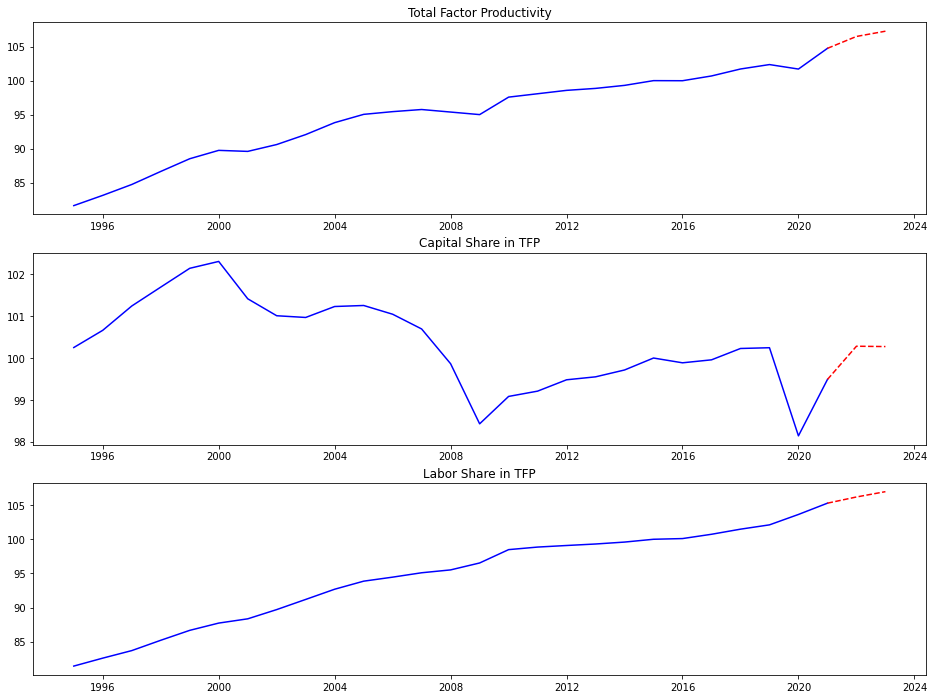

In [8]:
#Let's plot the TFP level till today and its projection
plt.subplots(figsize=(16,12))
plt.subplot(311)
plt.plot(tfp[:today], color='b')
plt.plot(tfp[today:], color='r', linestyle='--')
plt.title('Total Factor Productivity')

plt.subplot(312)
plt.plot(cap_share[:today], color='b')
plt.plot(cap_share[today:], color='r', linestyle='--')
plt.title('Capital Share in TFP')

plt.subplot(313)
plt.plot(lab_share[:today], color='b')
plt.plot(lab_share[today:], color='r', linestyle='--')
plt.title('Labor Share in TFP')

plt.show()

In [9]:
#Fetch data for Capital productivity 
cap_prod = fetch_series('AMECO/AVGDK/USA.1.0.0.0.AVGDK')
cap_prod = clean_data(cap_prod, 'Capital Productivity')

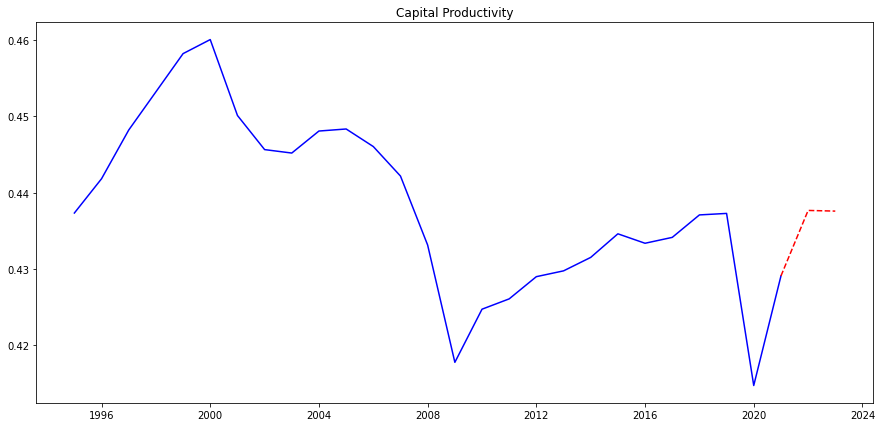

In [10]:
#Plot Capital Productivity data
plt.figure(figsize=(15,7))
plt.plot(cap_prod.loc[:today], color='b')
plt.plot(cap_prod.loc[today:], color='r', linestyle='--')
plt.title('Capital Productivity')
plt.show()

In [11]:
#Fetching and cleaning labor force data (SA)
labor_force = fetch_series('ILO/EAP_TEA1_SEX_AGE_NB/USA.BA_453.AGE_AGGREGATE_TOTAL.SEX_T.Q')

labor_force = clean_data(labor_force, 'Labor Force (Thousands)')

labor_force.tail()

Labor Force (Thousands)
period                             
2020-10-01                 160681.3
2021-01-01                 160391.3
2021-04-01                 160964.3
2021-07-01                 161450.3
2021-10-01                 162010.0

In [12]:
#Fetching and cleaning unemployment rate data (SA)
unemp_rate = fetch_series('ILO/UNE_DEA1_SEX_AGE_RT/USA.BA_453.AGE_AGGREGATE_TOTAL.SEX_T.Q')
unemp_rate = clean_data(unemp_rate, 'Unemployment Rate (SA)')
unemp_rate.tail()

Unemployment Rate (SA)
period                            
2020-10-01                    6.77
2021-01-01                    6.20
2021-04-01                    5.90
2021-07-01                    5.10
2021-10-01                    4.23

In [13]:
#Merging the two above dataframes
labor_supply = pd.concat([labor_force, unemp_rate], axis=1)
labor_supply.tail()

Labor Force (Thousands)  Unemployment Rate (SA)
period                                                     
2020-10-01                 160681.3                    6.77
2021-01-01                 160391.3                    6.20
2021-04-01                 160964.3                    5.90
2021-07-01                 161450.3                    5.10
2021-10-01                 162010.0                    4.23

In [14]:
#Calculate the Employment rate
labor_supply['Employment Rate'] = 100 - labor_supply['Unemployment Rate (SA)']
labor_supply.tail()

Labor Force (Thousands)  Unemployment Rate (SA)  Employment Rate
period                                                                      
2020-10-01                 160681.3                    6.77            93.23
2021-01-01                 160391.3                    6.20            93.80
2021-04-01                 160964.3                    5.90            94.10
2021-07-01                 161450.3                    5.10            94.90
2021-10-01                 162010.0                    4.23            95.77

In [15]:
#Calculate the Employment level (in thousands)
labor_supply['Employment (L)'] = (labor_supply['Labor Force (Thousands)'] * labor_supply['Employment Rate']) / 100
labor_supply['Log Employment (L)'] = np.log(labor_supply['Employment (L)']).values
labor_supply.tail()

Labor Force (Thousands)  Unemployment Rate (SA)  Employment Rate  \
period                                                                         
2020-10-01                 160681.3                    6.77            93.23   
2021-01-01                 160391.3                    6.20            93.80   
2021-04-01                 160964.3                    5.90            94.10   
2021-07-01                 161450.3                    5.10            94.90   
2021-10-01                 162010.0                    4.23            95.77   

            Employment (L)  Log Employment (L)  
period                                          
2020-10-01    149803.17599           11.917078  
2021-01-01    150447.03940           11.921366  
2021-04-01    151467.40630           11.928126  
2021-07-01    153216.33470           11.939606  
2021-10-01    155156.97700           11.952193

In [16]:
#Estimating with the Hodrick-Prescott filter the potential Employment level (L*)
cycle, trend = sm.tsa.filters.hpfilter(labor_supply['Log Employment (L)'], 1600)
labor_decomp = labor_supply[['Log Employment (L)']]
labor_decomp["cycle"] = cycle
labor_decomp["trend"] = trend

In [17]:
#Fetch the monthly data for the labor force rate (SA) and calculate its 12-M rolling mean
labor_force_rate = fetch_series('ILO/EAP_DWA1_SEX_AGE_RT/USA.BA_453.AGE_AGGREGATE_TOTAL.SEX_T.M')
labor_force_rate = clean_data(labor_force_rate, 'Labor Force Part. Rate (%, SA)')
labor_force_rate['12-M Avg'] = labor_force_rate['Labor Force Part. Rate (%, SA)'].rolling(12).mean()
labor_force_rate.tail()

Labor Force Part. Rate (%, SA)   12-M Avg
period                                               
2021-08-01                            61.7  61.558333
2021-09-01                            61.7  61.583333
2021-10-01                            61.7  61.591667
2021-11-01                            61.9  61.625000
2021-12-01                            61.9  61.658333

In [18]:
#Fetch monthly data for the SA Unemployment rate
unemp_rate=fetch_series('ILO/UNE_DEA1_SEX_AGE_RT/USA.BA_453.AGE_AGGREGATE_TOTAL.SEX_T.M')
unemp_rate=clean_data(unemp_rate, 'Unemp. Rate (SA)')
unemp_rate.tail()

Unemp. Rate (SA)
period                      
2021-08-01               5.2
2021-09-01               4.7
2021-10-01               4.6
2021-11-01               4.2
2021-12-01               3.9

In [19]:
#Downloading the natural rate of unemployment for the U.S. from Quandl
nat_rate = quandl.get("FRED/NROUST", start='1986-01-01', authtoken=api_key)
nat_rate=nat_rate.loc[start:]
nat_rate=nat_rate.rename(columns={'Value':'Natural Rate of Unemployment (Short-Term)'})
nat_rate.tail()

Natural Rate of Unemployment (Short-Term)
Date                                                 
2030-10-01                                   4.294982
2031-01-01                                   4.289282
2031-04-01                                   4.283630
2031-07-01                                   4.278029
2031-10-01                                   4.272470

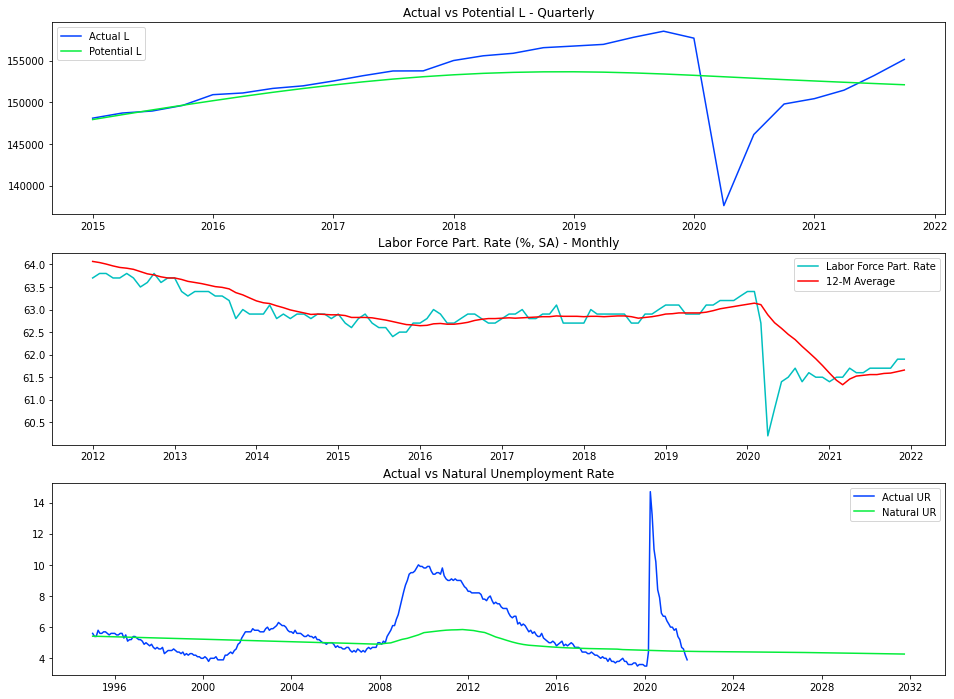

In [20]:
#Plot the actual vs potential Labor level, the labor force part. rate
plt.figure(figsize=(16,12))

plt.subplot(311)
plt.plot(labor_supply['Employment (L)']["2015-01-01":])
plt.plot(np.exp(labor_decomp["trend"]["2015-01-01":]))
plt.title('Actual vs Potential L - Quarterly')
plt.legend(['Actual L', 'Potential L'])

plt.subplot(312)
plt.plot(labor_force_rate['Labor Force Part. Rate (%, SA)'][-120:], color='c')
plt.plot(labor_force_rate['12-M Avg'][-120:], color='r')
plt.title('Labor Force Part. Rate (%, SA) - Monthly')
plt.legend(['Labor Force Part. Rate', '12-M Average'])

plt.subplot(313)
plt.plot(unemp_rate["Unemp. Rate (SA)"][start:])
plt.plot(nat_rate['Natural Rate of Unemployment (Short-Term)'][start:])
plt.title('Actual vs Natural Unemployment Rate')
plt.legend(['Actual UR', 'Natural UR'])

plt.show()

In [116]:
u6 = fred.get_series('U6RATE')

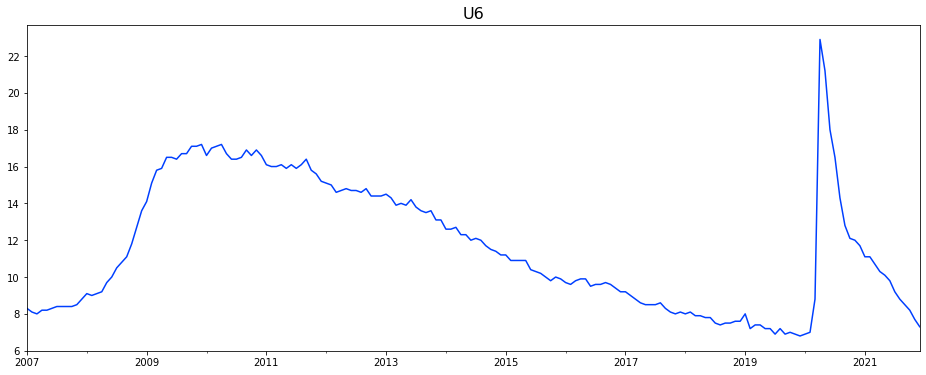

In [125]:
plt.figure(figsize=(16,6))
u6.loc['2007-01-01':].plot()
plt.title('U6', fontsize=16)
plt.show()

In [21]:
#Fetch initial jobless claims data
non_farm_pr = eco_cal_data_int(event='Nonfarm Payrolls')
non_farm_pr.tail()

Nonfarm Payrolls
date                        
2021-09-03               235
2021-10-08               194
2021-11-05               531
2021-12-03               210
2022-01-07               199

In [22]:
jobless_claims = eco_cal_data_int(event='Initial Jobless Claims')
jobless_claims.tail()

Initial Jobless Claims
date                              
2021-12-30                     198
2022-01-06                     207
2022-01-13                     230
2022-01-20                     286
2022-01-27                     260

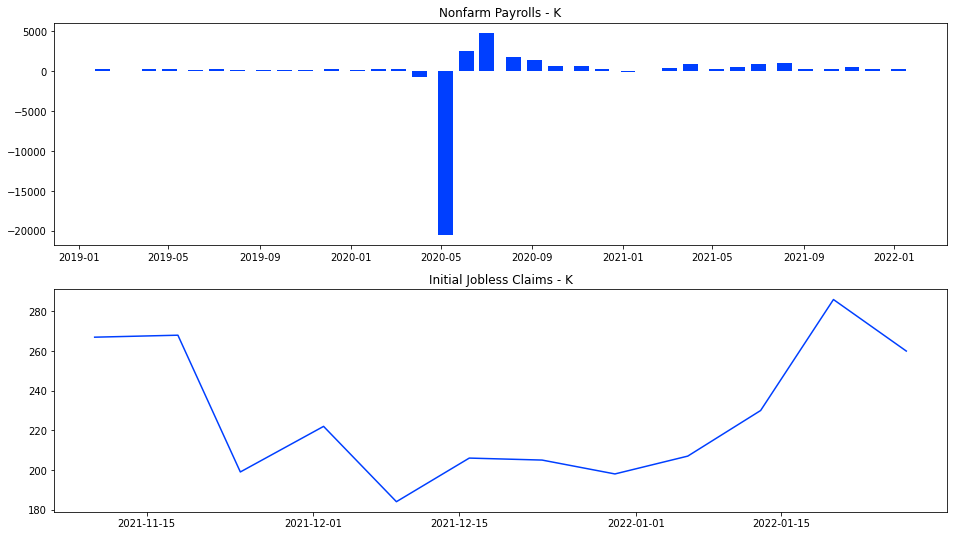

In [127]:
plt.subplots(figsize=(16,9))

plt.subplot(211)
plt.bar(non_farm_pr.index[-36:], non_farm_pr['Nonfarm Payrolls'].iloc[-36:], width=20)
plt.title('Nonfarm Payrolls - K')

plt.subplot(212)
plt.plot(jobless_claims.iloc[-12:])
plt.title('Initial Jobless Claims - K')

plt.show()

# Section 2: Output Gap

In this section our goal is to understand if the economy is running a positive or negative output gap. In the first case we should expect a more tightening approach from policymakers, while in the second one a more dovish attitude.

In [24]:
#Fetch annual data with projections for the output gap from IMF
output_gap = fetch_series('IMF/WEO:2021-10/USA.NGAP_NPGDP.pcent_potential_gdp')
output_gap = clean_data(output_gap, 'Output Gap')
output_gap['zero'] = 0
output_gap.tail(7)

Output Gap  zero
period                      
2020-01-01      -3.317     0
2021-01-01       0.558     0
2022-01-01       3.301     0
2023-01-01       3.014     0
2024-01-01       2.288     0
2025-01-01       1.631     0
2026-01-01       1.078     0

In [25]:
#Fetch quarterly output gap data from FRED
output_gap_FRED = pd.DataFrame()
output_gap_FRED['GDP - Q'] = fred.get_series('GDPC1', frequency='q')
output_gap_FRED['Potential GDP - Q'] = fred.get_series('GDPPOT', frequency='q')
output_gap_FRED['Output Gap'] = (output_gap_FRED['GDP - Q'] - output_gap_FRED['Potential GDP - Q']) / output_gap_FRED['Potential GDP - Q'] * 100
output_gap_FRED.tail()

GDP - Q  Potential GDP - Q  Output Gap
2020-10-01  18767.778           19512.02   -3.814274
2021-01-01  19055.655           19602.54   -2.789868
2021-04-01  19368.310           19697.36   -1.670528
2021-07-01  19478.893           19795.82   -1.600979
2021-10-01  19805.962           19898.25   -0.463800

In [27]:
#Fetch data for quarterly real GDP
real_gdp = fetch_series('OECD/QNA/USA.B1_GS1.LNBARSA.Q')
real_gdp = clean_data(real_gdp, 'Real GDP')
real_gdp['Log Real GDP'] = np.log(real_gdp['Real GDP']).values
real_gdp.tail()

Real GDP  Log Real GDP
period                              
2020-10-01  18767778.0     16.747652
2021-01-01  19055655.0     16.762874
2021-04-01  19368310.0     16.779149
2021-07-01  19478893.0     16.784842
2021-10-01  19805962.0     16.801494

In [28]:
#Estimating the potential GDP with HP fillter
cycle, trend = sm.tsa.filters.hpfilter(real_gdp['Log Real GDP'], 1600)
gdp_decomp = real_gdp[['Log Real GDP']]
gdp_decomp["cycle"] = cycle
gdp_decomp["trend"] = trend

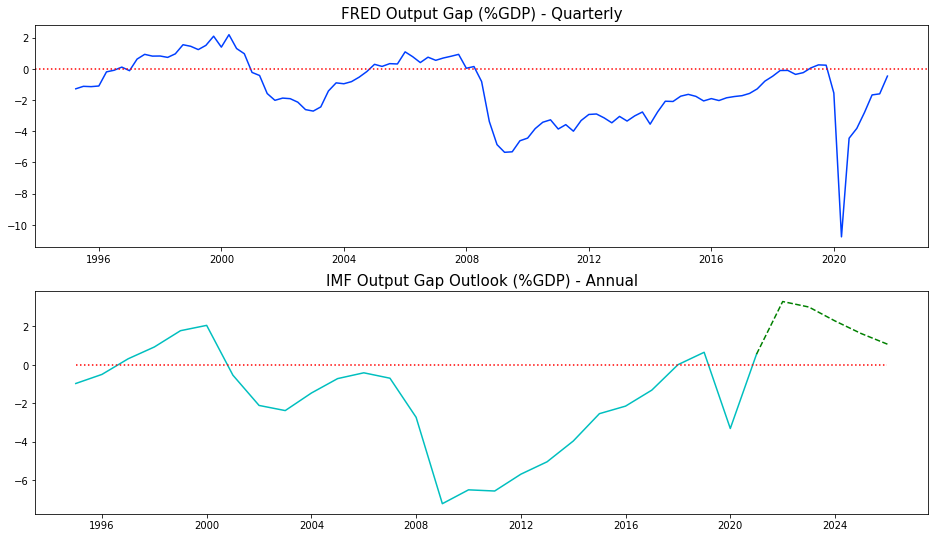

In [130]:
#Plot current and projected output gap and actual vs potential GDP
plt.figure(figsize=(16,9))

plt.subplot(211)
plt.plot(output_gap_FRED['Output Gap']["1995-04-01":])
plt.axhline(y=0, color='red', linestyle=':')
plt.title('FRED Output Gap (%GDP) - Quarterly', size = 15)

plt.subplot(212)
plt.plot(output_gap['Output Gap'][:today], color='c')
plt.plot(output_gap['Output Gap'][today:], color='g', linestyle='--')
plt.plot(output_gap['zero'], color='r', linestyle=':')
plt.title('IMF Output Gap Outlook (%GDP) - Annual', size = 15)

plt.show()

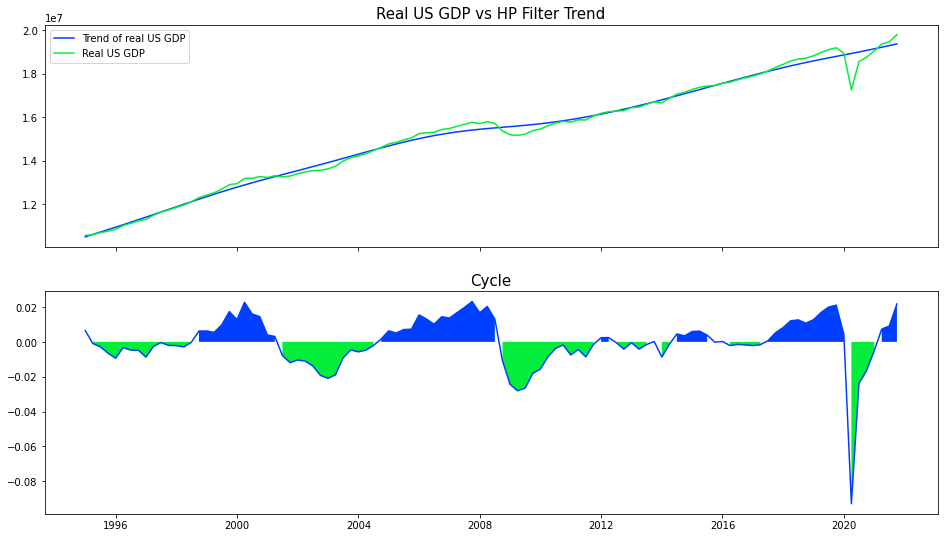

In [30]:
#Plot output gap and cycles
fig,ax = plt.subplots(2,1,sharex = True, figsize = (16,9))

df_trend = pd.Series(index = gdp_decomp.index, data = np.exp(gdp_decomp['trend']))
df_cycle = pd.Series(index = gdp_decomp.index, data = gdp_decomp['cycle'])

zero = [0 for t in gdp_decomp['trend']]

ax[0].plot(df_trend);
ax[0].plot(real_gdp['Real GDP']);
ax[0].legend(['Trend of real US GDP','Real US GDP']);
ax[1].plot(df_cycle)
ax[1].fill_between(real_gdp.index,zero,df_cycle,where=df_cycle > 0);
ax[1].fill_between(real_gdp.index,zero,df_cycle,where=df_cycle < 0);

ax[0].set_title('Real US GDP vs HP Filter Trend',size = 15)
ax[1].set_title('Cycle',size = 15);

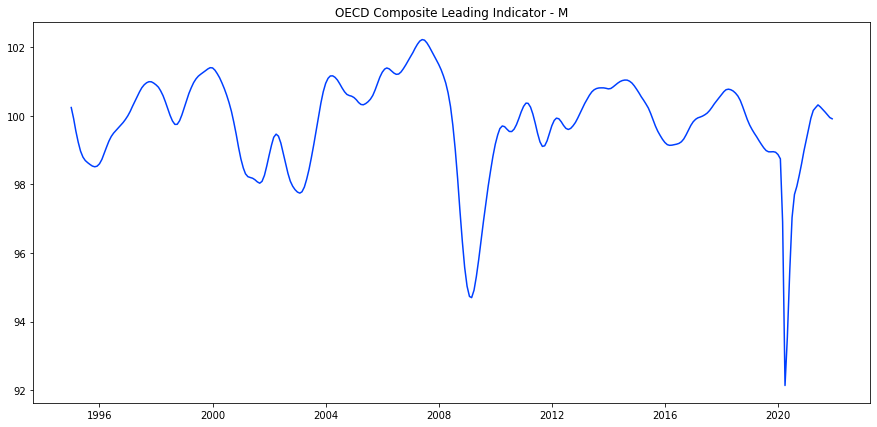

In [31]:
#Download data for OECD Composite Leading Indicator
oecd_cli = fetch_series('OECD/MEI_CLI/LOLITOAA.USA.M')
oecd_cli = clean_data(oecd_cli, 'OECD CLI')

#Plot data for OECD Composite Leading Indicator
plt.figure(figsize=(15,7))
plt.plot(oecd_cli)
plt.title('OECD Composite Leading Indicator - M')
plt.show()

The composite leading indicator (CLI) is designed to provide early signals of turning points in business cycles showing fluctuation of the economic activity around its long term potential level. CLIs show short-term economic movements in qualitative rather than quantitative terms.

# Section 3: Aggregate Demand Analysis

In this section we are going to analyze the components of aggregate demand to understand from where the positive or negative growth is coming from. We will also look in more detail at the components of the private consumption.

In [32]:
#Let's fetch Aggregate Demand components data and store them in a dataframe
agg_dem_list = ['OECD/QNA/USA.P31S14_S15.LNBARSA.Q',
                'OECD/QNA/USA.P3S13.LNBARSA.Q',
                'OECD/QNA/USA.P51.LNBARSA.Q',
                'OECD/QNA/USA.P52.LNBARSA.Q',
                'OECD/QNA/USA.P6.LNBARSA.Q',
                'OECD/QNA/USA.P7.LNBARSA.Q',
                'OECD/QNA/USA.RB1_GE.LNBARSA.Q']



agg_dem = pd.DataFrame()

for i in agg_dem_list:
    agg_dem = agg_dem.append(fetch_series(i)[['period', 'series_name', 'value']])
    

agg_dem = agg_dem.pivot(index='period', columns='series_name', values='value')
agg_dem['real_gdp'] = real_gdp['Real GDP']
agg_dem.tail()

series_name  United States – Changes in inventories – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                       
2020-10-01                                             88799.0                                                                                                               
2021-01-01                                            -88279.0                                                                                                               
2021-04-01                                           -168512.0                                                                                                               
2021-07-01                                            -66771.0                                                                                                               
2021-10-01                                            173546.0                                                                                                               

series_name  United States – Exports of goods and services – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                              
2020-10-01                                           2279025.0                                                                                                                      
2021-01-01                                           2262347.0                                                                                                                      
2021-04-01                                           2304164.0                                                                                                                      
2021-07-01                                           2273040.0                                                                                                                      
2021-10-01                                           2400908.0                                                                                                                      

series_name  United States – General government final consumption expenditure – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                                                 
2020-10-01                                           2657448.0                                                                                                                                         
2021-01-01                                           2704066.0                                                                                                                                         
2021-04-01                                           2696357.0                                                                                                                                         
2021-07-01                                           2701785.0                                                                                                                                         
2021-10-01                                           2682295.0                                                                                                                                         

series_name  United States – Gross fixed capital formation – National currency, chained volume estimates, nation

In [33]:
#Rename columns
col_names = ['Change in Inventories - Q', 'Exports - Q', 'Government Consumption - Q', 'Gross Fixed Capital Formation - Q', 'Imports - Q', 'Private Consumption - Q', 'Residual Item - Q', 'Real GDP']

agg_dem.columns = col_names
agg_dem.tail()

Change in Inventories - Q  Exports - Q  \
period                                               
2020-10-01                    88799.0    2279025.0   
2021-01-01                   -88279.0    2262347.0   
2021-04-01                  -168512.0    2304164.0   
2021-07-01                   -66771.0    2273040.0   
2021-10-01                   173546.0    2400908.0   

            Government Consumption - Q  Gross Fixed Capital Formation - Q  \
period                                                                      
2020-10-01                   2657448.0                          4156201.0   
2021-01-01                   2704066.0                          4250973.0   
2021-04-01                   2696357.0                          4269981.0   
2021-07-01                   2701785.0                          4264536.0   
2021-10-01                   2682295.0                          4270559.0   

            Imports - Q  Private Consumption - Q  Residual Item - Q  \
period                                                                
2020-10-01    3411843.0               12927913.0            70235.0   
2021-01-01    3488445.0               13282685.0           132308.0   
2021-04-01    3548699.0               13665610.0           149409.0   
2021-07-01    3589592.0               13732408.0           163487.0   
2021-10-01    3738886.0               13842662.0           174878.0   

              Real GDP  
period                  
2020-10-01  18767778.0  
2021-01-01  19055655.0  
2021-04-01  19368310.0  
2021-07-01  19478893.0  
2021-10-01  19805962.0

In [34]:
#Calculate Net Exports
agg_dem['Net Exports - Q'] = agg_dem['Exports - Q'] - agg_dem['Imports - Q']
agg_dem.tail()

Change in Inventories - Q  Exports - Q  \
period                                               
2020-10-01                    88799.0    2279025.0   
2021-01-01                   -88279.0    2262347.0   
2021-04-01                  -168512.0    2304164.0   
2021-07-01                   -66771.0    2273040.0   
2021-10-01                   173546.0    2400908.0   

            Government Consumption - Q  Gross Fixed Capital Formation - Q  \
period                                                                      
2020-10-01                   2657448.0                          4156201.0   
2021-01-01                   2704066.0                          4250973.0   
2021-04-01                   2696357.0                          4269981.0   
2021-07-01                   2701785.0                          4264536.0   
2021-10-01                   2682295.0                          4270559.0   

            Imports - Q  Private Consumption - Q  Residual Item - Q  \
period                                                                
2020-10-01    3411843.0               12927913.0            70235.0   
2021-01-01    3488445.0               13282685.0           132308.0   
2021-04-01    3548699.0               13665610.0           149409.0   
2021-07-01    3589592.0               13732408.0           163487.0   
2021-10-01    3738886.0               13842662.0           174878.0   

              Real GDP  Net Exports - Q  
period                                   
2020-10-01  18767778.0       -1132818.0  
2021-01-01  19055655.0       -1226098.0  
2021-04-01  19368310.0       -1244535.0  
2021-07-01  19478893.0       -1316552.0  
2021-10-01  19805962.0       -1337978.0

In [35]:
#Calculate aggregate demand components as a percentage of GDP
agg_dem_pct = pd.DataFrame()
agg_dem_pct['Private Consumption - %GDP'] = agg_dem['Private Consumption - Q'] / agg_dem['Real GDP']
agg_dem_pct['Government Consumption - %GDP'] = agg_dem['Government Consumption - Q'] / agg_dem['Real GDP']
agg_dem_pct['Gross Fixed Capital Formation - Q - %GDP'] = agg_dem['Gross Fixed Capital Formation - Q'] / agg_dem['Real GDP']
agg_dem_pct['Change in Inventories - %GDP'] = agg_dem['Change in Inventories - Q'] / agg_dem['Real GDP']
agg_dem_pct['Net Exports - %GDP'] = agg_dem['Net Exports - Q'] / agg_dem['Real GDP']
agg_dem_pct['Residual Item - %GDP'] = agg_dem['Residual Item - Q'] / agg_dem['Real GDP']
agg_dem_pct.tail()

Private Consumption - %GDP  Government Consumption - %GDP  \
period                                                                  
2020-10-01                    0.688836                       0.141596   
2021-01-01                    0.697047                       0.141904   
2021-04-01                    0.705565                       0.139215   
2021-07-01                    0.704989                       0.138703   
2021-10-01                    0.698914                       0.135429   

            Gross Fixed Capital Formation - Q - %GDP  \
period                                                 
2020-10-01                                  0.221454   
2021-01-01                                  0.223082   
2021-04-01                                  0.220462   
2021-07-01                                  0.218931   
2021-10-01                                  0.215620   

            Change in Inventories - %GDP  Net Exports - %GDP  \
period                                                         
2020-10-01                      0.004731           -0.060360   
2021-01-01                     -0.004633           -0.064343   
2021-04-01                     -0.008700           -0.064256   
2021-07-01                     -0.003428           -0.067589   
2021-10-01                      0.008762           -0.067554   

            Residual Item - %GDP  
period                            
2020-10-01              0.003742  
2021-01-01              0.006943  
2021-04-01              0.007714  
2021-07-01              0.008393  
2021-10-01              0.008830

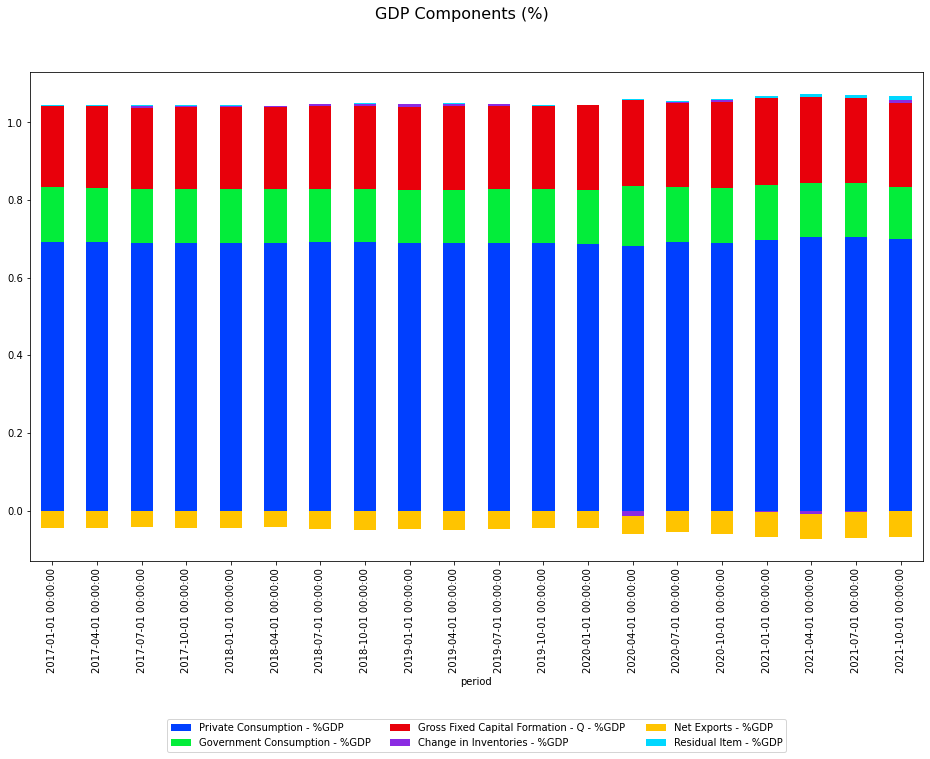

In [146]:
#Plot the components of AD in a stacked barchart
ax = agg_dem_pct.iloc[-20:].plot.bar(stacked=True, figsize=(16,9))
ax = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol= 3)
plt.suptitle('GDP Components (%)', size=16)
plt.show()

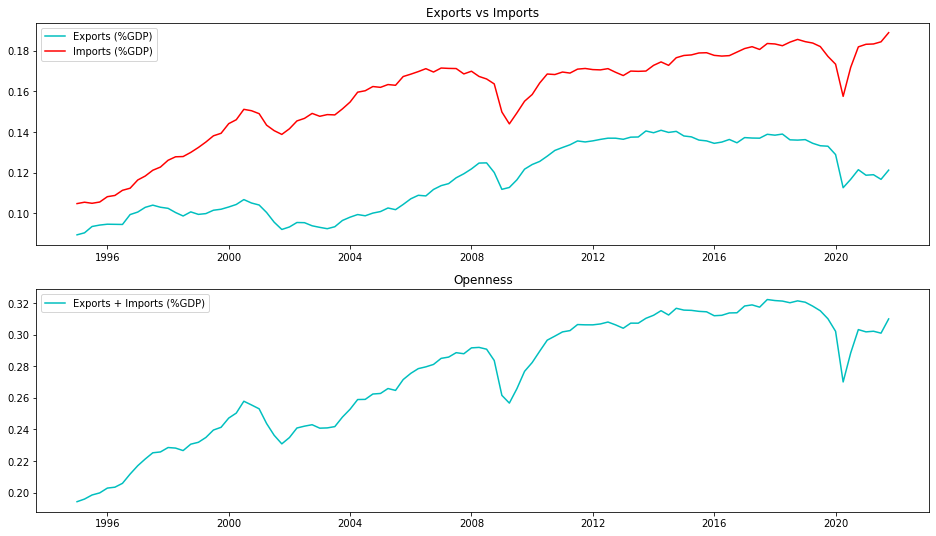

In [37]:
#Plot the Exports and Imports time series and the "Openness" of the economy as the sum of the two previous items
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot((agg_dem['Exports - Q'] / agg_dem['Real GDP']), color='c')
plt.plot((agg_dem['Imports - Q'] / agg_dem['Real GDP']), color='r')
plt.title('Exports vs Imports')
plt.legend(['Exports (%GDP)', 'Imports (%GDP)'])
plt.subplot(212)
plt.plot((((agg_dem['Exports - Q'] / agg_dem['Real GDP']) + (agg_dem['Imports - Q'] / agg_dem['Real GDP']))), color='c')
plt.title('Openness')
plt.legend(['Exports + Imports (%GDP)'], loc='upper left')
plt.show()

In [38]:
#Calculate how each component of AD contributed to GDP growth
growth_contr = pd.DataFrame()
growth_contr['GDP Growth (YoY)'] = agg_dem['Real GDP'].pct_change(4)
growth_contr['Priv. Cons. Contr.'] = agg_dem['Private Consumption - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Gov. Cons. Contr.'] = agg_dem['Government Consumption - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['GFCF Contr.'] = agg_dem['Gross Fixed Capital Formation - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Chg. Inv. Contr.'] = agg_dem['Change in Inventories - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Net Exp. Contr.'] = agg_dem['Net Exports - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Res. Item Contr.'] = agg_dem['Residual Item - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr = growth_contr.dropna()
growth_contr.head()

GDP Growth (YoY)  Priv. Cons. Contr.  Gov. Cons. Contr.  \
period                                                                
2003-01-01          0.016762            0.015322           0.002842   
2003-04-01          0.019570            0.019684           0.003430   
2003-07-01          0.032399            0.024670           0.002602   
2003-10-01          0.042951            0.025700           0.002827   
2004-01-01          0.043534            0.028773           0.003698   

            GFCF Contr.  Chg. Inv. Contr.  Net Exp. Contr.  Res. Item Contr.  
period                                                                        
2003-01-01     0.001848          0.003559        -0.007243          0.000434  
2003-04-01     0.005837         -0.003142        -0.007253          0.001014  
2003-07-01     0.011781         -0.001911        -0.005481          0.000739  
2003-10-01     0.015240          0.000205        -0.001964          0.000943  
2004-01-01     0.013137          0.001385        -0.004448          0.000989

In [39]:
#The following dataframe is identical to the above one, but with the "period" index set as a column instead of as the index. This is done simply to plot it below in a combined chart
df_to_plot = growth_contr.reset_index()
df_to_plot.tail()

period  GDP Growth (YoY)  Priv. Cons. Contr.  Gov. Cons. Contr.  \
71 2020-10-01         -0.022629           -0.016720           0.000734   
72 2021-01-01          0.005470            0.014151           0.002375   
73 2021-04-01          0.122267            0.110626           0.000386   
74 2021-07-01          0.049466            0.049116           0.001694   
75 2021-10-01          0.055317            0.048740           0.001324   

    GFCF Contr.  Chg. Inv. Contr.  Net Exp. Contr.  Res. Item Contr.  
71     0.002244          0.003774        -0.014855          0.002194  
72     0.007564         -0.003056        -0.020273          0.004709  
73     0.026484          0.004882        -0.027219          0.007108  
74     0.013739         -0.004961        -0.015909          0.005787  
75     0.006093          0.004516        -0.010932          0.005576

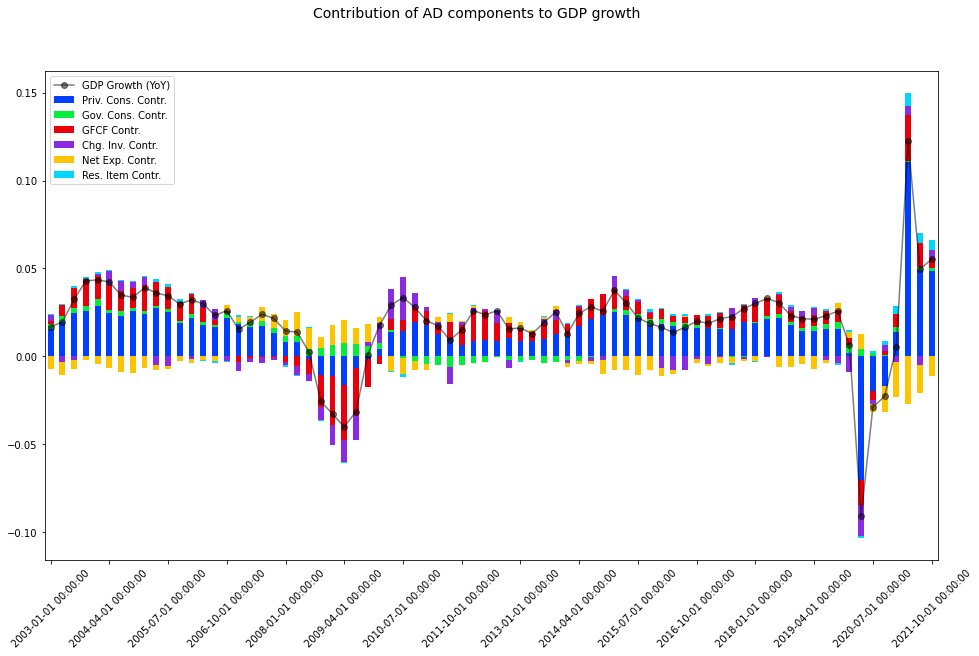

In [158]:
#Plot the contribution of AD components in a stacked chart together with the evolution of GDP growth
fig, ax1 = plt.subplots(figsize = (16, 9))

df_to_plot[['Priv. Cons. Contr.', 
              'Gov. Cons. Contr.', 
              'GFCF Contr.', 
              'Chg. Inv. Contr.', 
              'Net Exp. Contr.', 
              'Res. Item Contr.']].\
         plot(kind = 'bar', stacked = True, ax = ax1)

df_to_plot['GDP Growth (YoY)'].plot(linestyle='-', marker='o', color='black', alpha=0.5, ax = ax1, legend=True)

leg = plt.legend(loc='upper left')

ax1.set_xticklabels(labels = df_to_plot['period'],rotation = 45)
ax1.set_xticks(np.arange(0, len(df_to_plot)+1, 5))
plt.suptitle('Contribution of AD components to GDP growth', fontsize=14)
plt.show()

In [41]:
#Fetch data for Private Consumption analysis and store them in a DataFrame
priv_cons_list = ['OECD/QNA/USA.P311B.LNBARSA.Q',
                'OECD/QNA/USA.P313B.LNBARSA.Q',
                'OECD/QNA/USA.P314B.LNBARSA.Q',
                'OECD/QNA/USA.RP31DC.LNBARSA.Q']



priv_cons_comp = pd.DataFrame()

for i in priv_cons_list:
    priv_cons_comp = priv_cons_comp.append(fetch_series(i)[['period', 'series_name', 'value']])
    

priv_cons_comp = priv_cons_comp.pivot(index='period', columns='series_name', values='value')
priv_cons_comp['real_gdp'] = real_gdp['Real GDP']
priv_cons_comp.tail()

series_name  United States – Durable goods – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                              
2020-10-01                                           2036414.0                                                                                                      
2021-01-01                                           2253523.0                                                                                                      
2021-04-01                                           2316247.0                                                                                                      
2021-07-01                                           2158549.0                                                                                                      
2021-10-01                                           2167074.0                                                                                                      

series_name  United States – Non-durable goods – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                  
2020-10-01                                           3151050.0                                                                                                          
2021-01-01                                           3269314.0                                                                                                          
2021-04-01                                           3377231.0                                                                                                          
2021-07-01                                           3394040.0                                                                                                          
2021-10-01                                           3392930.0                                                                                                          

series_name  United States – Residual item (RP31DC) – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                       
2020-10-01                                           -176537.0                                                                                                               
2021-01-01                                           -233590.0                                                                                                               
2021-04-01                                           -242123.0                                                                                                               
2021-07-01                                           -198709.0                                                                                                               
2021-10-01                                           -193335.0                                                                                                               

series_name  United States – Services (P314B) – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                 
2020-10-01                                           7916986.0                                           

In [42]:
#Rename columns
col_names = ['Durable Goods - Q', 'Non-Durable Goods - Q', 'Other - Q', 'Services - Q', 'Real GDP']

priv_cons_comp.columns = col_names
priv_cons_comp.tail()

Durable Goods - Q  Non-Durable Goods - Q  Other - Q  Services - Q  \
period                                                                          
2020-10-01          2036414.0              3151050.0  -176537.0     7916986.0   
2021-01-01          2253523.0              3269314.0  -233590.0     7993438.0   
2021-04-01          2316247.0              3377231.0  -242123.0     8214255.0   
2021-07-01          2158549.0              3394040.0  -198709.0     8378528.0   
2021-10-01          2167074.0              3392930.0  -193335.0     8475993.0   

              Real GDP  
period                  
2020-10-01  18767778.0  
2021-01-01  19055655.0  
2021-04-01  19368310.0  
2021-07-01  19478893.0  
2021-10-01  19805962.0

In [43]:
#Calculate the Y-o-Y growth of the components of Private Consumption
priv_cons_comp_gth = pd.DataFrame()
priv_cons_comp_gth['Durable Goods - %YoY'] = (priv_cons_comp['Durable Goods - Q'] / priv_cons_comp['Durable Goods - Q'].shift(4)) - 1
priv_cons_comp_gth['Non-Durable Goods - %YoY'] = (priv_cons_comp['Non-Durable Goods - Q'] / priv_cons_comp['Non-Durable Goods - Q'].shift(4)) - 1
priv_cons_comp_gth['Services - %YoY'] = (priv_cons_comp['Services - Q'] / priv_cons_comp['Services - Q'].shift(4)) - 1
priv_cons_comp_gth['Other - %YoY'] = (priv_cons_comp['Other - Q'] / priv_cons_comp['Other - Q'].shift(4)) - 1
priv_cons_comp_gth = priv_cons_comp_gth.dropna() 
priv_cons_comp_gth.head()

Durable Goods - %YoY  Non-Durable Goods - %YoY  Services - %YoY  \
period                                                                        
2003-01-01              0.027943                  0.022567         0.021530   
2003-04-01              0.067929                  0.030053         0.021058   
2003-07-01              0.082716                  0.047321         0.023651   
2003-10-01              0.108472                  0.040861         0.022987   
2004-01-01              0.126788                  0.040435         0.026786   

            Other - %YoY  
period                    
2003-01-01     -0.057556  
2003-04-01     -0.365933  
2003-07-01     -0.503023  
2003-10-01     -0.660161  
2004-01-01     -0.738910

In [44]:
#Calculate the contribution to GDP growth of each component of Private Consumption
priv_cons_comp_contr = pd.DataFrame()
priv_cons_comp_contr['GDP Growth (YoY)'] = priv_cons_comp['Real GDP'].pct_change(4)
priv_cons_comp_contr['Dur. Goods Contr.'] = priv_cons_comp['Durable Goods - Q'].diff(4) / priv_cons_comp['Real GDP'].shift(4)
priv_cons_comp_contr['Non-Dur. Goods Contr.'] = priv_cons_comp['Non-Durable Goods - Q'].diff(4) / priv_cons_comp['Real GDP'].shift(4)
priv_cons_comp_contr['Services Contr.'] = priv_cons_comp['Services - Q'].diff(4) / priv_cons_comp['Real GDP'].shift(4)
priv_cons_comp_contr['Other Contr.'] = priv_cons_comp['Other - Q'].diff(4) / priv_cons_comp['Real GDP'].shift(4)
priv_cons_comp_contr = priv_cons_comp_contr.dropna()
priv_cons_comp_contr.head()

GDP Growth (YoY)  Dur. Goods Contr.  Non-Dur. Goods Contr.  \
period                                                                   
2003-01-01          0.016762           0.001682               0.003619   
2003-04-01          0.019570           0.004088               0.004794   
2003-07-01          0.032399           0.005107               0.007530   
2003-10-01          0.042951           0.006628               0.006571   
2004-01-01          0.043534           0.007714               0.006522   

            Services Contr.  Other Contr.  
period                                     
2003-01-01         0.009832      0.000189  
2003-04-01         0.009618      0.001183  
2003-07-01         0.010803      0.001230  
2003-10-01         0.010553      0.001947  
2004-01-01         0.012290      0.002247

In [45]:
#The following dataframe is identical to the above one, but with the "period" index set as a column instead of as the index. This is done simply to plot it below in a combined chart
df_to_plot_1 = priv_cons_comp_contr.reset_index()
df_to_plot_1.head()

period  GDP Growth (YoY)  Dur. Goods Contr.  Non-Dur. Goods Contr.  \
0 2003-01-01          0.016762           0.001682               0.003619   
1 2003-04-01          0.019570           0.004088               0.004794   
2 2003-07-01          0.032399           0.005107               0.007530   
3 2003-10-01          0.042951           0.006628               0.006571   
4 2004-01-01          0.043534           0.007714               0.006522   

   Services Contr.  Other Contr.  
0         0.009832      0.000189  
1         0.009618      0.001183  
2         0.010803      0.001230  
3         0.010553      0.001947  
4         0.012290      0.002247

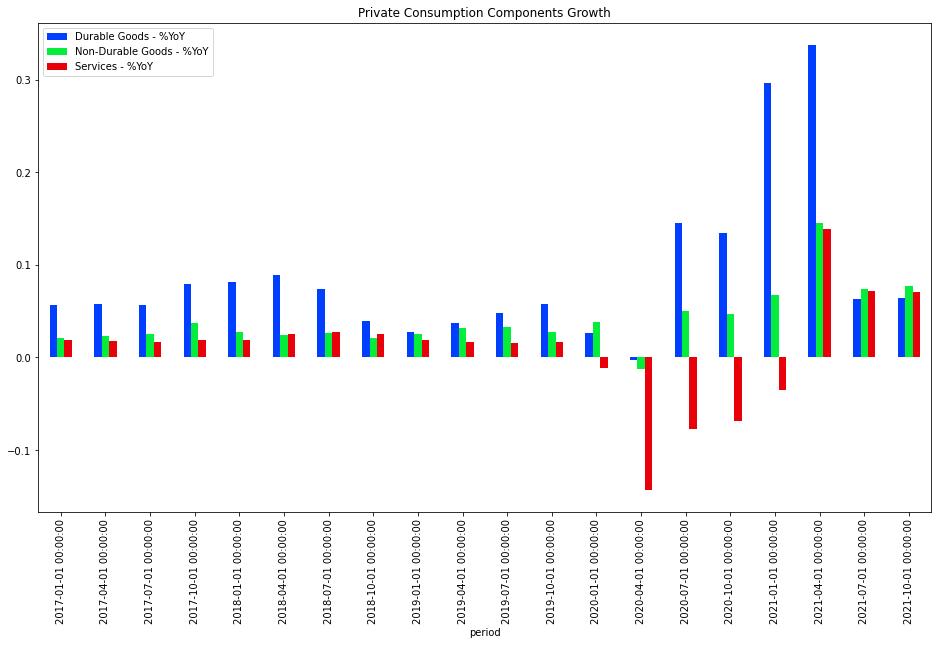

In [46]:
#Plot the Y-o-Y growth of main Private Consumption components
priv_cons_comp_gth[['Durable Goods - %YoY',
                    'Non-Durable Goods - %YoY',
                    'Services - %YoY']].\
                    iloc[-20:].plot(kind = 'bar', figsize=(16,9))
plt.title('Private Consumption Components Growth')
plt.show()

In [47]:
priv_cons_comp_gth.tail()

Durable Goods - %YoY  Non-Durable Goods - %YoY  Services - %YoY  \
period                                                                        
2020-10-01              0.134707                  0.046839        -0.069236   
2021-01-01              0.296372                  0.067773        -0.035127   
2021-04-01              0.337504                  0.145163         0.138129   
2021-07-01              0.063011                  0.074101         0.072084   
2021-10-01              0.064162                  0.076762         0.070609   

            Other - %YoY  
period                    
2020-10-01      1.864094  
2021-01-01      2.332525  
2021-04-01      0.707135  
2021-07-01      0.074817  
2021-10-01      0.095153

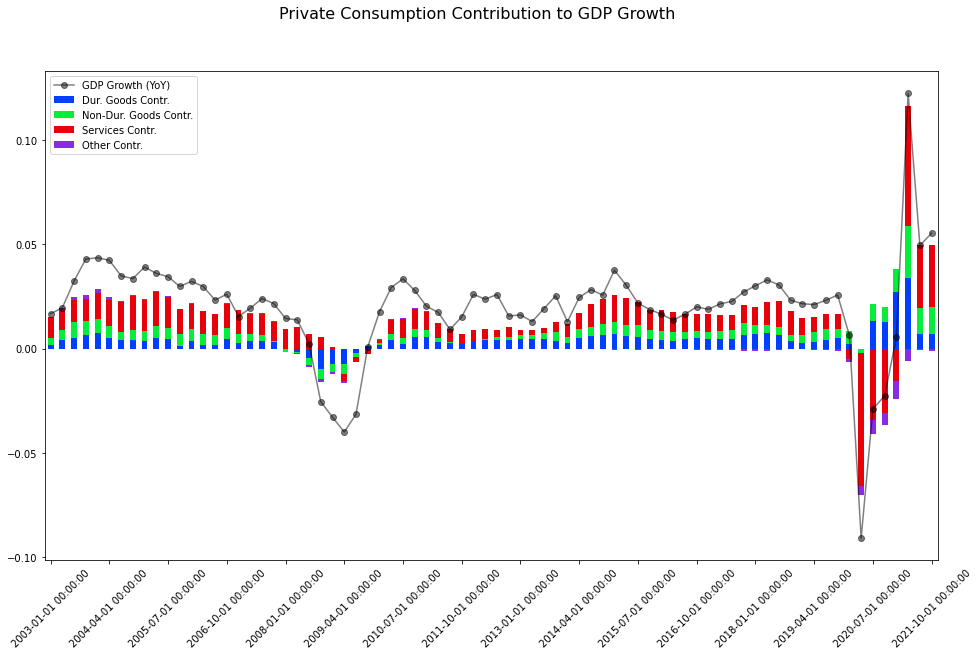

In [163]:
#Plot the contribution of Private Consumption main components to GDP growth and output evolution
fig, ax1 = plt.subplots(figsize = (16, 9))

df_to_plot_1[['Dur. Goods Contr.', 
              'Non-Dur. Goods Contr.', 
              'Services Contr.',
              'Other Contr.']].\
         plot(kind = 'bar', stacked = True, ax = ax1)
df_to_plot_1['GDP Growth (YoY)'].plot(linestyle='-', marker='o', color='black', alpha=0.5, ax = ax1, legend=True)
leg = plt.legend(loc='upper left')
ax1.set_xticklabels(labels = df_to_plot_1['period'], rotation=45)
ax1.set_xticks(np.arange(0, len(df_to_plot_1)+1, 5))

plt.suptitle('Private Consumption Contribution to GDP Growth', size =16)
plt.show()

In [49]:
priv_cons_comp_contr.tail()

GDP Growth (YoY)  Dur. Goods Contr.  Non-Dur. Goods Contr.  \
period                                                                   
2020-10-01         -0.022629           0.012590               0.007342   
2021-01-01          0.005470           0.027184               0.010949   
2021-04-01          0.122267           0.033867               0.024806   
2021-07-01          0.049466           0.006894               0.012615   
2021-10-01          0.055317           0.006962               0.012888   

            Services Contr.  Other Contr.  
period                                     
2020-10-01        -0.030669     -0.005984  
2021-01-01        -0.015355     -0.008627  
2021-04-01         0.057765     -0.005811  
2021-07-01         0.030352     -0.000745  
2021-10-01         0.029785     -0.000895

In [50]:
#Fetch Private Investments series for GFCF analysis
priv_inv = fetch_series('OECD/QNA/USA.P51S1LESSS13.LNBARSA.Q')
priv_inv = clean_data(priv_inv, 'Private Investments - Q')
priv_inv.head()

Private Investments - Q
period                             
1999-01-01                2076866.0
1999-04-01                2126293.0
1999-07-01                2175841.0
1999-10-01                2187170.0
2000-01-01                2249784.0

In [51]:
#Fetch Government Investments series for GFCF analysis
gov_inv = fetch_series('OECD/QNA/USA.P51S13.LNBARSA.Q')
gov_inv = clean_data(gov_inv, 'Government Investments - Q')
gov_inv.head()

Government Investments - Q
period                                
2002-01-01                    575670.0
2002-04-01                    578995.0
2002-07-01                    588719.0
2002-10-01                    597639.0
2003-01-01                    597614.0

In [52]:
#Merge Real GDP data with components of GFCF
gfcf_comp = pd.concat([real_gdp['Real GDP'], priv_inv, gov_inv], axis=1)
gfcf_comp = gfcf_comp.dropna()
gfcf_comp.head()

Real GDP  Private Investments - Q  Government Investments - Q
period                                                                     
2002-01-01  13394910.0                2189057.0                    575670.0
2002-04-01  13477356.0                2186656.0                    578995.0
2002-07-01  13531741.0                2183461.0                    588719.0
2002-10-01  13549421.0                2174296.0                    597639.0
2003-01-01  13619434.0                2194030.0                    597614.0

In [53]:
#Calculate contribution of GFCF components to GDP growth
gfcf_comp_contr = pd.DataFrame()
gfcf_comp_contr['GDP Growth (YoY)'] = gfcf_comp['Real GDP'].pct_change(4)
gfcf_comp_contr['Private Investments Contr.'] = gfcf_comp['Private Investments - Q'].diff(4) / gfcf_comp['Real GDP'].shift(4)
gfcf_comp_contr['Government Investments Contr.'] = gfcf_comp['Government Investments - Q'].diff(4) / gfcf_comp['Real GDP'].shift(4)
gfcf_comp_contr = gfcf_comp_contr.dropna()
gfcf_comp_contr.head()

GDP Growth (YoY)  Private Investments Contr.  \
period                                                     
2003-01-01          0.016762                    0.000371   
2003-04-01          0.019570                    0.004461   
2003-07-01          0.032399                    0.010070   
2003-10-01          0.042951                    0.013843   
2004-01-01          0.043534                    0.011850   

            Government Investments Contr.  
period                                     
2003-01-01                       0.001638  
2003-04-01                       0.001395  
2003-07-01                       0.001589  
2003-10-01                       0.001119  
2004-01-01                       0.001063

In [54]:
#The following dataframe is identical to the above one, but with the "period" index set as a column instead of as the index. This is done simply to plot it below in a combined chart
df_to_plot_2 = gfcf_comp_contr.reset_index()
df_to_plot_2.head()

period  GDP Growth (YoY)  Private Investments Contr.  \
0 2003-01-01          0.016762                    0.000371   
1 2003-04-01          0.019570                    0.004461   
2 2003-07-01          0.032399                    0.010070   
3 2003-10-01          0.042951                    0.013843   
4 2004-01-01          0.043534                    0.011850   

   Government Investments Contr.  
0                       0.001638  
1                       0.001395  
2                       0.001589  
3                       0.001119  
4                       0.001063

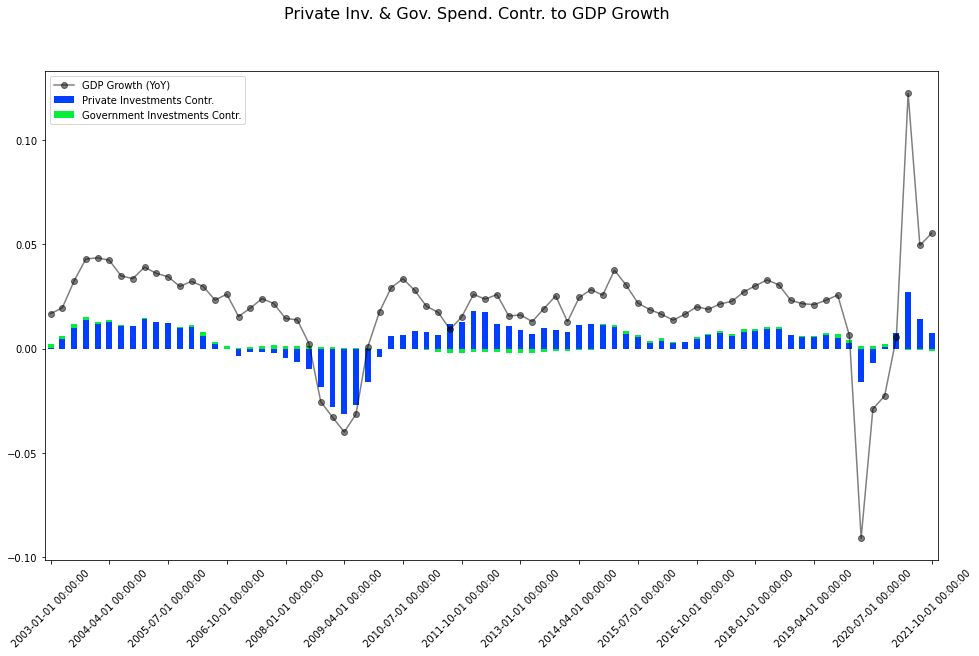

In [165]:
#Plot the contribution of GFCF components to GDP growth and output evolution
fig, ax1 = plt.subplots(figsize = (16, 9))

df_to_plot_2[['Private Investments Contr.', 
              'Government Investments Contr.']].\
         plot(kind = 'bar', stacked = True, ax = ax1)
df_to_plot_2['GDP Growth (YoY)'].plot(linestyle='-', marker='o', color='black', alpha=0.5, ax = ax1, legend=True)
leg = plt.legend(loc='upper left')
ax1.set_xticklabels(labels = df_to_plot_2['period'], rotation=45)
ax1.set_xticks(np.arange(0, len(df_to_plot_2)+1, 5))

plt.suptitle('Private Inv. & Gov. Spend. Contr. to GDP Growth', size=16)
plt.show()

In [56]:
#Let's retrieve data on retail sales from the economic calendar
ret_sales_mom = eco_cal_data_pct(event='Retail Sales (MoM)')
core_ret_sales_mom = eco_cal_data_pct(event='Core Retail Sales (MoM)')

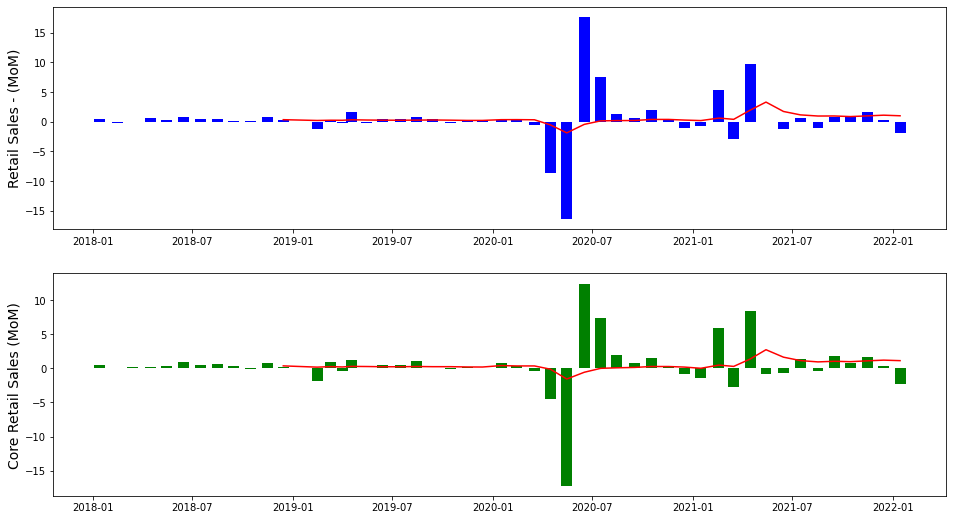

In [57]:
#Let's plot retail sales data
fig, axs = plt.subplots(2, 1, figsize=(16, 9))
axs[0].bar(ret_sales_mom.index, ret_sales_mom['Retail Sales (MoM)'], width=20, color='b')
axs[0].plot(ret_sales_mom['Retail Sales (MoM)'].rolling(12).mean(), color='r')
axs[0].set_ylabel('Retail Sales - (MoM)', fontsize=14)
axs[1].bar(core_ret_sales_mom.index, core_ret_sales_mom['Core Retail Sales (MoM)'], width=20, color='g')
axs[1].plot(core_ret_sales_mom['Core Retail Sales (MoM)'].rolling(12).mean(), color='r')
axs[1].set_ylabel('Core Retail Sales (MoM)', fontsize=14)

plt.show()

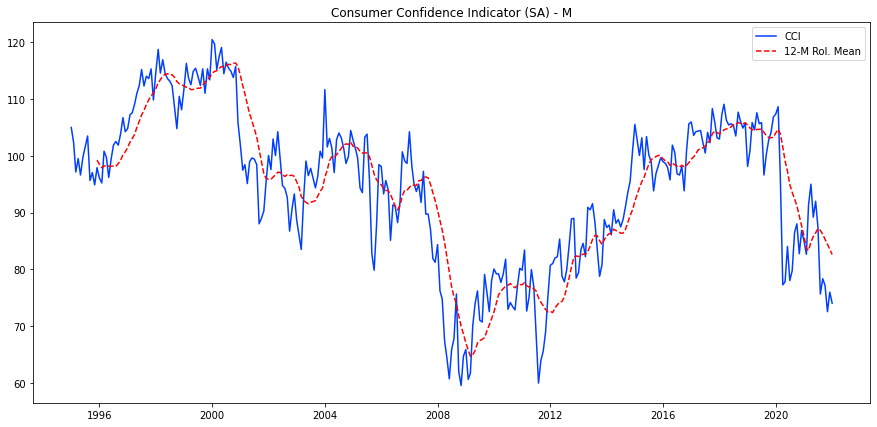

In [58]:
#Fetch Consumer Confidence Indicator data
cci = fetch_series('OECD/KEI/CSCICP02.USA.ST.M')
cci = clean_data(cci, 'Consumer Confidence Indicator (SA) - M')

#Plot Consumer Confidence Indicator data
plt.figure(figsize=(15,7))
plt.plot(cci)
plt.plot(cci.rolling(12).mean(), color='r', linestyle='--')
plt.title('Consumer Confidence Indicator (SA) - M')
plt.legend(['CCI', '12-M Rol. Mean'])
plt.show()

In [59]:
cci.tail()

Consumer Confidence Indicator (SA) - M
period                                            
2021-09-01                               78.328701
2021-10-01                               77.145163
2021-11-01                               72.518605
2021-12-01                               75.961625
2022-01-01                               74.024926

# Section 4: Inflation Analysis

In this section our goal is to assess actual and expected inflation pressures from different perspectives. In fact, after analyzing different measures of inflations (CPI vs GDP Deflator), we will have a look at 10-year forward expectations (based on the 5y, 5y Fwd Inflation Expectation indicator) and then going deeper on inflation components performances. Then we will have a look at headline versus less volatile core inflation and, finally, we will assess wages and salaries trends, as well as base metals movements.  

In [60]:
#Fetch monthly inflation rate (YoY chg) series
cpi_yoy_m = fetch_series('IMF/CPI/M.US.PCPI_PC_CP_A_PT')
cpi_yoy_m = clean_data(cpi_yoy_m, 'Inflation Rate YoY - (M)')
cpi_yoy_m['Target'] = 2
cpi_yoy_m.tail()

Inflation Rate YoY - (M)  Target
period                                      
2021-08-01                  5.251272       2
2021-09-01                  5.390349       2
2021-10-01                  6.221869       2
2021-11-01                  6.809003       2
2021-12-01                  7.036403       2

In [61]:
#Fetch monthly inflation rate (MoM chg) series
cpi_mom_m = fetch_series('IMF/CPI/M.US.PCPI_PC_PP_PT')
cpi_mom_m = clean_data(cpi_mom_m, 'Inflation Rate MoM - (M)')
cpi_mom_m['Rolling 12-M Avg'] = cpi_mom_m['Inflation Rate MoM - (M)'].rolling(12).mean() 
cpi_mom_m.tail()

Inflation Rate MoM - (M)  Rolling 12-M Avg
period                                                
2021-08-01                  0.206591          0.427942
2021-09-01                  0.271597          0.438969
2021-10-01                  0.830812          0.504746
2021-11-01                  0.491343          0.550780
2021-12-01                  0.307252          0.568538

In [62]:
#Fetch GDP deflator time series to compare an inflation indicator with a broader basket of goods and services, but that doesn't take into account imported inflation
gdp_defl = fetch_series('OECD/MEI/USA.NAGIGP01.IXOBSA.Q')
gdp_defl = clean_data(gdp_defl, 'GDP Deflator')
gdp_defl['GDP Deflator YoY - (Q)'] = gdp_defl['GDP Deflator'] / gdp_defl['GDP Deflator'].shift(4) - 1
gdp_defl['GDP Deflator QoQ - (Q)'] = gdp_defl['GDP Deflator'].pct_change()
gdp_defl = gdp_defl.dropna()
gdp_defl.tail()

GDP Deflator  GDP Deflator YoY - (Q)  GDP Deflator QoQ - (Q)
period                                                                  
2020-10-01    109.311207                0.012925                0.004831
2021-01-01    110.470064                0.020342                0.010601
2021-04-01    112.152486                0.040353                0.015230
2021-07-01    113.778301                0.045895                0.014496
2021-10-01    115.709441                0.058532                0.016973

In [63]:
#Fetch 5-Year, 5-Year Forward Inflation Expectation Rate to assess future path of inflation
five_y_fwd_i_exp = quandl.get("FRED/T5YIFR", authtoken=api_key)
five_y_fwd_i_exp = five_y_fwd_i_exp.rename(columns={'Value':'5-y, 5-y Fwd Infl. Exp.'})
five_y_fwd_i_exp.tail()

5-y, 5-y Fwd Infl. Exp.
Date                               
2022-01-24                     2.02
2022-01-25                     2.04
2022-01-26                     2.01
2022-01-27                     2.04
2022-01-28                     2.08

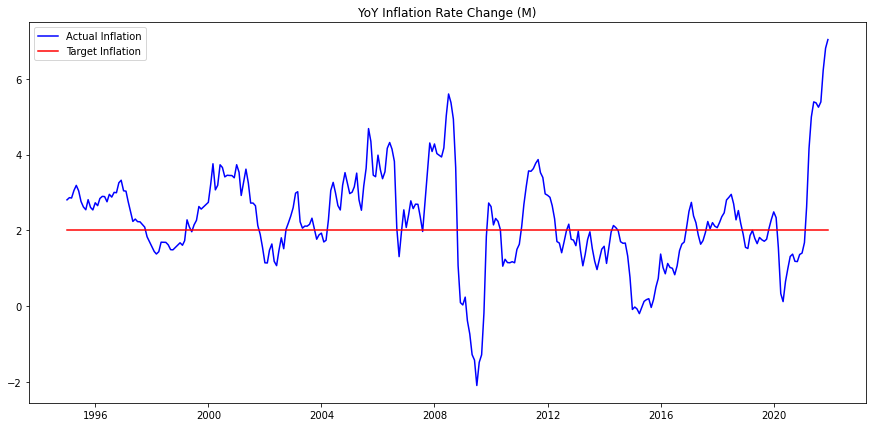

In [64]:
#Plot YoY monthly inflation change
plt.figure(figsize=(15,7))
plt.plot(cpi_yoy_m['Inflation Rate YoY - (M)'], color='blue')
plt.plot(cpi_yoy_m['Target'], color='red')
plt.legend(['Actual Inflation', 'Target Inflation'])
plt.title('YoY Inflation Rate Change (M)')
plt.show()

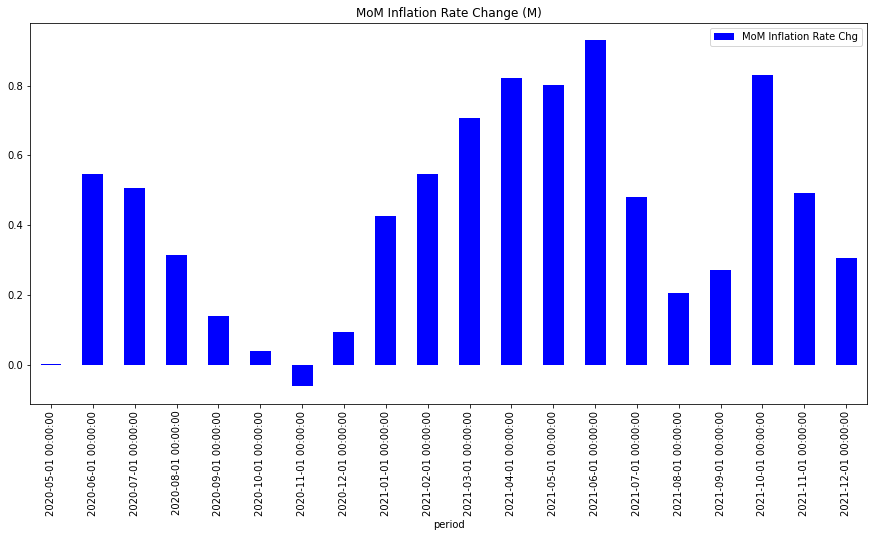

In [65]:
#Plot MoM monthly inflation change
cpi_mom_m['Inflation Rate MoM - (M)'].iloc[-20:].plot(kind='bar', color='blue', figsize=(15,7))
plt.legend(['MoM Inflation Rate Chg'])
plt.title('MoM Inflation Rate Change (M)')
plt.show()

In [176]:
#Loading the Global Supply Chain Pressure index data
gscpi = pd.read_excel('/Users/lucadonghi/Desktop/2022_Barometer-Global-Supply-Chain-Pressures_data (1).xlsx',
                      sheet_name='GSCPI',
                      parse_dates=True,
                      index_col=0,
                      skiprows=4)
gscpi = gscpi.iloc[: , :-2]
gscpi.columns = ['GSCPI']

gscpi.head()

GSCPI
1997-09-30 -0.491379
1997-10-31 -0.176291
1997-11-30 -0.459300
1997-12-31 -0.831952
1998-01-31 -0.939995

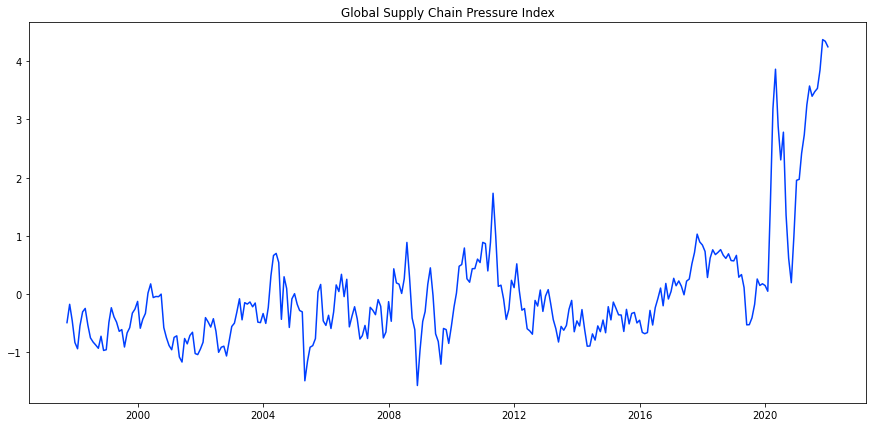

In [177]:
#Plotting the Global Supply Chain Pressure index data
plt.figure(figsize=(15,7))
plt.plot(gscpi)
plt.title('Global Supply Chain Pressure Index')
plt.show()

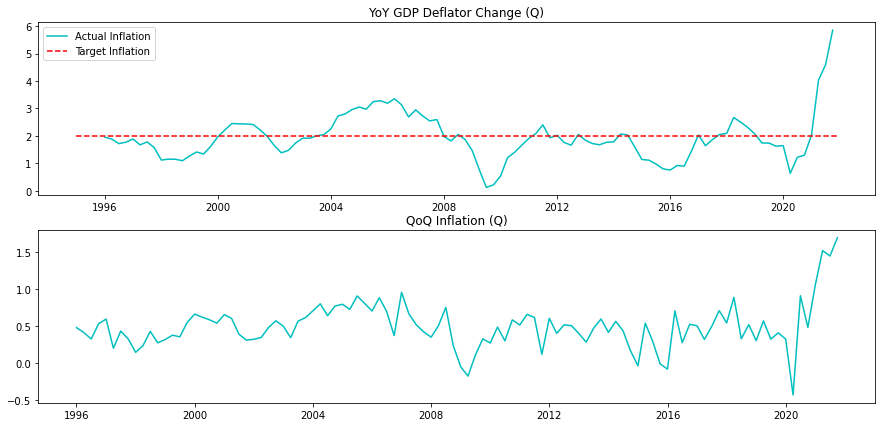

In [66]:
#Plot quarterly inflation rate (GDP deflator) on a YoY and QoQ base
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.plot((gdp_defl['GDP Deflator YoY - (Q)'] * 100), color='c')
plt.plot(cpi_yoy_m['Target'], color='red', linestyle='--')
plt.title('YoY GDP Deflator Change (Q)')
plt.legend(['Actual Inflation', 'Target Inflation'])
plt.subplot(212)
plt.plot((gdp_defl['GDP Deflator QoQ - (Q)'] * 100), color='c')
plt.title('QoQ Inflation (Q)')
plt.show()

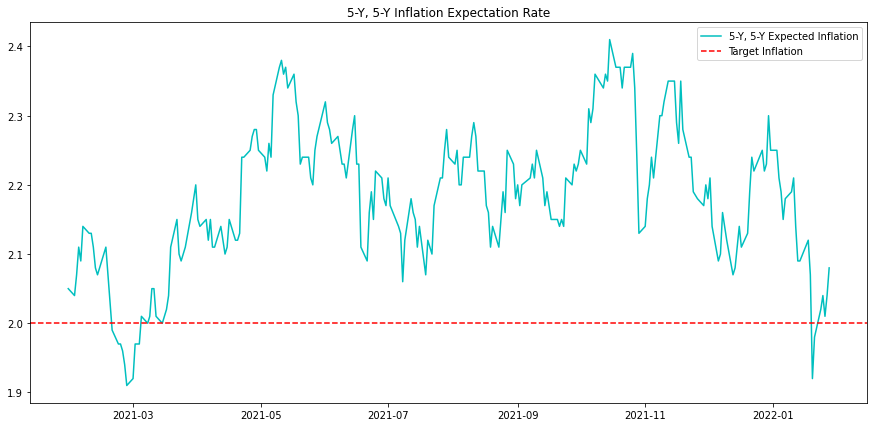

In [67]:
#Plot the measure of expected inflation (on average) over the five-year period that begins five years from today
plt.figure(figsize=(15,7))
plt.plot(five_y_fwd_i_exp[-252:], color='c')
plt.axhline(y=2, color='red', linestyle='--')
plt.title('5-Y, 5-Y Inflation Expectation Rate')
plt.legend(['5-Y, 5-Y Expected Inflation', 'Target Inflation'])
plt.show()

In [68]:
#Let's fetch CPI weights data and store them in a dataframe
w = ['IMF/CPI/M.US.PCPIA_WT_PT',
     'IMF/CPI/M.US.PCPIEC_WT_PT',
     'IMF/CPI/M.US.PCPIED_WT_PT',
     'IMF/CPI/M.US.PCPIFBT_WT_PT',
     'IMF/CPI/M.US.PCPIF_WT_PT',
     'IMF/CPI/M.US.PCPIHO_WT_PT',
     'IMF/CPI/M.US.PCPIH_WT_PT',
     'IMF/CPI/M.US.PCPIM_WT_PT',
     'IMF/CPI/M.US.PCPIO_WT_PT',
     'IMF/CPI/M.US.PCPIRE_WT_PT',
     'IMF/CPI/M.US.PCPIT_WT_PT',
     'IMF/CPI/M.US.PCPIR_WT_PT']



cpi_weights = pd.DataFrame()

for i in w:
    cpi_weights = cpi_weights.append(fetch_series(i)[['period', 'series_name', 'value']])
    

cpi_weights = cpi_weights.pivot(index='period', columns='series_name', values='value')
cpi_weights.head()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics, Weight, Percent  \
period                                                                                                
1998-01-01                                            1.516598                                        
1998-02-01                                            1.516598                                        
1998-03-01                                            1.516598                                        
1998-04-01                                            1.516598                                        
1998-05-01                                            1.516598                                        

series_name  Monthly – United States – Clothing and footwear, Weight, Percent  \
period                                                                          
1998-01-01                                            4.837151                  
1998-02-01                                            4.837151                  
1998-03-01                                            4.837151                  
1998-04-01                                            4.837151                  
1998-05-01                                            4.837151                  

series_name  Monthly – United States – Communication, Weight, Percent  \
period                                                                  
1998-01-01                                            2.635551          
1998-02-01                                            2.635551          
1998-03-01                                            2.635551          
1998-04-01                                            2.635551          
1998-05-01                                            2.635551          

series_name  Monthly – United States – Education, Weight, Percent  \
period                                                              
1998-01-01                                             2.34987      
1998-02-01                                             2.34987      
1998-03-01                                             2.34987      
1998-04-01                                             2.34987      
1998-05-01                                             2.34987      

series_name  Monthly – United States – Food and non-alcoholic beverages, Weight, Percent  \
period                                                                                     
1998-01-01                                            9.645973                             
1998-02-01                                            9.645973                             
1998-03-01                                            9.645973                             
1998-04-01                                            9.645973                             
1998-05-01                                            9.645973                             

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance, Weight, Percent  \
period                                                                                                                       
1998-01-01                                             4.04256                                                               
1998-02-01                                             4.04256                                                               
1998-03-01                                             4.04256                                                               
1998-04-01                                             4.04256                                                               
1998-05-01                                             4.04256                                                               

series_name  Monthly – United States – Health, Weight, Percent  \
period                                                           
1998-01-01                                            

In [69]:
#Check that time series downloaded are correct
for col_name in cpi_weights.columns: 
    print(col_name)

Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics, Weight, Percent
Monthly – United States – Clothing and footwear, Weight, Percent
Monthly – United States – Communication, Weight, Percent
Monthly – United States – Education, Weight, Percent
Monthly – United States – Food and non-alcoholic beverages, Weight, Percent
Monthly – United States – Furnishings, household equipment and routine household maintenance, Weight, Percent
Monthly – United States – Health, Weight, Percent
Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels, Weight, Percent
Monthly – United States – Miscellaneous goods and services, Weight, Percent
Monthly – United States – Recreation and culture, Weight, Percent
Monthly – United States – Restaurants and hotels, Weight, Percent
Monthly – United States – Transport, Weight, Percent


In [70]:
#Let's fetch CPI weights data and store them in a dataframe
ix = ['IMF/CPI/M.US.PCPIA_IX',
     'IMF/CPI/M.US.PCPIEC_IX',
     'IMF/CPI/M.US.PCPIED_IX',
     'IMF/CPI/M.US.PCPIFBT_IX',
     'IMF/CPI/M.US.PCPIF_IX',
     'IMF/CPI/M.US.PCPIHO_IX',
     'IMF/CPI/M.US.PCPIH_IX',
     'IMF/CPI/M.US.PCPIM_IX',
     'IMF/CPI/M.US.PCPIO_IX',
     'IMF/CPI/M.US.PCPIRE_IX',
     'IMF/CPI/M.US.PCPIT_IX',
     'IMF/CPI/M.US.PCPIR_IX']



cpi_indices = pd.DataFrame()

for i in ix:
    cpi_indices = cpi_indices.append(fetch_series(i)[['period', 'series_name', 'value']])
    

cpi_indices = cpi_indices.pivot(index='period', columns='series_name', values='value')
cpi_indices.head()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
1955-01-01                                                 NaN                       
1955-02-01                                                 NaN                       
1955-03-01                                                 NaN                       
1955-04-01                                                 NaN                       
1955-05-01                                                 NaN                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
1955-01-01                                               NaN   
1955-02-01                                               NaN   
1955-03-01                                               NaN   
1955-04-01                                               NaN   
1955-05-01                                               NaN   

series_name  Monthly – United States – Communication  \
period                                                 
1955-01-01                                       NaN   
1955-02-01                                       NaN   
1955-03-01                                       NaN   
1955-04-01                                       NaN   
1955-05-01                                       NaN   

series_name  Monthly – United States – Education  \
period                                             
1955-01-01                                   NaN   
1955-02-01                                   NaN   
1955-03-01                                   NaN   
1955-04-01                                   NaN   
1955-05-01                                   NaN   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
1955-01-01                                           13.621799            
1955-02-01                                           13.668135            
1955-03-01                                           13.668135            
1955-04-01                                           13.714470            
1955-05-01                                           13.714470            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
1955-01-01                                                 NaN                                              
1955-02-01                                                 NaN                                              
1955-03-01                                                 NaN                                              
1955-04-01                                                 NaN                                              
1955-05-01                                                 NaN                                              

series_name  Monthly – United States – Health  \
period                                          
1955-01-01                                NaN   
1955-02-01                                NaN   
1955-03-01                                NaN   
1955-04-01                                NaN   
1955-05-01                                NaN   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
1955-01-01                                                 NaN                            
1955-02-01                                                 NaN                            
1955-03-01                                                 NaN                            
1955-04-01                                                 NaN                            
1955-05-01

In [71]:
#Check that time series downloaded are correct
for col_name in cpi_indices.columns: 
    print(col_name)

Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics
Monthly – United States – Clothing and footwear
Monthly – United States – Communication
Monthly – United States – Education
Monthly – United States – Food and non-alcoholic beverages
Monthly – United States – Furnishings, household equipment and routine household maintenance
Monthly – United States – Health
Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels
Monthly – United States – Miscellaneous goods and services
Monthly – United States – Recreation and culture
Monthly – United States – Restaurants and hotels
Monthly – United States – Transport


In [72]:
#Rename columns in cpi_weights as in cpi_indices to allow elementwise multiplication later
cpi_weights.columns=cpi_indices.columns
cpi_weights.head()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
1998-01-01                                            1.516598                       
1998-02-01                                            1.516598                       
1998-03-01                                            1.516598                       
1998-04-01                                            1.516598                       
1998-05-01                                            1.516598                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
1998-01-01                                          4.837151   
1998-02-01                                          4.837151   
1998-03-01                                          4.837151   
1998-04-01                                          4.837151   
1998-05-01                                          4.837151   

series_name  Monthly – United States – Communication  \
period                                                 
1998-01-01                                  2.635551   
1998-02-01                                  2.635551   
1998-03-01                                  2.635551   
1998-04-01                                  2.635551   
1998-05-01                                  2.635551   

series_name  Monthly – United States – Education  \
period                                             
1998-01-01                               2.34987   
1998-02-01                               2.34987   
1998-03-01                               2.34987   
1998-04-01                               2.34987   
1998-05-01                               2.34987   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
1998-01-01                                            9.645973            
1998-02-01                                            9.645973            
1998-03-01                                            9.645973            
1998-04-01                                            9.645973            
1998-05-01                                            9.645973            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
1998-01-01                                             4.04256                                              
1998-02-01                                             4.04256                                              
1998-03-01                                             4.04256                                              
1998-04-01                                             4.04256                                              
1998-05-01                                             4.04256                                              

series_name  Monthly – United States – Health  \
period                                          
1998-01-01                           5.314087   
1998-02-01                           5.314087   
1998-03-01                           5.314087   
1998-04-01                           5.314087   
1998-05-01                           5.314087   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
1998-01-01                                            34.02705                            
1998-02-01                                            34.02705                            
1998-03-01                                            34.02705                            
1998-04-01                                            34.02705                            
1998-05-01

In [73]:
#Check that new columns names in cpi_weights are correct
for col_name in cpi_weights.columns: 
    print(col_name)

Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics
Monthly – United States – Clothing and footwear
Monthly – United States – Communication
Monthly – United States – Education
Monthly – United States – Food and non-alcoholic beverages
Monthly – United States – Furnishings, household equipment and routine household maintenance
Monthly – United States – Health
Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels
Monthly – United States – Miscellaneous goods and services
Monthly – United States – Recreation and culture
Monthly – United States – Restaurants and hotels
Monthly – United States – Transport


In [74]:
#Let's align the two dataframes on the same timeline, since we have data starting from Dec-19 for cpi_indices
cpi_weights = cpi_weights.loc['2010-01-01':] 
cpi_indices = cpi_indices.loc['2010-01-01':]

In [75]:
weights = cpi_weights.iloc[-1:].values.flatten().tolist()

weights_labels = ['Alcoholic Beverages Tobacco, and Narcotics', 'Clothing and footwear', 'Communication', 'Education', 'Food and non-alcoholic beverages', 'Furnishings, household equipment and routine household maintenance', 'Health', 'Housing, Water, Electricity, Gas and Other Fuels', 'Miscellaneous goods and services', 'Recreation and culture', 'Restaurants and hotels', 'Transport']



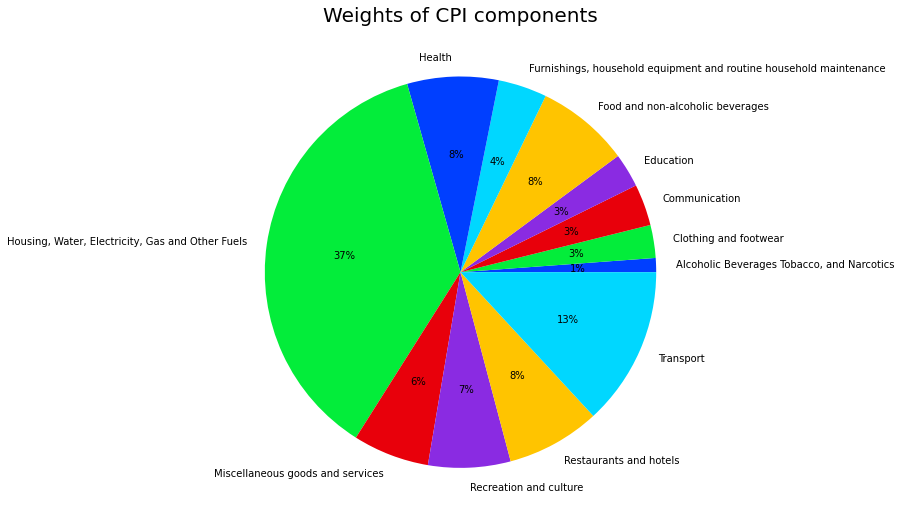

In [76]:
#Let's plot a pie chart with weights for each CPI component
plt.figure(figsize=(16,9))
plt.pie(weights, labels=weights_labels, autopct='%.0f%%')
plt.title('Weights of CPI components', fontdict = {'fontsize' : 20})
plt.show()

In [77]:
#Let's calculate annual CPI change by component
cpi_comp_chg_yoy = (cpi_indices / cpi_indices.shift(12)) - 1
cpi_comp_chg_yoy = cpi_comp_chg_yoy.dropna()
cpi_comp_chg_yoy.head()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
2011-01-01                                            0.032701                       
2011-02-01                                            0.035806                       
2011-03-01                                            0.035374                       
2011-04-01                                            0.033484                       
2011-05-01                                            0.023385                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
2011-01-01                                         -0.003891   
2011-02-01                                         -0.008273   
2011-03-01                                         -0.008557   
2011-04-01                                         -0.002687   
2011-05-01                                          0.004290   

series_name  Monthly – United States – Communication  \
period                                                 
2011-01-01                                 -0.008311   
2011-02-01                                 -0.007508   
2011-03-01                                 -0.007547   
2011-04-01                                 -0.008928   
2011-05-01                                 -0.010064   

series_name  Monthly – United States – Education  \
period                                             
2011-01-01                              0.041720   
2011-02-01                              0.041122   
2011-03-01                              0.039373   
2011-04-01                              0.037768   
2011-05-01                              0.039012   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
2011-01-01                                            0.021016            
2011-02-01                                            0.027961            
2011-03-01                                            0.035458            
2011-04-01                                            0.038832            
2011-05-01                                            0.044401            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
2011-01-01                                           -0.022869                                              
2011-02-01                                           -0.019691                                              
2011-03-01                                           -0.017824                                              
2011-04-01                                           -0.010248                                              
2011-05-01                                           -0.007365                                              

series_name  Monthly – United States – Health  \
period                                          
2011-01-01                           0.035318   
2011-02-01                           0.034917   
2011-03-01                           0.033347   
2011-04-01                           0.034301   
2011-05-01                           0.034847   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
2011-01-01                                            0.006533                            
2011-02-01                                            0.009314                            
2011-03-01                                            0.010273                            
2011-04-01                                            0.011728                            
2011-05-01

In [78]:
#Let's calculate monthly CPI change by component
cpi_comp_chg_mom = (cpi_indices / cpi_indices.shift(1)) - 1
cpi_comp_chg_mom = cpi_comp_chg_mom.dropna()
cpi_comp_chg_mom.tail()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
2021-08-01                                            0.002088                       
2021-09-01                                            0.004433                       
2021-10-01                                            0.008483                       
2021-11-01                                            0.004882                       
2021-12-01                                            0.001307                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
2021-08-01                                          0.018111   
2021-09-01                                          0.019060   
2021-10-01                                          0.009453   
2021-11-01                                         -0.011324   
2021-12-01                                         -0.010438   

series_name  Monthly – United States – Communication  \
period                                                 
2021-08-01                                  0.003465   
2021-09-01                                  0.003179   
2021-10-01                                  0.001390   
2021-11-01                                 -0.000126   
2021-12-01                                  0.000873   

series_name  Monthly – United States – Education  \
period                                             
2021-08-01                              0.006349   
2021-09-01                              0.008338   
2021-10-01                              0.001823   
2021-11-01                              0.000344   
2021-12-01                             -0.000746   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
2021-08-01                                            0.003167            
2021-09-01                                            0.011055            
2021-10-01                                            0.010543            
2021-11-01                                            0.003372            
2021-12-01                                            0.004317            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
2021-08-01                                            0.009128                                              
2021-09-01                                            0.011814                                              
2021-10-01                                            0.006651                                              
2021-11-01                                            0.002960                                              
2021-12-01                                            0.011278                                              

series_name  Monthly – United States – Health  \
period                                          
2021-08-01                           0.003215   
2021-09-01                           0.000373   
2021-10-01                           0.003105   
2021-11-01                           0.000380   
2021-12-01                           0.000239   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
2021-08-01                                            0.003699                            
2021-09-01                                            0.004877                            
2021-10-01                                            0.006205                            
2021-11-01                                            0.004119                            
2021-12-01

In [79]:
#Fetch CPI Index data
cpi = fetch_series('IMF/CPI/M.US.PCPI_IX')
cpi = clean_data(cpi, 'CPI - All Items (M)')
cpi = cpi.loc['2010-01-01':]
cpi['CPI - YoY Chg. (M)'] = (cpi['CPI - All Items (M)'] / cpi['CPI - All Items (M)'].shift(12)) - 1
cpi.tail()

CPI - All Items (M)  CPI - YoY Chg. (M)
period                                             
2021-08-01           125.457510            0.052513
2021-09-01           125.798249            0.053903
2021-10-01           126.843395            0.062219
2021-11-01           127.466631            0.068090
2021-12-01           127.858275            0.070364

In [80]:
#Calculate absolute contribution to inflation
cpi_abs_contr = cpi_comp_chg_yoy * (cpi_weights / 100) * \
                (cpi_indices.shift(12).divide(cpi['CPI - All Items (M)'].shift(12), axis='index'))
cpi_abs_contr = cpi_abs_contr.dropna()
cpi_abs_contr.tail()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
2021-08-01                                            0.000532                       
2021-09-01                                            0.000572                       
2021-10-01                                            0.000631                       
2021-11-01                                            0.000644                       
2021-12-01                                            0.000652                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
2021-08-01                                          0.000889   
2021-09-01                                          0.000766   
2021-10-01                                          0.000997   
2021-11-01                                          0.001172   
2021-12-01                                          0.001322   

series_name  Monthly – United States – Communication  \
period                                                 
2021-08-01                                  0.000242   
2021-09-01                                  0.000269   
2021-10-01                                  0.000272   
2021-11-01                                  0.000284   
2021-12-01                                  0.000331   

series_name  Monthly – United States – Education  \
period                                             
2021-08-01                              0.000456   
2021-09-01                              0.000647   
2021-10-01                              0.000679   
2021-11-01                              0.000701   
2021-12-01                              0.000675   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
2021-08-01                                            0.002262            
2021-09-01                                            0.003409            
2021-10-01                                            0.004070            
2021-11-01                                            0.004803            
2021-12-01                                            0.004900            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
2021-08-01                                            0.001335                                              
2021-09-01                                            0.001777                                              
2021-10-01                                            0.002054                                              
2021-11-01                                            0.002095                                              
2021-12-01                                            0.002460                                              

series_name  Monthly – United States – Health  \
period                                          
2021-08-01                           0.001639   
2021-09-01                           0.001609   
2021-10-01                           0.002056   
2021-11-01                           0.002121   
2021-12-01                           0.002193   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
2021-08-01                                            0.012392                            
2021-09-01                                            0.013693                            
2021-10-01                                            0.015678                            
2021-11-01                                            0.016911                            
2021-12-01

In [81]:
#Calculate relative contribution to inflation
cpi_rel_contr = cpi_abs_contr.divide(cpi['CPI - YoY Chg. (M)'], axis='index')
cpi_rel_contr = cpi_rel_contr.dropna()
cpi_rel_contr.tail()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
2021-08-01                                            0.010128                       
2021-09-01                                            0.010609                       
2021-10-01                                            0.010143                       
2021-11-01                                            0.009461                       
2021-12-01                                            0.009268                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
2021-08-01                                          0.016928   
2021-09-01                                          0.014202   
2021-10-01                                          0.016023   
2021-11-01                                          0.017206   
2021-12-01                                          0.018787   

series_name  Monthly – United States – Communication  \
period                                                 
2021-08-01                                  0.004608   
2021-09-01                                  0.004988   
2021-10-01                                  0.004370   
2021-11-01                                  0.004176   
2021-12-01                                  0.004700   

series_name  Monthly – United States – Education  \
period                                             
2021-08-01                              0.008678   
2021-09-01                              0.012005   
2021-10-01                              0.010914   
2021-11-01                              0.010299   
2021-12-01                              0.009587   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
2021-08-01                                            0.043077            
2021-09-01                                            0.063251            
2021-10-01                                            0.065421            
2021-11-01                                            0.070540            
2021-12-01                                            0.069642            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
2021-08-01                                            0.025429                                              
2021-09-01                                            0.032958                                              
2021-10-01                                            0.033014                                              
2021-11-01                                            0.030775                                              
2021-12-01                                            0.034966                                              

series_name  Monthly – United States – Health  \
period                                          
2021-08-01                           0.031207   
2021-09-01                           0.029859   
2021-10-01                           0.033039   
2021-11-01                           0.031154   
2021-12-01                           0.031160   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
2021-08-01                                            0.235985                            
2021-09-01                                            0.254037                            
2021-10-01                                            0.251980                            
2021-11-01                                            0.248363                            
2021-12-01

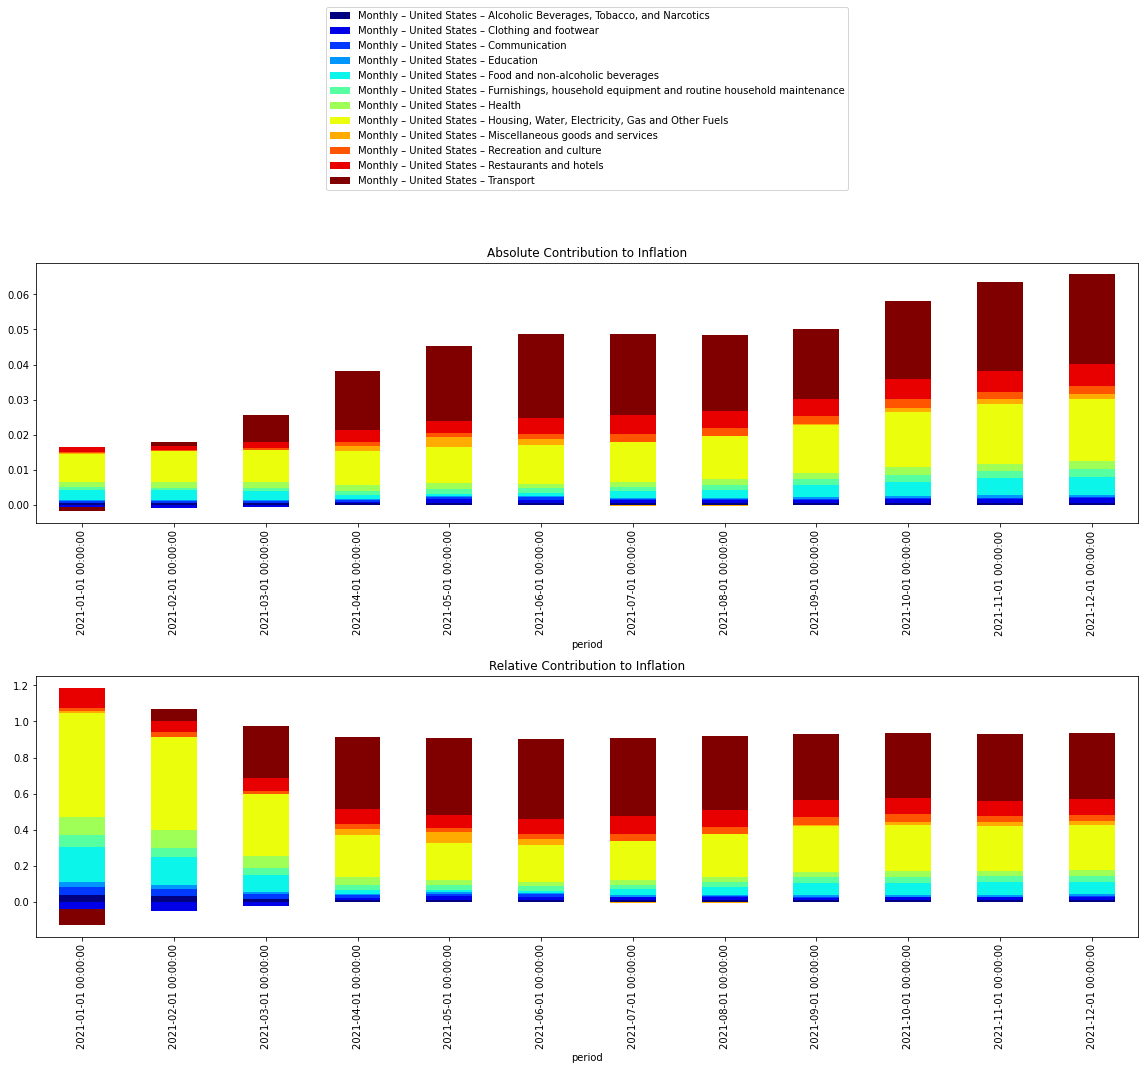

In [183]:
#Chart absolute and relative contribution charts
colors = plt.cm.jet(np.linspace(0, 1, 12))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,13))

ax = cpi_abs_contr.iloc[-12:].plot(ax=axes[0], kind='bar', color=colors, stacked=True, legend=True, title='Absolute Contribution to Inflation')

ax1 = cpi_rel_contr.iloc[-12:].plot(ax=axes[1], kind='bar', color=colors, stacked=True, legend=False, title='Relative Contribution to Inflation')

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 2))

fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

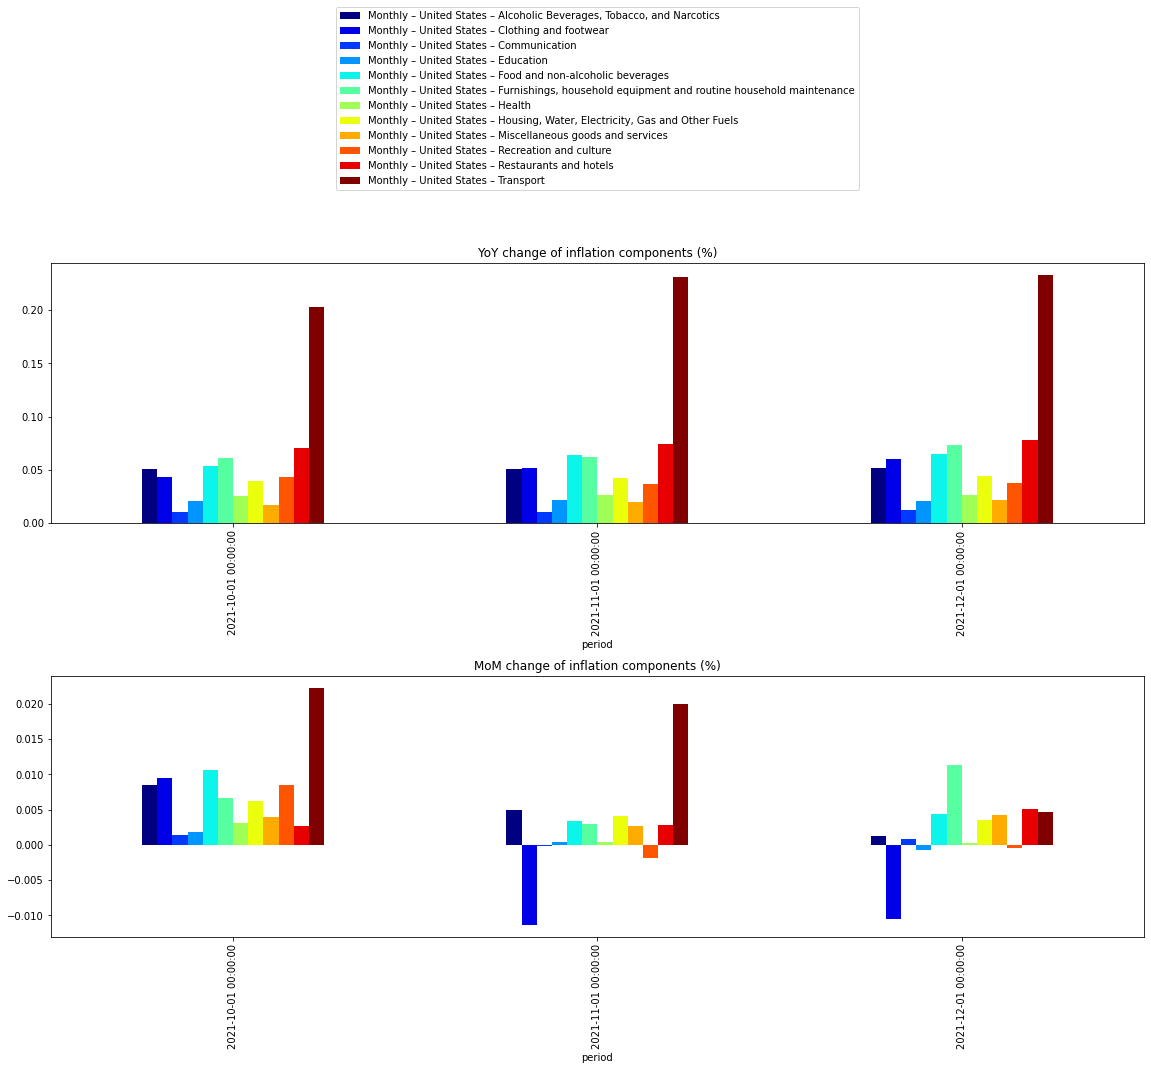

In [83]:
#Chart each CPI component change from previous year
num_colors = 12

colors = plt.cm.jet(np.linspace(0, 1, 12))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,13))

ax = cpi_comp_chg_yoy.iloc[-3:].plot(ax=axes[0], kind='bar', color=colors, stacked=False, legend=True, title='YoY change of inflation components (%)')

ax1 = cpi_comp_chg_mom.iloc[-3:].plot(ax=axes[1], kind='bar', color=colors, stacked=False, legend=False, title='MoM change of inflation components (%)')

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 2))

fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

In [84]:
#Fetch quarterly headline and core inflation data
core_inflation = fetch_series('OECD/EO/USA.PCORE_YTYPCT.Q')
core_inflation = clean_data(core_inflation, 'Core Inflation (Q)')
headline_inflation = fetch_series('OECD/EO/USA.CPI_YTYPCT.Q')
headline_inflation = clean_data(headline_inflation, 'Headline Inflation (Q)')

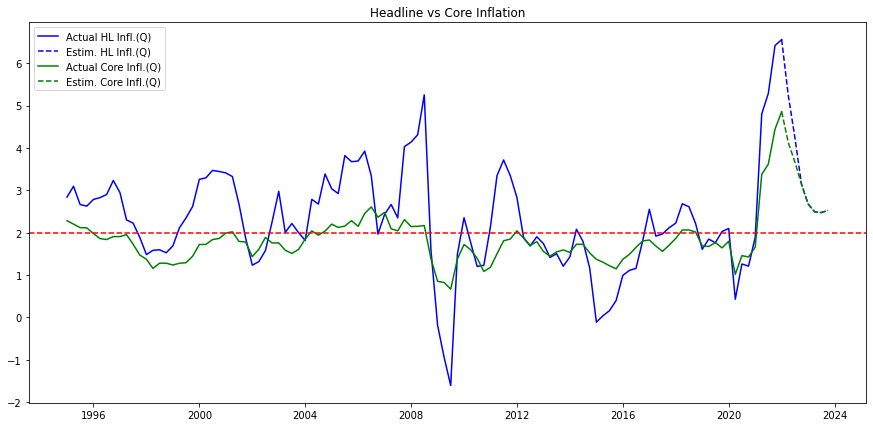

In [85]:
#Plot data for headline vs core inflation
plt.figure(figsize=(15,7))
plt.plot(headline_inflation.loc[:current_quarter], color='b')
plt.plot(headline_inflation.loc[current_quarter:], color='b', linestyle='--')
plt.plot(core_inflation.loc[:current_quarter], color='g')
plt.plot(core_inflation.loc[current_quarter:], color='g', linestyle='--')
plt.axhline(y=2, color='red', linestyle='--')
plt.legend(['Actual HL Infl.(Q)', 'Estim. HL Infl.(Q)', 'Actual Core Infl.(Q)', 'Estim. Core Infl.(Q)'], loc='upper left')
plt.title('Headline vs Core Inflation')
plt.show()

In [86]:
#Download average hourly earnings for all employees - U.S.
avg_h_e = fetch_series('BLS/ce/CES0500000003')
avg_h_e = clean_data(avg_h_e, 'Average Hourly Earnings - $')
avg_h_e.tail()

Average Hourly Earnings - $
period                                 
2021-08-01                        30.67
2021-09-01                        30.84
2021-10-01                        31.01
2021-11-01                        31.12
2021-12-01                        31.31

In [87]:
#Calculate U.S. Average Hourly Earnings YoY data
avg_h_e['Average Hourly Earnings - YoY'] = avg_h_e['Average Hourly Earnings - $'].pct_change(12)
avg_h_e.tail()

Average Hourly Earnings - $  Average Hourly Earnings - YoY
period                                                                
2021-08-01                        30.67                       0.040719
2021-09-01                        30.84                       0.045424
2021-10-01                        31.01                       0.050474
2021-11-01                        31.12                       0.050996
2021-12-01                        31.31                       0.046807

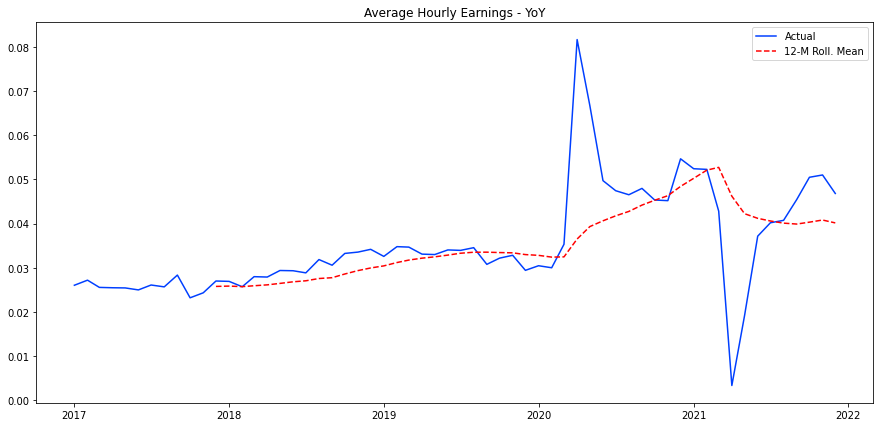

In [184]:
#Plot Average Hourly Earnings YoY data
plt.figure(figsize=(15,7))
plt.plot(avg_h_e['Average Hourly Earnings - YoY'].iloc[-60:])
plt.plot(avg_h_e['Average Hourly Earnings - YoY'].iloc[-60:].rolling(12).mean(), color='r', linestyle='--')
plt.legend(['Actual', '12-M Roll. Mean'])
plt.title('Average Hourly Earnings - YoY')
plt.show()

In [89]:
#Fetch House Price Index data
hpi = fetch_series('FHFA/HPI/traditional_purchase-only_monthly_usa-or-census-division_USA_sa')
hpi = clean_data(hpi, 'House Price Index - M')
hpi['12-M Avg.'] = hpi['House Price Index - M'].rolling(12).mean()

The FHFA HPI is a broad measure of the movement of single-family house prices. The FHFA HPI is a weighted, repeat-sales index, meaning that it measures average price changes in repeat sales or refinancings on the same properties. This information is obtained by reviewing repeat mortgage transactions on single-family properties whose mortgages have been purchased or securitized by Fannie Mae or Freddie Mac since January 1975. The FHFA HPI serves as a timely, accurate indicator of house price trends at various geographic levels. Because of the breadth of the sample, it provides more information than is available in other house price indexes. It also provides housing economists with an improved analytical tool that is useful for estimating changes in the rates of mortgage defaults, prepayments and housing affordability in specific geographic areas.

In [90]:
#Fetch S&P/Case-Shiller 20-City Composite Home Price Index data
case_shiller_20 = fred.get_series('SPCS20RSA')

The S&P/Case-Shiller 20-City Composite Home Price Index is a monthly index that tracks changes in the price of residential real estate in 20 major metropolitan regions in the U.S.

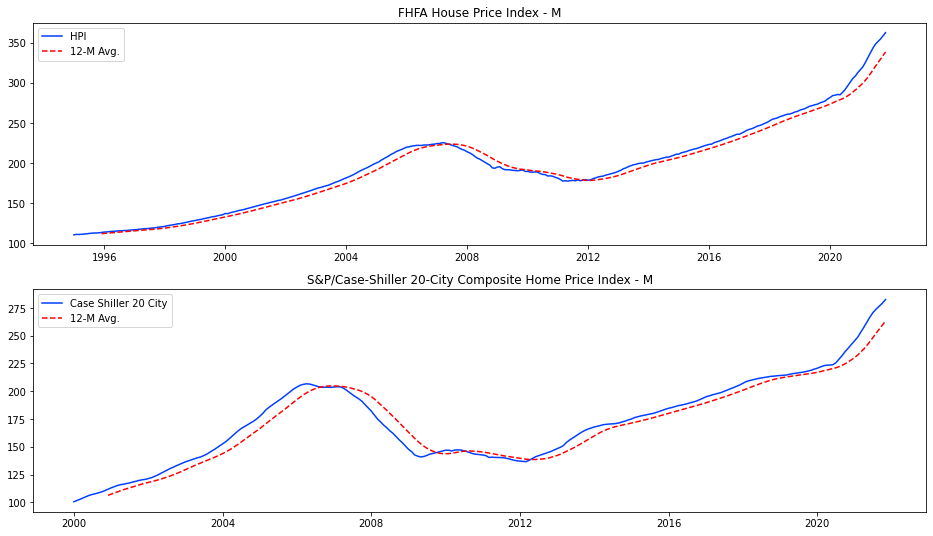

In [91]:
#Plot housing data
plt.subplots(figsize=(16,9))
plt.subplot(211)
plt.plot(hpi['House Price Index - M'])
plt.plot(hpi['12-M Avg.'], color='r', linestyle='--')
plt.legend(['HPI', '12-M Avg.'])
plt.title('FHFA House Price Index - M')

plt.subplot(212)
plt.plot(case_shiller_20)
plt.plot(case_shiller_20.rolling(12).mean(), color='r', linestyle='--')
plt.legend(['Case Shiller 20 City', '12-M Avg.'])
plt.title('S&P/Case-Shiller 20-City Composite Home Price Index - M')

plt.show()

In [186]:
#Fetch 30-year US mortgage rate
mortgage = pd.DataFrame(fred.get_series('MORTGAGE30US'), columns={'30-Y Mtg. Rate'})
mortgage.tail()

30-Y Mtg. Rate
2021-12-30            3.11
2022-01-06            3.22
2022-01-13            3.45
2022-01-20            3.56
2022-01-27            3.55

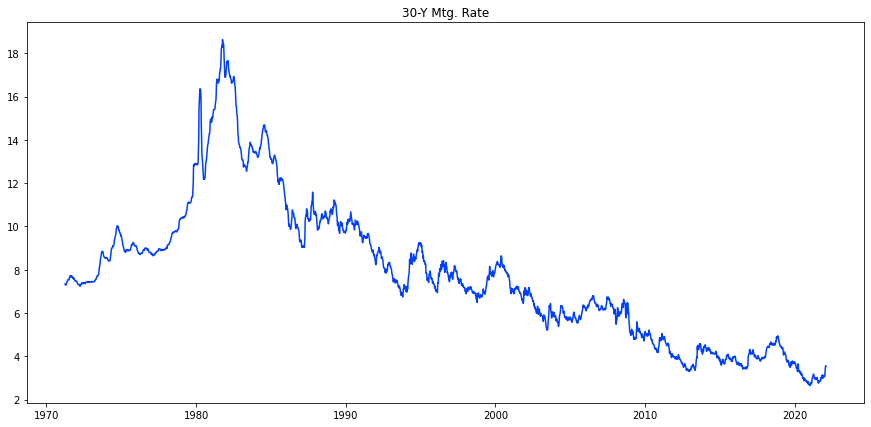

In [187]:
#Plot 30-year US mortgage rate
plt.figure(figsize=(15,7))
plt.plot(mortgage)
plt.title('30-Y Mtg. Rate')
plt.show()

In [92]:
#Fetch monthly base metals prices in $
base_metals = fetch_series('RBA/I2/GRCPBMUSD')
base_metals = clean_data(base_metals, 'Base Metals - $')
base_metals['Avg - Rol. 3M'] = base_metals['Base Metals - $'].rolling(3).mean()
base_metals['Avg - Rol. 12M'] = base_metals['Base Metals - $'].rolling(12).mean()
base_metals.tail()

Base Metals - $  Avg - Rol. 3M  Avg - Rol. 12M
period                                                    
2021-11-30       156.310437     158.232920      144.278354
2021-12-31       157.315228     158.784398      146.947209
2022-01-31              NaN            NaN             NaN
2022-02-28              NaN            NaN             NaN
2022-03-31              NaN            NaN             NaN

In [93]:
#Download lumber futures data as a leading indicator of inflationary pressures in the housing market
lumber = yf.download('LBS=F', period='5y', interval = "1mo")['Adj Close']


[*********************100%***********************]  1 of 1 completed


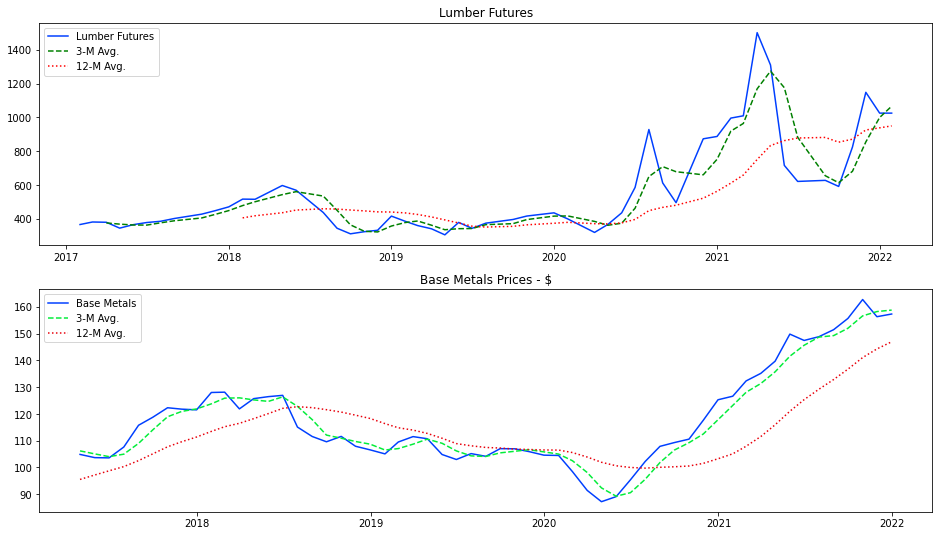

In [94]:
#Plot lumber futures prices
plt.subplots(figsize=(16,9))
plt.subplot(211)
plt.plot(lumber)
plt.plot(lumber.rolling(3).mean(), linestyle='--', color='g')
plt.plot(lumber.rolling(12).mean(), linestyle=':', color='r')
plt.legend(['Lumber Futures', '3-M Avg.', '12-M Avg.'], loc='upper left')
plt.title('Lumber Futures')

plt.subplot(212)
plt.plot(base_metals['Base Metals - $'].iloc[-60:], linestyle='-')
plt.plot(base_metals['Avg - Rol. 3M'].iloc[-60:], linestyle='--')
plt.plot(base_metals['Avg - Rol. 12M'].iloc[-60:], linestyle=':')
plt.title('Base Metals Prices - $')
plt.legend(['Base Metals', '3-M Avg.', '12-M Avg.'])
plt.show()

# Section 5: Monetary Policy Analysis  

In this section we are about to analyze how the monetary policy is and how it should presumably evolve over time. For this purpose we will look at the Forward-looking Taylor rule formula, as well as the Real Monetary Condition Index, which suit well where the CB is focused on inflation goals. The limitation of these tools lies in the calibration of the parameters used in the formulas, which may differ used from the CB. We will also try to assess the chance of a rate hike by 0.25% and will have a look at the economic projections made by the FED and its famous "dot plot".

In [194]:
#Let's download and organize data for the Forward-looking version of the Taylor Rule
cb_policy_rate = fetch_series('IMF/IFS/Q.US.FPOLM_PA')
cb_policy_rate = clean_data(cb_policy_rate, 'Policy Rate')

infl_rate = fetch_series('IMF/CPI/Q.US.PCPI_PC_CP_A_PT')
infl_rate = clean_data(infl_rate, 'CPI YoY% - Q')

exp_infl = pd.DataFrame()
exp_infl['Exp. Infl. - Q'] = fred.get_series('MICH', frequency='q')
 
taylor_rule = pd.concat([gdp_decomp["Log Real GDP"], gdp_decomp['trend'], cb_policy_rate, infl_rate, exp_infl], axis=1)
taylor_rule = taylor_rule.dropna()
taylor_rule.tail()

Log Real GDP      trend  Policy Rate  CPI YoY% - Q  Exp. Infl. - Q
2020-07-01     16.736561  16.760351        0.125      1.222386             2.9
2020-10-01     16.747652  16.764111        0.125      1.239488             2.6
2021-01-01     16.762874  16.767949        0.125      1.898514             3.1
2021-04-01     16.779149  16.771843        0.125      4.848945             4.1
2021-07-01     16.784842  16.775771        0.125      5.335693             4.6

Fwd-looking Taylor Rule --> i(t) = g1 * i(t-1) + (1 - g1 * {i_n(t) + g2 * (exp_infl(t+n) - target_infl) + g3 * output gap} + epsilon

In [195]:
#Let's calculate the Forward-looking version of the Taylor Rule

taylor_rule['Real Policy Rate'] = taylor_rule['Policy Rate'] - taylor_rule['Exp. Infl. - Q']
cycle, trend = sm.tsa.filters.hpfilter(taylor_rule['Real Policy Rate'], 1600)
taylor_rule['Real Neutral Rate'] = trend
taylor_rule['Nominal Neutral Rate'] = taylor_rule['Real Neutral Rate'] + taylor_rule['Exp. Infl. - Q']
taylor_rule['Inflation Target'] = 2
taylor_rule['Exp. - Target Infl'] = taylor_rule['Exp. Infl. - Q'] - taylor_rule['Inflation Target']
taylor_rule['Output Gap Estim.'] = taylor_rule['Log Real GDP'] - taylor_rule['trend']
taylor_rule['g1'] = 0.75 
taylor_rule['g2'] = 0.5
taylor_rule['g3'] = 0.5
taylor_rule['Target Rate'] = (taylor_rule['g1'] * taylor_rule['Policy Rate'].shift(1)) + ((1 - taylor_rule['g1']) * (taylor_rule['Nominal Neutral Rate'] + (taylor_rule['g2'] * taylor_rule['Exp. - Target Infl'] + (taylor_rule['g3'] * taylor_rule['Output Gap Estim.']))))
taylor_rule['Rate Difference'] = taylor_rule['Policy Rate'] - taylor_rule['Target Rate']

In [196]:
taylor_rule.tail()

Log Real GDP      trend  Policy Rate  CPI YoY% - Q  \
2020-07-01     16.736561  16.760351        0.125      1.222386   
2020-10-01     16.747652  16.764111        0.125      1.239488   
2021-01-01     16.762874  16.767949        0.125      1.898514   
2021-04-01     16.779149  16.771843        0.125      4.848945   
2021-07-01     16.784842  16.775771        0.125      5.335693   

            Exp. Infl. - Q  Real Policy Rate  Real Neutral Rate  \
2020-07-01             2.9            -2.775          -2.233915   
2020-10-01             2.6            -2.475          -2.383215   
2021-01-01             3.1            -2.975          -2.537432   
2021-04-01             4.1            -3.975          -2.694477   
2021-07-01             4.6            -4.475          -2.852536   

            Nominal Neutral Rate  Inflation Target  Exp. - Target Infl  \
2020-07-01              0.666085                 2                 0.9   
2020-10-01              0.216785                 2                 0.6   
2021-01-01              0.562568                 2                 1.1   
2021-04-01              1.405523                 2                 2.1   
2021-07-01              1.747464                 2                 2.6   

            Output Gap Estim.    g1   g2   g3  Target Rate  Rate Difference  
2020-07-01          -0.023790  0.75  0.5  0.5     0.369798        -0.244798  
2020-10-01          -0.016459  0.75  0.5  0.5     0.220889        -0.095889  
2021-01-01          -0.005075  0.75  0.5  0.5     0.371258        -0.246258  
2021-04-01           0.007305  0.75  0.5  0.5     0.708544        -0.583544  
2021-07-01           0.009071  0.75  0.5  0.5     0.856750        -0.731750

In [197]:
def taylor_rule_vis(g1, g2, g3):
    
    target_rate = g1 * taylor_rule['Policy Rate'].iloc[-2] +\
    ((1 - g1) * ((taylor_rule['Nominal Neutral Rate'].iloc[-1]) +\
    (g2 * taylor_rule['Exp. - Target Infl'].iloc[-1]) +\
    (g3 * taylor_rule['Output Gap Estim.'].iloc[-1])))
    
    policy_rate = taylor_rule['Policy Rate'].iloc[-1]
    
    neutral_rate = taylor_rule['Nominal Neutral Rate'].iloc[-1]
    
    plt.subplots(figsize=(16,14))
    
    plt.subplot(331)
    plt.bar(x=str(taylor_rule.index.max()), height=policy_rate, width=0.1, color='b')
    plt.title('Policy Rate')
    plt.ylim(-3, 3)
    
    plt.subplot(332)
    plt.bar(x=str(taylor_rule.index.max()), height=target_rate, width=0.1, color='r')
    plt.title('Target Rate')
    plt.ylim(-3, 3)
    
    plt.subplot(333)
    plt.bar(x=str(taylor_rule.index.max()), height=neutral_rate, width=0.1, color='g')
    plt.title('Neutral Rate')
    plt.ylim(-3, 3)
    

<p style="color:red;">N.B.: Sum of g2 and g3 cannot be greater than 1</p>

In [198]:
widgets.interact(taylor_rule_vis, g1=(0.25, 0.95, 0.05), g2=(0.25, 0.95, 0.05), g3=(0.25, 0.95, 0.05));

interactive(children=(FloatSlider(value=0.55, description='g1', max=0.95, min=0.25, step=0.05), FloatSlider(va…

In [199]:
#Fetch and organize data for the RMCI calculation
cpi_dom = fetch_series('IMF/CPI/Q.US.PCPI_IX')
cpi_dom = clean_data(cpi_dom, 'Domestic CPI')

usd_eur = fetch_series('BIS/xru_current/Q.XM.EUR.A')
usd_eur = clean_data(usd_eur, 'USD/EUR')

cpi_for = cpi_dom.mul(usd_eur.values)
cpi_for = cpi_for.rename(columns={'Domestic CPI':'Foreign CPI'})

comm_rate = fred.get_series('RIFSPPNA2P2D90NB', frequency='q')
comm_rate = comm_rate.loc['2003-01-01':]
comm_rate = comm_rate.dropna()

rmci = pd.concat([cpi_dom, cpi_for, taylor_rule['Exp. Infl. - Q']], axis=1)
rmci = rmci.loc['2003-01-01':]

rmci['Commercial Rate'] = comm_rate
rmci = rmci.dropna()
rmci.tail()

Domestic CPI  Foreign CPI  Exp. Infl. - Q  Commercial Rate
2020-07-01    119.128540   101.947107             2.9             0.29
2020-10-01    119.402476   100.118618             2.6             0.27
2021-01-01    120.683801   100.178658             3.1             0.24
2021-04-01    123.507547   102.434937             4.1             0.21
2021-07-01    125.484873   106.454715             4.6             0.19

In [200]:
#Calculate the RMCI
a = 0.7 #Let's assume the value of alpha is 0.7

rmci['Real Comm. Rate'] = rmci['Commercial Rate'] - rmci['Exp. Infl. - Q']

cycle, trend = sm.tsa.filters.hpfilter(rmci['Real Comm. Rate'], 1600)

rmci['Real Int. Rate Trend'] = trend
rmci['Real Int. Rate Gap'] = rmci['Real Comm. Rate'] - rmci['Real Int. Rate Trend']
rmci['FC/LC'] = 1 / usd_eur
rmci['Real Exch. Rate'] = (np.log(rmci['FC/LC']).values + np.log(rmci['Domestic CPI']).values - np.log(rmci['Foreign CPI'].values))*100

cycle_1, trend_1 = sm.tsa.filters.hpfilter(rmci['Real Exch. Rate'], 1600)

rmci['Real Exch. Rate Trend'] = trend_1
rmci['Real Exch. Rate Gap'] = rmci['Real Exch. Rate'] - rmci['Real Exch. Rate Trend']
rmci['RMCI'] = (a * rmci['Real Int. Rate Gap']) + ((1 - a) * rmci['Real Exch. Rate Gap'])

rmci.tail()

Domestic CPI  Foreign CPI  Exp. Infl. - Q  Commercial Rate  \
2020-07-01    119.128540   101.947107             2.9             0.29   
2020-10-01    119.402476   100.118618             2.6             0.27   
2021-01-01    120.683801   100.178658             3.1             0.24   
2021-04-01    123.507547   102.434937             4.1             0.21   
2021-07-01    125.484873   106.454715             4.6             0.19   

            Real Comm. Rate  Real Int. Rate Trend  Real Int. Rate Gap  \
2020-07-01            -2.61             -1.785706           -0.824294   
2020-10-01            -2.33             -1.948410           -0.381590   
2021-01-01            -2.86             -2.117230           -0.742770   
2021-04-01            -3.89             -2.289483           -1.600517   
2021-07-01            -4.41             -2.462954           -1.947046   

               FC/LC  Real Exch. Rate  Real Exch. Rate Trend  \
2020-07-01  1.168533        31.149791              28.048512   
2020-10-01  1.192610        35.228855              28.619047   
2021-01-01  1.204686        37.243748              29.208780   
2021-04-01  1.205717        37.414887              29.806377   
2021-07-01  1.178763        32.893106              30.405528   

            Real Exch. Rate Gap      RMCI  
2020-07-01             3.101279  0.353378  
2020-10-01             6.609808  1.715829  
2021-01-01             8.034968  1.890551  
2021-04-01             7.608510  1.162191  
2021-07-01             2.487577 -0.616659

In [201]:
#Let's create a function for RMCI simulation
def rmci_vis(a):
    
    rmci_df = pd.DataFrame(index=rmci.index)
    rmci_df['RMCI'] = (a * rmci['Real Int. Rate Gap']) + ((1 - a) * rmci['Real Exch. Rate Gap'])
    
    plt.figure(figsize=(15,7))
    plt.plot(rmci_df, color='b', marker='s')
    plt.title('RMCI')

For Emerging Countries the level of alpha ranges from 0.3 to 0.7, while for Developed Economies it is higher.

In [202]:
widgets.interact(rmci_vis, a=(0, 1, 0.1));

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0), Output()), _dom_classes=('widget-inter…

A positive index points to tight monetary conditions, constraining domestic demand and therefore inflation. A negative index points to accomodative conditions, boosting demand and therefore inflation.

<p style="color:red;">N.B.: The ff_futures ticker needs to be changed according to the forecast horizon!!</p>

In [292]:
#Download Fed Funds rate futures data 
ff_futures = yf.download('ZQH22.CBT', period='1y')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [293]:
ff_futures.tail()

Date
2022-01-24    99.800003
2022-01-25    99.785004
2022-01-26    99.785004
2022-01-27    99.769997
2022-01-28    99.775002
Name: Adj Close, dtype: float64

In [294]:
#Fetch Fed Funds target rate data
ff_target_ul = fred.get_series('DFEDTARU', observation_start='2021-01-01')
ff_target_ll = fred.get_series('DFEDTARL', observation_start='2021-01-01')

In [295]:
#Calculate percent probability of a rate hike by the FED
fed_prob = pd.concat([ff_futures, ff_target_ul, ff_target_ll], axis=1)
fed_prob = fed_prob.dropna()
fed_prob.rename(columns={fed_prob.columns[0]: "ff_futures", fed_prob.columns[1]: "ff_target_ul", fed_prob.columns[2]: "ff_target_ll"}, inplace = True)
fed_prob['ff_target_mid'] = (fed_prob['ff_target_ul'] + fed_prob['ff_target_ll']) / 2
fed_prob['ff_implied'] = 100 - fed_prob['ff_futures']
fed_prob['ff_increase'] = fed_prob['ff_target_mid'] + 0.25
fed_prob['Probability of a rate hike'] = (fed_prob['ff_implied'] - fed_prob['ff_target_mid']) / (fed_prob['ff_increase'] - fed_prob['ff_target_mid'])
fed_prob.tail()

ff_futures  ff_target_ul  ff_target_ll  ff_target_mid  ff_implied  \
2022-01-24   99.800003          0.25           0.0          0.125    0.199997   
2022-01-25   99.785004          0.25           0.0          0.125    0.214996   
2022-01-26   99.785004          0.25           0.0          0.125    0.214996   
2022-01-27   99.769997          0.25           0.0          0.125    0.230003   
2022-01-28   99.775002          0.25           0.0          0.125    0.224998   

            ff_increase  Probability of a rate hike  
2022-01-24        0.375                    0.299988  
2022-01-25        0.375                    0.359985  
2022-01-26        0.375                    0.359985  
2022-01-27        0.375                    0.420013  
2022-01-28        0.375                    0.399994

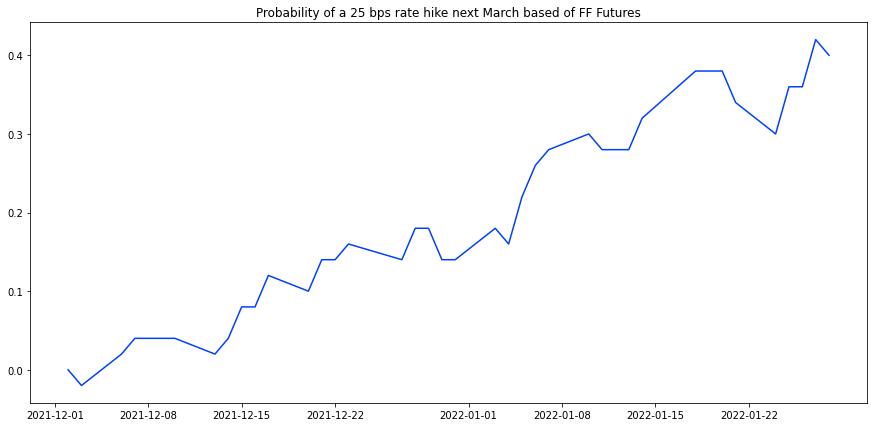

In [299]:
#Plot probability of a rate hike
plt.figure(figsize=(15,7))
plt.plot(fed_prob['Probability of a rate hike'].iloc[-40:])
plt.title('Probability of a 25 bps rate hike next March based of FF Futures')
plt.show()

In [207]:
#Download vintage dates for FED dot plot
from __future__ import print_function
vintage_dates = fred.get_series_vintage_dates('FEDTARMD')
dates = []
for dt in vintage_dates[-2:]:
    dates.append(dt.strftime('%Y-%m-%d'))
    print(dt.strftime('%Y-%m-%d'))

2021-09-22
2021-12-15


In [208]:
#Download median estimates of last two FOMC meetings for the Change in Real GDP median
fomc_gdp_previous = fred.get_series('GDPC1MD', realtime_end=dates[0])
fomc_gdp_last = fred.get_series('GDPC1MD', realtime_end=dates[1])
fomc_gdp = pd.concat([fomc_gdp_previous, fomc_gdp_last], axis=1)
fomc_gdp = fomc_gdp.dropna()
fomc_gdp.rename(columns={fomc_gdp.columns[0]: "Previous", fomc_gdp.columns[1]: "Last"}, inplace = True)
fomc_gdp

Previous  Last
2021-01-01       5.9   5.5
2022-01-01       3.8   4.0
2023-01-01       2.5   2.2
2024-01-01       2.0   2.0

In [209]:
#Download median estimates of last two FOMC meetings for the Unemployment rate median
fomc_uer_previous = fred.get_series('UNRATEMD', realtime_end=dates[0])
fomc_uer_last = fred.get_series('UNRATEMD', realtime_end=dates[1])
fomc_uer = pd.concat([fomc_uer_previous, fomc_uer_last], axis=1)
fomc_uer = fomc_uer.dropna()
fomc_uer.rename(columns={fomc_uer.columns[0]: "Previous", fomc_uer.columns[1]: "Last"}, inplace = True)
fomc_uer

Previous  Last
2021-01-01       4.8   4.3
2022-01-01       3.8   3.5
2023-01-01       3.5   3.5
2024-01-01       3.5   3.5

In [210]:
#Download median estimates of last two FOMC meetings for the PCE deflator rate median
fomc_pce_previous = fred.get_series('PCECTPIMD', realtime_end=dates[0])
fomc_pce_last = fred.get_series('PCECTPIMD', realtime_end=dates[1])
fomc_pce = pd.concat([fomc_pce_previous, fomc_pce_last], axis=1)
fomc_pce = fomc_pce.dropna()
fomc_pce.rename(columns={fomc_pce.columns[0]: "Previous", fomc_pce.columns[1]: "Last"}, inplace = True)
fomc_pce

Previous  Last
2021-01-01       4.2   5.3
2022-01-01       2.2   2.6
2023-01-01       2.2   2.3
2024-01-01       2.1   2.1

In [211]:
#Download median estimates of last two FOMC meetings for the Core PCE deflator rate median
fomc_core_pce_previous = fred.get_series('JCXFEMD', realtime_end=dates[0])
fomc_core_pce_last = fred.get_series('JCXFEMD', realtime_end=dates[1])
fomc_core_pce = pd.concat([fomc_core_pce_previous, fomc_core_pce_last], axis=1)
fomc_core_pce = fomc_core_pce.dropna()
fomc_core_pce.rename(columns={fomc_core_pce.columns[0]: "Previous", fomc_core_pce.columns[1]: "Last"}, inplace = True)
fomc_core_pce

Previous  Last
2021-01-01       3.7   4.4
2022-01-01       2.3   2.7
2023-01-01       2.2   2.3
2024-01-01       2.1   2.1

In [212]:
#Download median estimates of last two FOMC meetings for the Fed Funds rate median
fomc_ffr_previous = fred.get_series('FEDTARMD', realtime_end=dates[0])
fomc_ffr_last = fred.get_series('FEDTARMD', realtime_end=dates[1])
fomc_ffr = pd.concat([fomc_ffr_previous, fomc_ffr_last], axis=1)
fomc_ffr = fomc_ffr.dropna()
fomc_ffr.rename(columns={fomc_ffr.columns[0]: "Previous", fomc_ffr.columns[1]: "Last"}, inplace = True)
fomc_ffr

Previous  Last
2021-01-01       0.1   0.1
2022-01-01       0.3   0.9
2023-01-01       1.0   1.6
2024-01-01       1.8   2.1

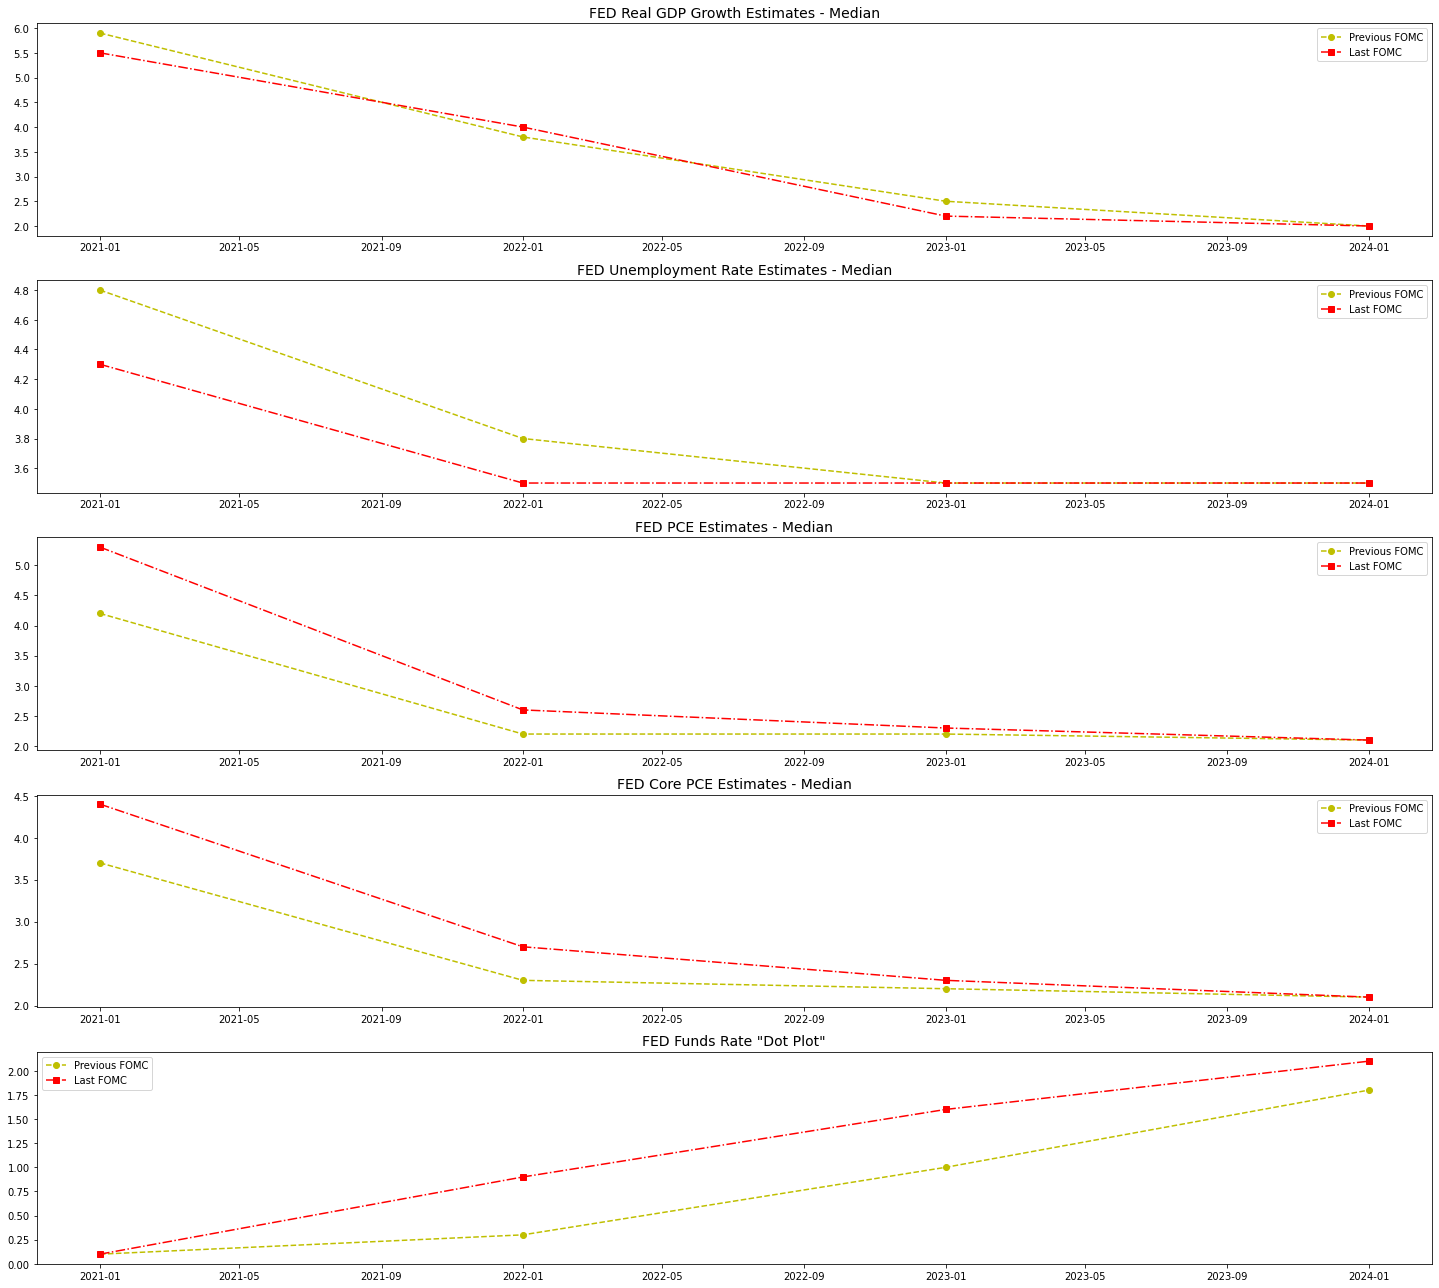

In [213]:
#Plot median estimates of rates from the last two FOMC meetings
plt.figure(figsize=(20,18))
plt.subplot(511)
plt.plot(fomc_gdp['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_gdp['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED Real GDP Growth Estimates - Median', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.subplot(512)
plt.plot(fomc_uer['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_uer['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED Unemployment Rate Estimates - Median', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.subplot(513)
plt.plot(fomc_pce['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_pce['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED PCE Estimates - Median', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.subplot(514)
plt.plot(fomc_core_pce['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_core_pce['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED Core PCE Estimates - Median', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.subplot(515)
plt.plot(fomc_ffr['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_ffr['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED Funds Rate "Dot Plot"', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.tight_layout()
plt.show()

# Section 6: Macrofinancial Linkages 

In this section we'll look at main ratios of financial soundness and their recommended thresholds under Basel III. Furthermore, we'll evaluate the chance of default in the banking system using the z-score. 

In [214]:
#Capital adequacy
tier_1_rwa = fred.get_series('BOGZ1FL010000016Q')
tier_1_ta = fred.get_series('BOGZ1FL010000026Q')
cap_adeq = pd.concat([tier_1_rwa, tier_1_ta], axis=1)
cap_adeq.rename(columns={cap_adeq.columns[0]: "Tier 1 / RWA", cap_adeq.columns[1]: "Tier 1 / Tot. Assets"}, inplace = True)
cap_adeq['Leverage'] = 1 / (cap_adeq['Tier 1 / Tot. Assets'] / 100)
cap_adeq.head()

Tier 1 / RWA  Tier 1 / Tot. Assets   Leverage
2009-10-01          11.4                   8.4  11.904762
2010-01-01          11.8                   8.3  12.048193
2010-04-01          12.1                   8.5  11.764706
2010-07-01          12.3                   8.6  11.627907
2010-10-01          12.3                   8.6  11.627907

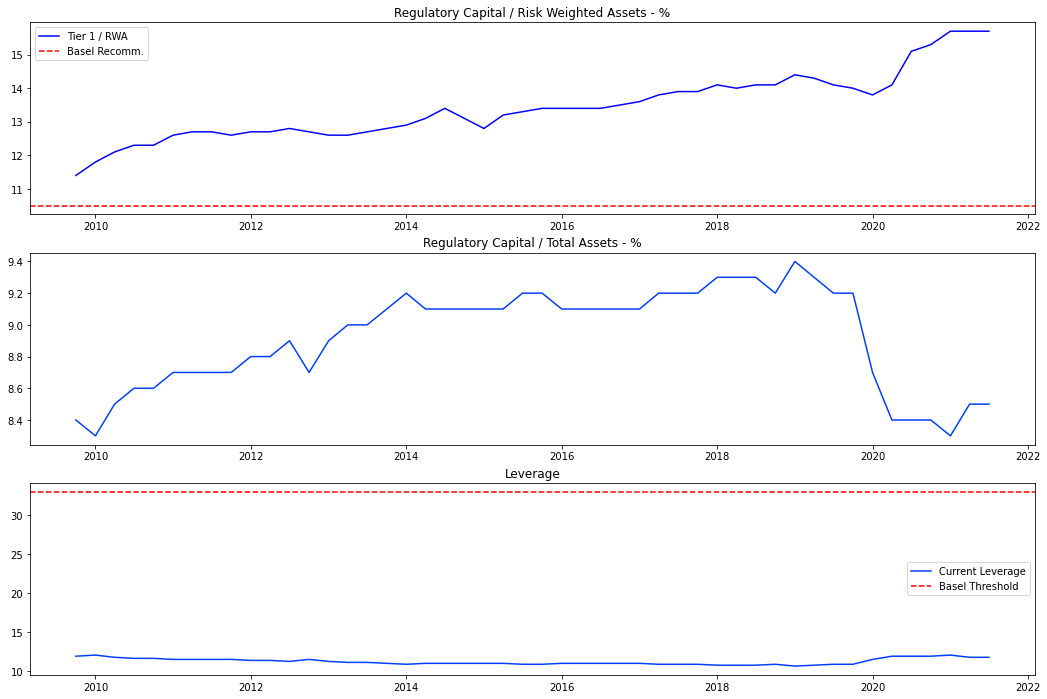

In [215]:
#Plot capital adequacy analysis
plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(cap_adeq['Tier 1 / RWA'], color='blue')
plt.axhline(y=10.5, color='red', linestyle='--')
plt.title('Regulatory Capital / Risk Weighted Assets - %')
plt.legend(['Tier 1 / RWA', 'Basel Recomm.'])

plt.subplot(312)
plt.plot(cap_adeq['Tier 1 / Tot. Assets'])
plt.title('Regulatory Capital / Total Assets - %')

plt.subplot(313)
plt.plot(cap_adeq['Leverage'])
plt.axhline(y=33, color='red', linestyle='--')
plt.title('Leverage')
plt.legend(['Current Leverage', 'Basel Threshold'], loc='best')

plt.show()

In [216]:
#Asset quality
npl_to_tot = fred.get_series('BOGZ1FL010000046Q')
npl_net_to_capital = fred.get_series('BOGZ1FL010000036Q')
asset_quality = pd.concat([npl_to_tot, npl_net_to_capital], axis=1)
asset_quality.rename(columns={asset_quality.columns[0]: "NPL / Total Loans - (Before Prov.)", asset_quality.columns[1]: "NPL / Capital - (After Prov.)"}, inplace = True)
asset_quality.tail()

NPL / Total Loans - (Before Prov.)  NPL / Capital - (After Prov.)
2020-07-01                                 1.1                            5.3
2020-10-01                                 1.1                            5.3
2021-01-01                                 1.1                            5.1
2021-04-01                                 1.0                            4.5
2021-07-01                                 0.9                            4.1

<function matplotlib.pyplot.show(close=None, block=None)>

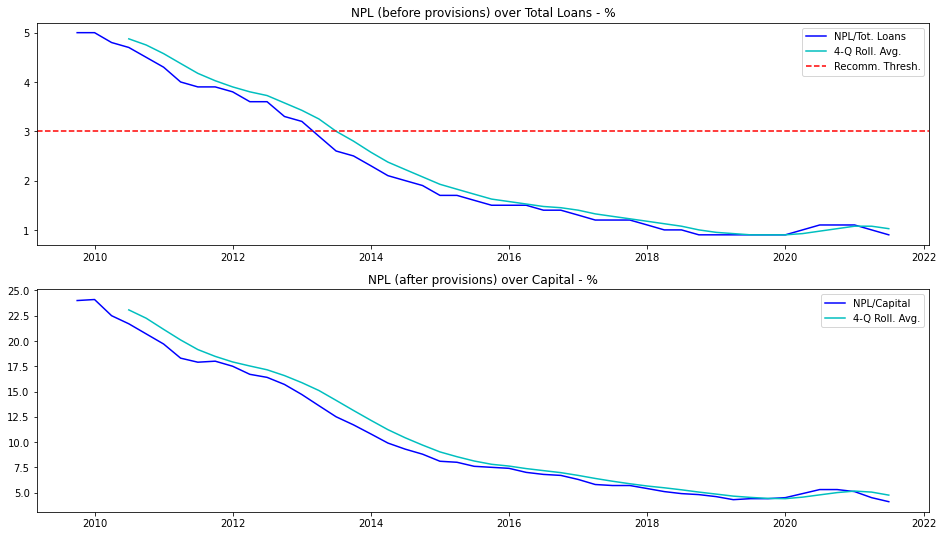

In [217]:
#Plot asset quality analysis
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(asset_quality['NPL / Total Loans - (Before Prov.)'], color='blue')
plt.plot(asset_quality['NPL / Total Loans - (Before Prov.)'].rolling(4).mean(), color='c')
plt.axhline(y=3, color='red', linestyle='--')
plt.title('NPL (before provisions) over Total Loans - %')
plt.legend(['NPL/Tot. Loans', '4-Q Roll. Avg.', 'Recomm. Thresh.'])

plt.subplot(212)
plt.plot(asset_quality['NPL / Capital - (After Prov.)'], color='blue')
plt.plot(asset_quality['NPL / Capital - (After Prov.)'].rolling(4).mean(), color='c')
plt.title('NPL (after provisions) over Capital - %')
plt.legend(['NPL/Capital', '4-Q Roll. Avg.'])

plt.show

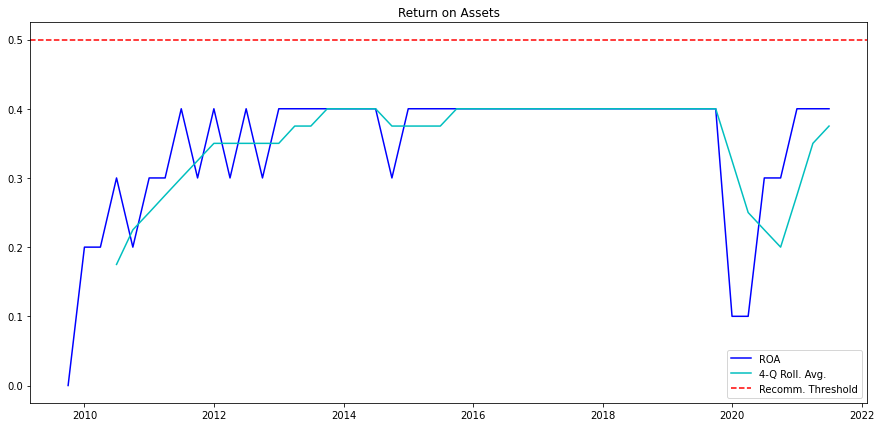

In [218]:
#Profitability analysis
roa = fred.get_series('BOGZ1FL010000056Q')

plt.figure(figsize=(15,7))
plt.plot(roa, color='blue')
plt.plot(roa.rolling(4).mean(), color='c')
plt.axhline(y=0.5, color='red', linestyle='--')
plt.title('Return on Assets')
plt.legend(['ROA', '4-Q Roll. Avg.', 'Recomm. Threshold'])

plt.show()

In [219]:
#Liquidity analysis
liq_assets_to_sht_liab = fetch_series('IMF/FSI/Q.US.FSLS_PT')
liq_assets_to_sht_liab = clean_data(liq_assets_to_sht_liab, 'Liquid Assets / Sht Liab.')

liq_asset_ratio = fetch_series('IMF/FSI/Q.US.FSLT_PT')
liq_asset_ratio = clean_data(liq_asset_ratio, 'Liquid Asset Ratio')

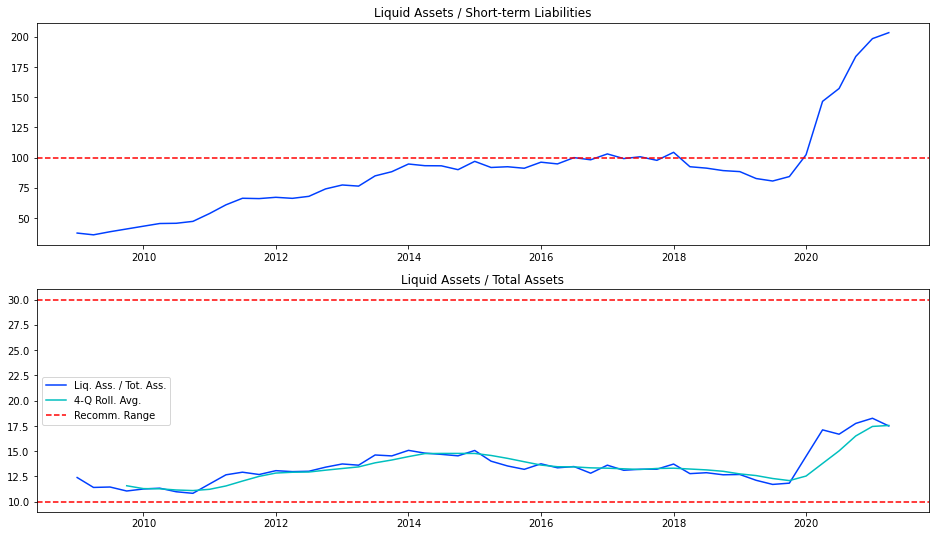

In [220]:
#Plot liquidity analysis
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(liq_assets_to_sht_liab)
plt.axhline(y=100, color='red', linestyle='--')
plt.title('Liquid Assets / Short-term Liabilities')

plt.subplot(212)
plt.plot(liq_asset_ratio)
plt.plot(liq_asset_ratio.rolling(4).mean(), color='c')
plt.axhline(y=10, color='red', linestyle='--')
plt.axhline(y=30, color='red', linestyle='--')
plt.title('Liquid Assets / Total Assets')
plt.legend(['Liq. Ass. / Tot. Ass.', '4-Q Roll. Avg.', 'Recomm. Range'])

plt.show()

<p style="color:red;">N.B.: For other countries, perform the Net Open Position analysis too (unit 6.4)</p>

In [221]:
#Let's calculate the z-score
roa_std = (roa / 100).std()
z_score =  ((cap_adeq['Tier 1 / Tot. Assets'][-1] / 100)) + (roa[-1] /100 ) / roa_std
print('It takes about ' + str(z_score) + ' std(roa) to bankrupt the banks')

It takes about 4.317451729515636 std(roa) to bankrupt the banks


In [222]:
p_value = scipy.stats.norm.sf(abs(z_score))
print('If ROA follows a normal distribution, probability of bank capital being exhausted is: ' + str(int(p_value)))

If ROA follows a normal distribution, probability of bank capital being exhausted is: 0


# Section 7: Fiscal Policy Analysis

In this section we look at how discretionary fiscal policy measures compare to the business cycle. Specifically, we want to understand if the fiscal policy is pro or counter-cyclical in relation to the business cycle. We will analyze the fiscal impulse (the first difference of the fiscal stance, that is a measure of fiscal policy net of automatic stabilizers) and the relative position of primary balance vs cyclically adjusted primary balance to assess whether the economy is above or below potential.  

In [223]:
#Download data for overall and primary balance (in % of GDP)
overall_balance = fetch_series('IMF/FM/A.US.GGXCNL_G01_GDP_PT')
overall_balance = clean_data(overall_balance, 'Overall Balance (% GDP)')

primary_balance = fetch_series('IMF/FM/A.US.GGXONLB_G01_GDP_PT')
primary_balance = clean_data(primary_balance, 'Primary Balance (% GDP)')

cab = fetch_series('IMF/FM/A.US.GGCB_G01_PGDP_PT')
cab = clean_data(cab, 'Cyclically Adjusted Balance (% Pot. GDP)')

capb = fetch_series('IMF/FM/A.US.GGCBP_G01_PGDP_PT')
capb = clean_data(capb, 'Cyclically Adjusted Primary Balance (% Pot. GDP)')

str_bal = fetch_series('IMF/WEO:2021-10/USA.GGSB_NPGDP.pcent_potential_gdp')
str_bal = clean_data(str_bal, 'Structural Balance (% Pot. GDP)')

fiscal_monitor = pd.concat([overall_balance, primary_balance, cab, capb, str_bal], axis=1)

fiscal_monitor['Interest Spending'] = fiscal_monitor['Primary Balance (% GDP)'] - fiscal_monitor['Overall Balance (% GDP)']

fiscal_monitor['Fiscal Stance'] = -capb

fiscal_monitor['Fiscal Impulse'] = fiscal_monitor['Fiscal Stance'] - fiscal_monitor['Fiscal Stance'].shift(1) 

fiscal_monitor = fiscal_monitor.dropna()

In [224]:
fiscal_monitor.tail()

Overall Balance (% GDP)  Primary Balance (% GDP)  \
period                                                         
2022-01-01                -6.887349                -5.597945   
2023-01-01                -5.715872                -4.348285   
2024-01-01                -5.196414                -3.553878   
2025-01-01                -5.293492                -3.331356   
2026-01-01                -5.318010                -2.971150   

            Cyclically Adjusted Balance (% Pot. GDP)  \
period                                                 
2022-01-01                                 -8.261957   
2023-01-01                                 -7.085470   
2024-01-01                                 -6.227260   
2025-01-01                                 -6.042358   
2026-01-01                                 -5.847355   

            Cyclically Adjusted Primary Balance (% Pot. GDP)  \
period                                                         
2022-01-01                                         -6.929913   
2023-01-01                                         -5.676621   
2024-01-01                                         -4.547088   
2025-01-01                                         -4.048167   
2026-01-01                                         -3.475132   

            Structural Balance (% Pot. GDP)  Interest Spending  Fiscal Stance  \
period                                                                          
2022-01-01                           -8.262           1.289404       6.929913   
2023-01-01                           -7.085           1.367586       5.676621   
2024-01-01                           -6.227           1.642537       4.547088   
2025-01-01                           -6.042           1.962136       4.048167   
2026-01-01                           -5.847           2.346860       3.475132   

            Fiscal Impulse  
period                      
2022-01-01       -0.176904  
2023-01-01       -1.253292  
2024-01-01       -1.129533  
2025-01-01       -0.498921  
2026-01-01       -0.573035

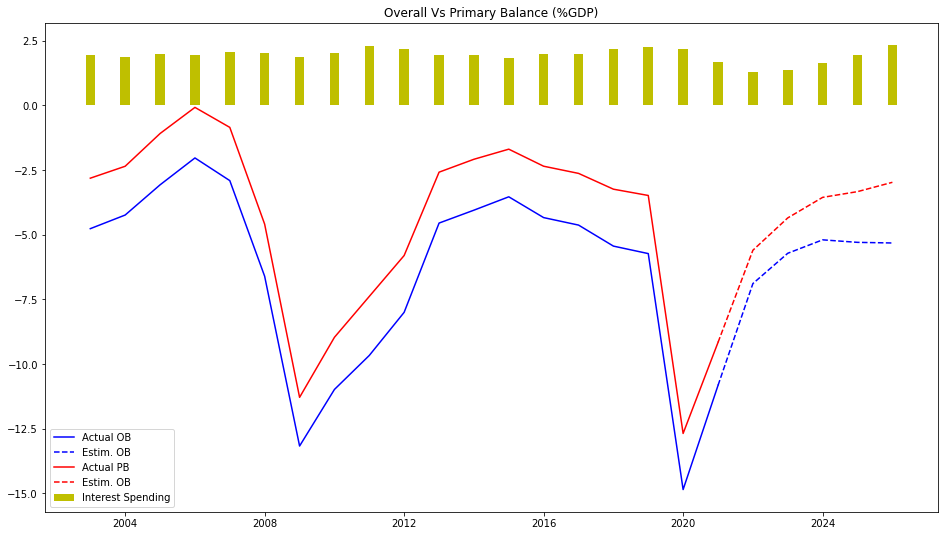

In [225]:
#Plot Overall vs Primary Balance and Interest Spending
plt.figure(figsize=(16,9))
plt.bar(fiscal_monitor.index, fiscal_monitor['Interest Spending'], width=100, color='y')
plt.plot(fiscal_monitor['Overall Balance (% GDP)'].loc[:today], color='blue')
plt.plot(fiscal_monitor['Overall Balance (% GDP)'].loc[today:], linestyle='--', color='blue')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[:today], color='red')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[today:], linestyle='--', color='red')
plt.title('Overall Vs Primary Balance (%GDP)')
plt.legend(['Actual OB', 'Estim. OB', 'Actual PB', 'Estim. OB', 'Interest Spending'])
plt.show()

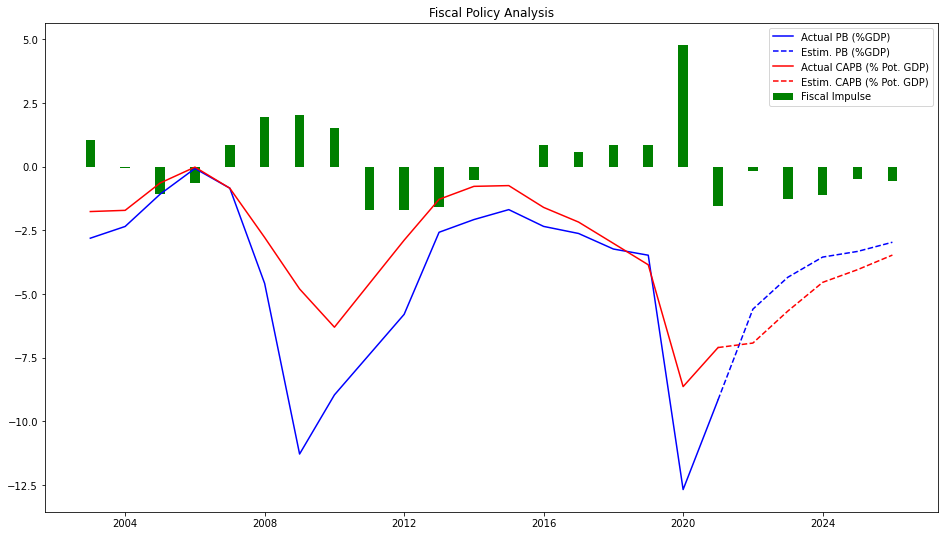

In [226]:
#Plot fiscal impulse to analyze if the fiscal policy is pro-cyclical or counter-cyclical
plt.figure(figsize=(16,9))
plt.bar(fiscal_monitor.index, fiscal_monitor['Fiscal Impulse'], width=100, color='g')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[:today], color='blue')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[today:], linestyle='--', color='blue')
plt.plot(fiscal_monitor['Cyclically Adjusted Primary Balance (% Pot. GDP)'].loc[:today], color='red')
plt.plot(fiscal_monitor['Cyclically Adjusted Primary Balance (% Pot. GDP)'].loc[today:], linestyle='--', color='red')
plt.title('Fiscal Policy Analysis')
plt.legend(['Actual PB (%GDP)', 'Estim. PB (%GDP)', 'Actual CAPB (% Pot. GDP)', 'Estim. CAPB (% Pot. GDP)','Fiscal Impulse'])
plt.show()

When Primary Balance > Cyclically Adjusted Primary Balance, output gap is positive: if fiscal impulse is positive, then fiscal policy is pro-cyclical, otherwise it is counter-cyclical. 

When Primary Balance < Cyclically Adjusted Primary Balance, output gap is negative: if fiscal impulse is negative, then fiscal policy is pro-cyclical, otherwise it is counter-cyclical.

Generally, we would like to see counter-cyclical fiscal policy to face short-term business cycle needs, but sometimes fiscal policy is pro-cyclical in order to balance medium-term fiscal policy sustainability.

# Section 8: Fiscal Sustainability Analysis

In this section we are going to look at how Debt to GDP varies according to different scenarios: in fact, changing hypothesis about gdp growth, interest rates, primary balance and currency depreciation/appreciation, we will obtain different paths of debt evolution.

In [227]:
#Fetch and plot Debt to GDP data
gross_debt_gdp = fetch_series('IMF/FM/A.US.G_XWDG_G01_GDP_PT')
gross_debt_gdp = clean_data(gross_debt_gdp, 'Gross Debt to GDP')

net_debt_gdp = fetch_series('IMF/FM/A.US.GGXWDN_G01_GDP_PT')
net_debt_gdp = clean_data(net_debt_gdp, 'Net Debt to GDP')

In [228]:
gross_debt_gdp.tail(7)

Gross Debt to GDP
period                       
2020-01-01         133.919737
2021-01-01         133.283935
2022-01-01         130.654210
2023-01-01         131.092430
2024-01-01         131.702961
2025-01-01         132.519576
2026-01-01         133.454945

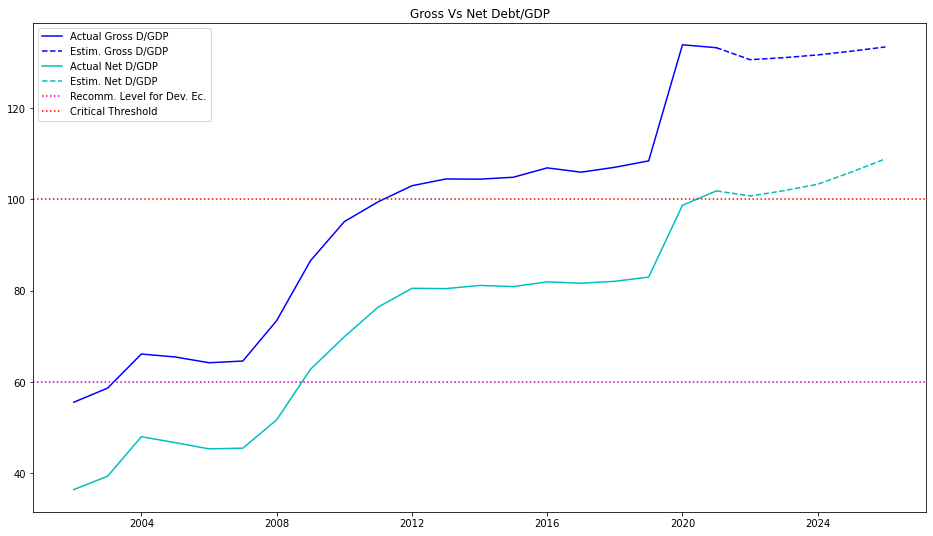

In [229]:
#Plot gross vs net Debt to GDP 
plt.figure(figsize=(16,9))
plt.plot(gross_debt_gdp.loc[:today], color='b')
plt.plot(gross_debt_gdp.loc[today:], linestyle='--', color='b')
plt.plot(net_debt_gdp.loc[:today], color='c')
plt.plot(net_debt_gdp.loc[today:], linestyle='--', color='c')
plt.axhline(y=60, color='m', linestyle='dotted')
plt.axhline(y=100, color='red', linestyle='dotted')
plt.title('Gross Vs Net Debt/GDP')
plt.legend(['Actual Gross D/GDP', 'Estim. Gross D/GDP', 'Actual Net D/GDP', 'Estim. Net D/GDP', 'Recomm. Level for Dev. Ec.', 'Critical Threshold'])
plt.show()

In [230]:
#Let's define a function to calculate Public Debt to GDP
def fiscal_debt_path(gr1, gr2, gr3, gr4, gr5, r1, r2, r3, r4, r5, pb1, pb2, pb3, pb4, pb5):
    
    public_debt_t0 = gross_debt_gdp.loc[today]
    
    public_debt_t1 = (1 + r1) / (1 + gr1) * public_debt_t0 - pb1
    public_debt_t2 = (1 + r2) / (1 + gr2) * public_debt_t1 - pb2
    public_debt_t3 = (1 + r3) / (1 + gr3) * public_debt_t2 - pb3
    public_debt_t4 = (1 + r4) / (1 + gr4) * public_debt_t3 - pb4
    public_debt_t5 = (1 + r5) / (1 + gr5) * public_debt_t4 - pb5
    
    rng = pd.date_range(today, periods=6, freq='YS')
    scenario = pd.DataFrame()
    scenario = scenario.append([public_debt_t0, public_debt_t1, public_debt_t2, public_debt_t3, public_debt_t4, public_debt_t5])
    scenario = scenario.set_index(rng)
    
    plt.figure(figsize=(15,7))
    plt.plot(scenario, color='b', marker='s')
    plt.title('Public Debt to GDP - Scenario Analysis')


In [231]:
#Create a slider to make scenario analysis for Public Debt to GDP
widgets.interact(fiscal_debt_path, gr1=(-0.1, 0.1, 0.005), gr2=(-0.1, 0.1, 0.005), gr3=(-0.1, 0.1, 0.005), gr4=(-0.1, 0.1, 0.005), gr5=(-0.1, 0.1, 0.005), r1=(-0.1, 0.1, 0.005), r2=(-0.1, 0.1, 0.005), r3=(-0.1, 0.1, 0.005), r4=(-0.1, 0.1, 0.005), r5=(-0.1, 0.1, 0.005), pb1=(-15, 15, 1), pb2=(-15, 15, 1), pb3=(-15, 15, 1), pb4=(-15, 15, 1), pb5=(-15, 15, 1));

interactive(children=(FloatSlider(value=0.0, description='gr1', max=0.1, min=-0.1, step=0.005), FloatSlider(va…

# Section 9: External Position Analysis

In this section we will analyze the current account situation of the country. Specifically, we want to understand if the country is running a surplus or a deficit. The CA can be seen from two perspectives: net exports + primary and secondary income; or savings - investment. A deficit means the country is receiving more flows from abroad to finance its investment and have imports > exports; a surplus means that the country is investing more abroad to fund foreign countries investment and have exports > imports. We will also analyze the different components of the financial account. 

In [232]:
#Fetch quarterly CA data in USD and in %GDP
ca_usd_q = fetch_series('OECD/MEI/USA.B6BLTT01.CXCUSA.Q')
ca_usd_q = clean_data(ca_usd_q, 'Current Account - Tot. Balance (USD)')

ca_gdp_q = fetch_series('OECD/MEI/USA.B6BLTT02.STSA.Q')
ca_gdp_q = clean_data(ca_gdp_q, 'Current Account - Tot. Balance (%GDP)')

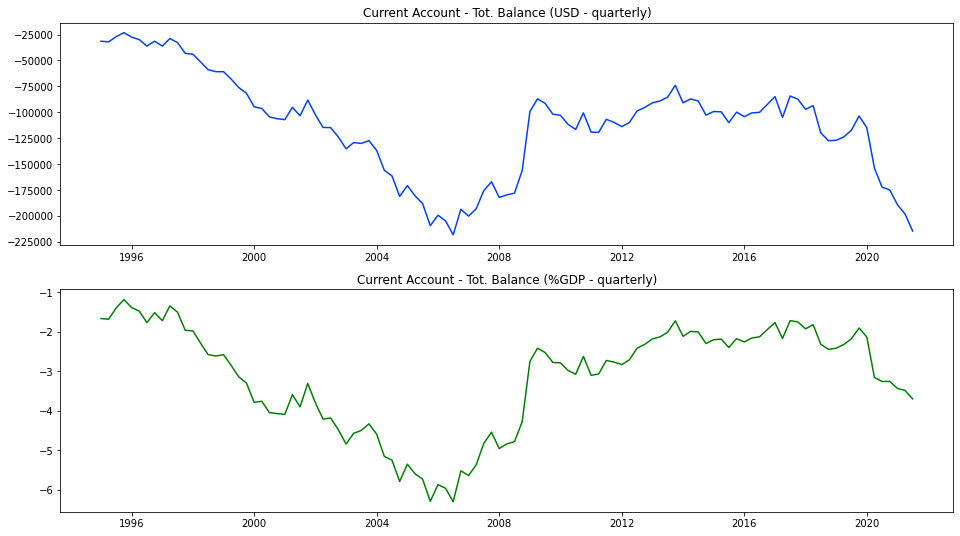

In [304]:
#Plot CA quarterly data
plt.subplots(figsize=(16,9))
plt.subplot(211)
plt.plot(ca_usd_q)
plt.title('Current Account - Tot. Balance (USD - quarterly)')

plt.subplot(212)
plt.plot(ca_gdp_q, color='g')
plt.title('Current Account - Tot. Balance (%GDP - quarterly)')

plt.show()

In [234]:
#Fetch Current Account, Savings and Investments data (annual figures)
ca = fetch_series('IMF/WEO:2021-10/USA.BCA_NGDPD.pcent_gdp')
ca = clean_data(ca, 'Current Account - %GDP')

savings = fetch_series('IMF/WEO:2021-10/USA.NGSD_NGDP.pcent_gdp')
savings = clean_data(savings, 'Gross National Savings - %GDP')

investments = fetch_series('IMF/WEO:2021-10/USA.NID_NGDP.pcent_gdp')
investments = clean_data(investments, 'Total Investments - %GDP')

ext_pos = pd.concat([ca, savings, investments], axis=1)

ext_pos.tail()

Current Account - %GDP  Gross National Savings - %GDP  \
period                                                              
2022-01-01                  -3.500                         20.186   
2023-01-01                  -3.293                         20.421   
2024-01-01                  -2.950                         20.617   
2025-01-01                  -2.625                         20.797   
2026-01-01                  -2.364                         20.940   

            Total Investments - %GDP  
period                                
2022-01-01                    22.377  
2023-01-01                    22.465  
2024-01-01                    22.366  
2025-01-01                    22.265  
2026-01-01                    22.190

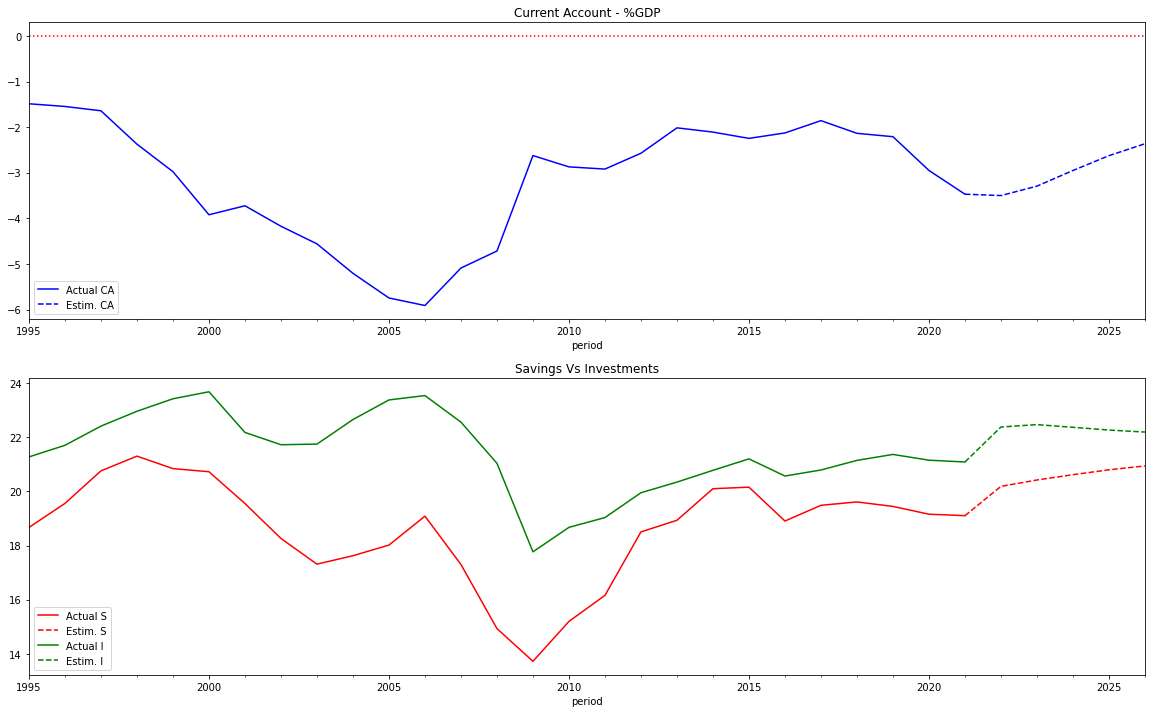

In [235]:
#Plot decomposition of CA
plt.figure(figsize=(20,12))

plt.subplot(211)
ext_pos['Current Account - %GDP'].loc[:today].plot(color='blue')
ext_pos['Current Account - %GDP'].loc[today:].plot(color='blue', linestyle='--')
plt.axhline(y=0, color='red', linestyle='dotted')
plt.title('Current Account - %GDP')
plt.legend(['Actual CA', 'Estim. CA'])

plt.subplot(212)
ext_pos['Gross National Savings - %GDP'].loc[:today].plot(color='red')
ext_pos['Gross National Savings - %GDP'].loc[today:].plot(color='red', linestyle='--')
ext_pos['Total Investments - %GDP'].loc[:today].plot(color='green')
ext_pos['Total Investments - %GDP'].loc[today:].plot(color='green', linestyle='--')
plt.title('Savings Vs Investments')
plt.legend(['Actual S', 'Estim. S', 'Actual I', 'Estim. I'])
plt.show()

If the country is running a current account deficit this means that our investment is being funded from abroad. From the financial perspective the country is accumulating liabilities. On the contrary, a current account surplus tells us that the country is providing savings to fund investment in other countries. From the financial perspective it is accumulating assets.

In [236]:
#Fetch quarterly data on Terms of Trade and Current account
tot = fetch_series('AMECO/APGS/USA.3.0.0.0.APGS')
tot = clean_data(tot, 'Terms of Trade goods and services - A')


ca_ann = fetch_series('OECD/EO/USA.CBGDPR.A')
ca_ann = clean_data(ca_ann, 'Current Account - A')

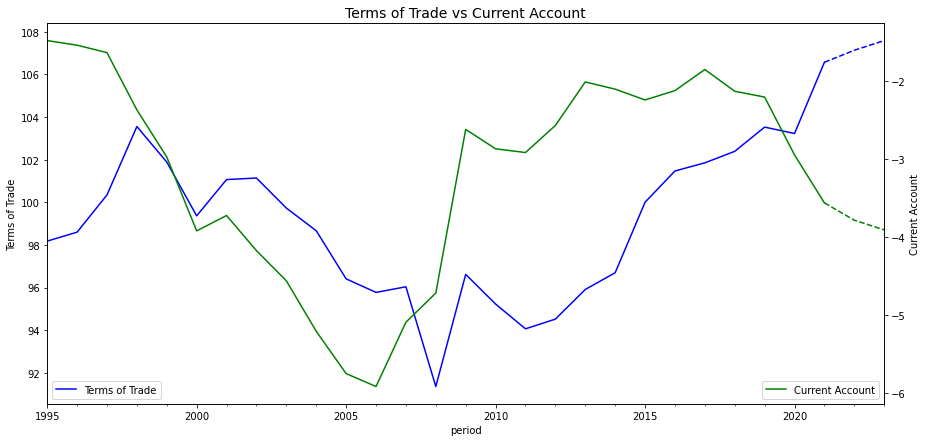

In [323]:
#Plot Terms of Trade and CA data
fig, ax = plt.subplots(figsize=(15,7))
ax=tot.loc[:today].plot(ax=ax, color='b', legend=False)
ax=tot.loc[today:].plot(ax=ax, color='b', linestyle='--', legend=False)
ax1=ca_ann.loc[:today].plot(ax=ax, color='g', legend=False, secondary_y=True)
ax1=ca_ann.loc[today:].plot(ax=ax, color='g', legend=False, secondary_y=True, linestyle='--')
plt.title('Terms of Trade vs Current Account', fontsize =14)

ax.legend(['Terms of Trade'], loc='lower left')
ax1.legend(['Current Account'], loc='lower right')

ax.set(ylabel='Terms of Trade')
ax1.set(ylabel='Current Account')

plt.show()

External Terms of Trade (i.e. Price of exports / Price of imports) tell us how much did the changes in export prices or import prices, holding all else constant, boost or push down the CA balance.

In [238]:
#Fetch REER data
reer = fetch_series('IMF/IFS/Q.US.EREER_IX')
reer = clean_data(reer, 'REER - Q')

ca_q = fetch_series('OECD/EO/USA.CBGDPR.Q')
ca_q = clean_data(ca_q, 'Current Account - Q')

ca_vs_reer = pd.concat([reer, ca_q], axis=1)
ca_vs_reer = ca_vs_reer.dropna()
ca_vs_reer.tail()

REER - Q  Current Account - Q
period                                     
2020-10-01  114.482442            -3.260681
2021-01-01  112.967038            -3.438099
2021-04-01  113.860169            -3.346948
2021-07-01  116.093561            -3.675204
2021-10-01  118.470995            -3.774936

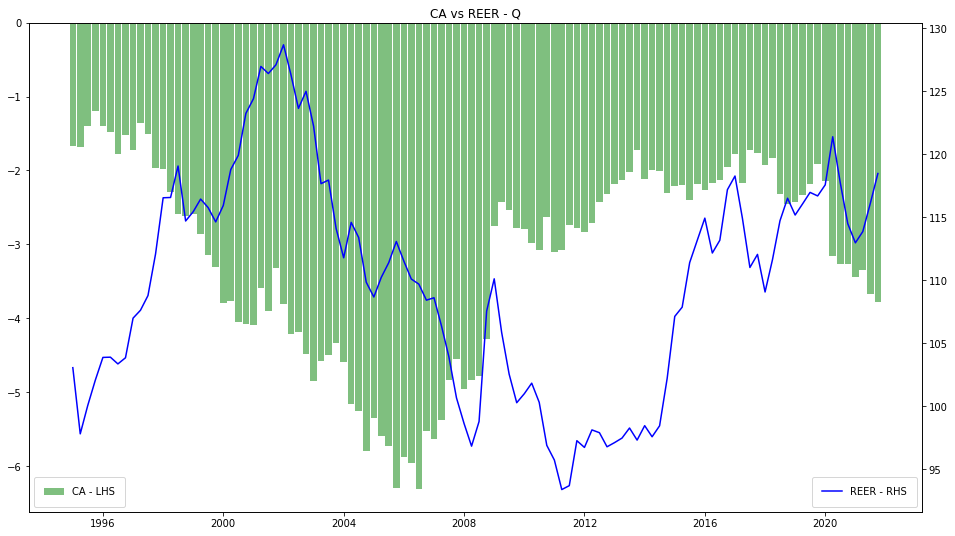

In [305]:
#Plot REER and CA data
fig, ax = plt.subplots(figsize=(16,9))
ax = plt.bar(ca_vs_reer.index, ca_vs_reer['Current Account - Q'], width=80, color='g', alpha=0.5)
ax = plt.legend(['CA - LHS'], loc='lower left', borderpad=1)
plt.twinx()
ax1 = plt.plot(ca_vs_reer['REER - Q'], color='b')
ax1 = plt.legend(['REER - RHS'], loc='lower right', borderpad=1)
plt.title('CA vs REER - Q')

plt.show()

The Real Exchange Rate is inversely proportioned to the CA. In fact, an appreciation of the REER leads to an increasing CA deficit (because exports tend to decrease compared to imports if the currency appreciates); on the other hand, if the REER depreciates, we may expect a decreasing deficit or an increasing surplus (because exports tend to increase compared to imports if the currency depreciates). The elasticity of CA to variations in REER is given by eta (i.e. the CA elasticity).

In [240]:
fa = ['IMF/BOPAGG/A.US.BFD_BP6_USD', 
       'IMF/BOPAGG/A.US.BFF_BP6_USD', 
       'IMF/BOPAGG/A.US.BFOFR_BP6_USD', 
       'IMF/BOPAGG/A.US.BFP_BP6_USD', 
       'IMF/BOPAGG/A.US.BFRAFR_BP6_USD', 
       'IMF/BOPAGG/A.US.BOPFR_BP6_USD']

fin_acc = pd.DataFrame()

for i in fa:
    fin_acc = fin_acc.append(fetch_series(i)[['period', 'series_name', 'value']])
    
fin_acc = fin_acc.pivot(index='period', columns='series_name', values='value')

ann_gdp = fetch_series('OECD/QNA/USA.B1_GS1.CARSA.A')
ann_gdp = clean_data(ann_gdp, 'Annual GDP')

fin_acc['GDP'] = ann_gdp

fin_acc = fin_acc.dropna()
fin_acc.head()

series_name  Annual – United States – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                                  
2006-01-01                                            -29710.0                                                                                          
2007-01-01                                             -6222.0                                                                                          
2008-01-01                                             32947.0                                                                                          
2009-01-01                                            -44816.0                                                                                          
2010-01-01                                            -14076.0                                                                                          

series_name  Annual – United States – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                                   
2006-01-01                                            -14662.0                                                                                                           
2007-01-01                                            177277.0                                                                                                           
2008-01-01                                              2491.0                                                                                                           
2009-01-01                                            151514.0                                                                                                           
2010-01-01                                             85789.0                                                                                                           

series_name  Annual – United States – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                                
2006-01-01                                           -633367.0                                        
2007-01-01                                           -775806.0                                        
2008-01-01                                           -807954.0                                        
2009-01-01                                             18530.0                                        
2010-01-01                                           -620815.0                                        

series_name  Annual – United States – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                                     
2006-01-01                                        -1501.315217                                                             
2007-01-01                                       109776.068325                                                             
2008-01-01                                       -50368.021762                                                             
2009-01-01                                       146246.619422                                                             
2010-01-01                                        -7502.950633                                                             

series_name  Annual – United States – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                

In [241]:
fin_acc_to_gdp = fin_acc.iloc[:,:-1].div(fin_acc.GDP, axis=0)
fin_acc_to_gdp.head()

series_name  Annual – United States – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                                  
2006-01-01                                           -0.002150                                                                                          
2007-01-01                                           -0.000430                                                                                          
2008-01-01                                            0.002231                                                                                          
2009-01-01                                           -0.003095                                                                                          
2010-01-01                                           -0.000935                                                                                          

series_name  Annual – United States – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                                   
2006-01-01                                           -0.001061                                                                                                           
2007-01-01                                            0.012248                                                                                                           
2008-01-01                                            0.000169                                                                                                           
2009-01-01                                            0.010465                                                                                                           
2010-01-01                                            0.005701                                                                                                           

series_name  Annual – United States – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                                
2006-01-01                                           -0.045844                                        
2007-01-01                                           -0.053599                                        
2008-01-01                                           -0.054703                                        
2009-01-01                                            0.001280                                        
2010-01-01                                           -0.041253                                        

series_name  Annual – United States – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                                     
2006-01-01                                           -0.000109                                                             
2007-01-01                                            0.007584                                                             
2008-01-01                                           -0.003410                                                             
2009-01-01                                            0.010101                                                             
2010-01-01                                           -0.000499                                                             

series_name  Annual – United States – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                

In [242]:
fin_acc_to_gdp = fin_acc_to_gdp * 100
fin_acc_to_gdp.tail()

series_name  Annual – United States – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                                  
2016-01-01                                            0.041867                                                                                          
2017-01-01                                            0.123195                                                                                          
2018-01-01                                           -0.099400                                                                                          
2019-01-01                                           -0.194969                                                                                          
2020-01-01                                           -0.027664                                                                                          

series_name  Annual – United States – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                                   
2016-01-01                                           -0.933790                                                                                                           
2017-01-01                                            0.146769                                                                                                           
2018-01-01                                           -1.677441                                                                                                           
2019-01-01                                           -0.842238                                                                                                           
2020-01-01                                            0.480498                                                                                                           

series_name  Annual – United States – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                                
2016-01-01                                           -1.042957                                        
2017-01-01                                           -1.136752                                        
2018-01-01                                            0.156797                                        
2019-01-01                                           -0.891975                                        
2020-01-01                                           -2.345807                                        

series_name  Annual – United States – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                                     
2016-01-01                                            0.216960                                                             
2017-01-01                                            0.024162                                                             
2018-01-01                                            0.458652                                                             
2019-01-01                                           -0.008375                                                             
2020-01-01                                           -0.150368                                                             

series_name  Annual – United States – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                

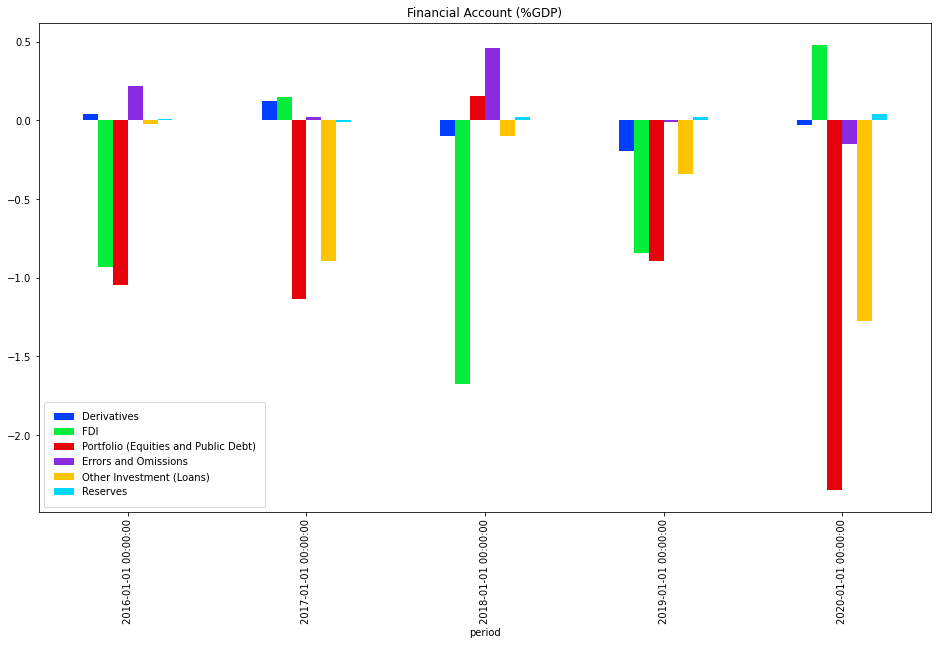

In [243]:
#Plot financial account components evolution
fin_acc_to_gdp.iloc[-5:].plot(kind='bar', figsize=(16,9))
plt.legend(['Derivatives', 'FDI', 'Portfolio (Equities and Public Debt)', 'Errors and Omissions', 'Other Investment (Loans)', 'Reserves'], loc='lower left', borderpad=1)
plt.title('Financial Account (%GDP)')
plt.show()

The Financial Account has to be interpreted as: if CA > 0, then FA > 0; if CA < 0, then FA < 0. In fact, the financial account is the way current account is financed. Therefore, a negative change in FDI/Portfolio/Derivatives/Other Investment means that the country is accumulating more liabilities (i.e. inward flows > outward flows); on the contrary, if there is a positive change in FDI/Portfolio/Derivatives/Other Investment this means that the country is accumulating more assets abroad (i.e. inward flows < outward flows). When reserves are decreasing, it's likely that the country is financing temporary shocks to the CA with its stock of reserves. This is a short-term strategy that cannot be sustained for long periods, especially if reserves are depleted rapidly. In fact, in such instances speculative attacks on the local currency can easily take place.

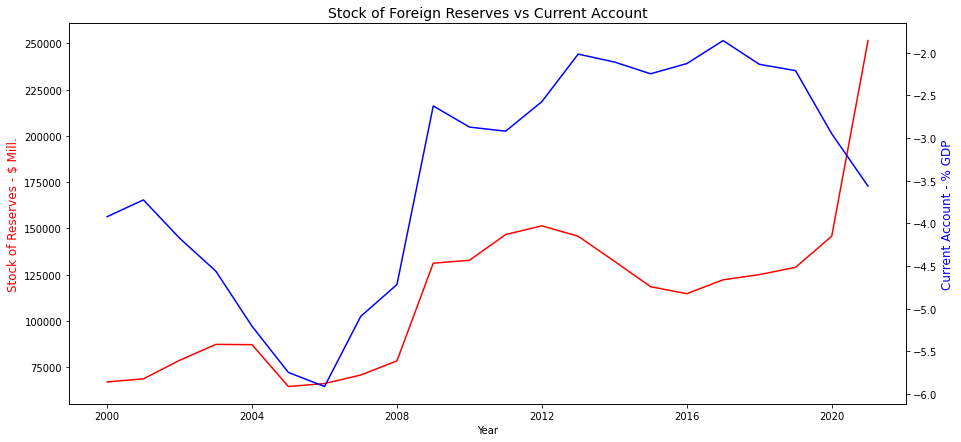

In [244]:
#Download stock of foreign reserves data
fx_reserves = fetch_series('IMF/IRFCL/A.US.RAF_USD.S1X')
fx_reserves = clean_data(fx_reserves, 'Stock of Foreign Reserves - A')
fx_reserves['CA'] = ca_ann
fx_reserves = fx_reserves.dropna()

#Plot stock of foreign reserves data
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fx_reserves.index, fx_reserves['Stock of Foreign Reserves - A'], color='r')
ax.set_xlabel('Year')
ax.set_ylabel('Stock of Reserves - $ Mill.', fontsize=12, color='r')
ax2 = ax.twinx()
ax2.plot(fx_reserves.index, fx_reserves['CA'], color='b')
ax2.set_ylabel('Current Account - % GDP', fontsize=12, color='b')

plt.title('Stock of Foreign Reserves vs Current Account', fontsize=14)
plt.show()

# Section 10: Real Exchange Rate and Competitiveness

In this section we are looking at how the current account and REER are positioned relative to their equilibrium levels. Specifically, with the help of the IMF External Balance Assessment framework, we will see if the country is running a positive current account gap (i.e., Actual CA > Norm CA) or a negative current account gap (i.e., Actual CA < Norm CA). In the former case, the REER is relatively undervalued and it has to appreciate to bring the CA balance back to its equilibrium level (in this scenario, exports are more stimulated than imports); in the latter case, REER is to be considered overvalued and it has to depreciate to bring the CA balance back to its equilibrium level (in this scenario, imports are more stimulated than exports).

There are several methods used by IMF to assess the current account gap and REER gap compared to their equilibrium level (i.e., EBA CA Regression, External Sustainability approach, EBA REER Regression). Since data for these estimates cannot be downloaded from public datasets and that calculations are not easy to implement, we will only report lates data from the IMF EBA website and compared them with significant thresholds.

https://www.imf.org/external/np/res/eba/data.htm

In [245]:
#CURRENT ACCOUNT REGRESSION-BASED ANALYSIS
period = [2014, 2015, 2016, 2017, 2018, 2019, 2020]

reg_ca_gap = [-1.2, -1.7, -1.0, -1.6, -1.2, -1.3, -2.2]

In [246]:
#EXTERNAL SUSTAINABILITY ANALYSIS
es_ca_gap = [-1.2, -1.3, -2.0, -1.5, -1.2, -1.2, 0.5]

In [247]:
#REER REGRESSION-BASED ANALYSIS: INDEX REER
index_reer_gap = [2.3, 14.1, 15.8, 8.1, 8.0 ,8.1, 8.3]

In [248]:
#REER REGRESSION-BASED ANALYSIS: LEVEL REER
level_reer_gap = [8.2, 23.3, 25.0, 14.4, 11.9, 10.9, 12.4]

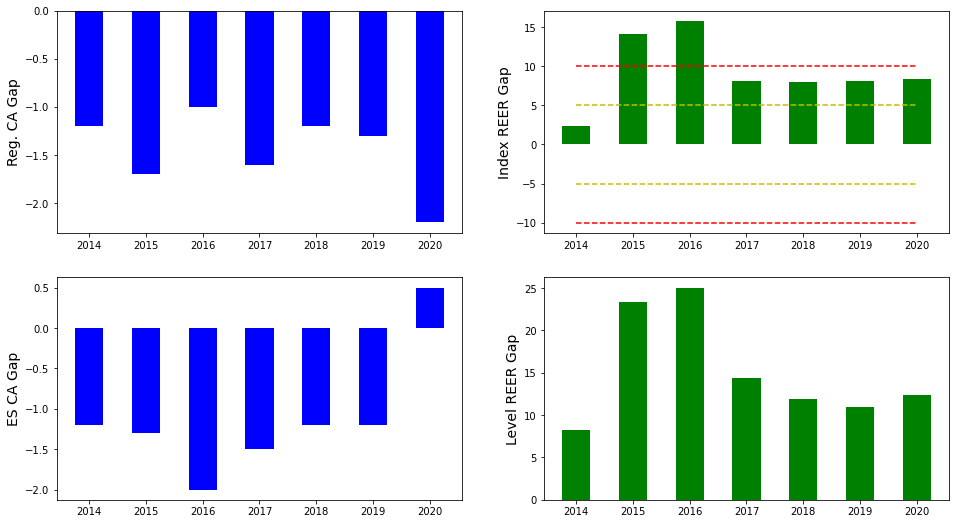

In [249]:
#Plot CA and REER gap according to EBA framework
fig, axs = plt.subplots(2, 2, figsize=(16, 9))

axs[0,0].bar(period, reg_ca_gap, width=0.5, color='b')
axs[0,0].set_ylabel('Reg. CA Gap', fontsize=14)

axs[1,0].bar(period, es_ca_gap, width=0.5, color='b')
axs[1,0].set_ylabel('ES CA Gap', fontsize=14)

axs[0,1].bar(period, index_reer_gap, width=0.5, color='g')
axs[0,1].plot([period[0], period[-1]], [5,5], color='y', linestyle='--')

axs[0,1].plot([period[0], period[-1]], [10,10], color='r', linestyle='--')
axs[0,1].plot([period[0], period[-1]], [-5,-5], color='y', linestyle='--')

axs[0,1].plot([period[0], period[-1]], [-10,-10], color='r', linestyle='--')
axs[0,1].set_ylabel('Index REER Gap', fontsize=14)

axs[1,1].bar(period, level_reer_gap, width=0.5, color='g')
axs[1,1].set_ylabel('Level REER Gap', fontsize=14)

plt.show()

According to the IMF framework, if the value of the REER gap is between -5% and 5%, then the REER is broadly in line with fundamentals. If it is between -5% and -10% or between 5% and 10%, then it is moderately misaligned. 

# Section 11: Trading Partners Analysis

In this section we will assess economic health status of main trading partners of the country to determine if there is an external threat to growth. 

In [250]:
#URL with the table containing the list of main trading partners
url="https://en.wikipedia.org/wiki/List_of_the_largest_trading_partners_of_the_United_States"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

In [251]:
#Let’s just first print the title of the webpage
print(soup.title.text)

List of the largest trading partners of the United States - Wikipedia


In [252]:
#Put data from Wikipedia into a DataFrame
tp_table = soup.find("table", attrs={"class": "wikitable"})
tp_data = pd.read_html(str(tp_table))
tp_data = pd.DataFrame(tp_data[0])
tp_data = tp_data.drop(['Exports', 'Imports'], axis=1)
tp_data.head(13)

Rank   Country/District  Total Trade  Trade Balance
0     -              World      3888236        -795690
1     -  European Union[2]       717902        -151363
2     1              China       635364        -375576
3     2             Canada       581584         -17054
4     3             Mexico       557581         -70953
5     -              ASEAN       247203         -90693
6     4              Japan       204086         -68876
7     5            Germany       171472         -63678
8     6        South Korea       119770         -23118
9     7     United Kingdom       109318           3198
10    8             France        82495         -15303
11    9              India        74292         -22914
12   10              Italy        68323         -31513

In [253]:
#Let's create a list with top trading partners GDP growth forecasts
tp_list = ['OECD/EO/CAN.GDP_ANNPCT.A', 
          'OECD/EO/CHN.GDP_ANNPCT.A', 
          'OECD/EO/DEU.GDP_ANNPCT.A', 
          'OECD/EO/FRA.GDP_ANNPCT.A', 
          'OECD/EO/GBR.GDP_ANNPCT.A',
          'OECD/EO/IND.GDP_ANNPCT.A', 
          'OECD/EO/ITA.GDP_ANNPCT.A', 
          'OECD/EO/JPN.GDP_ANNPCT.A', 
          'OECD/EO/KOR.GDP_ANNPCT.A', 
          'OECD/EO/MEX.GDP_ANNPCT.A']

#Fetch data of annual GDP grwoth for main trading partners and store them in a DataFrame
trad_part = pd.DataFrame()

for i in tp_list:
    trad_part = trad_part.append(fetch_series(i)[['period', 'series_name', 'value']])
    
trad_part = trad_part.pivot(index='period', columns='series_name', values='value')

trad_part.tail()

series_name  Canada – Gross domestic product, nominal value, growth – Annual  \
period                                                                         
2019-01-01                                            3.565128                 
2020-01-01                                           -4.578978                 
2021-01-01                                           12.586675                 
2022-01-01                                            6.835122                 
2023-01-01                                            4.699053                 

series_name  China (People's Republic of) – Gross domestic product, nominal value, growth – Annual  \
period                                                                                               
2019-01-01                                            7.313769                                       
2020-01-01                                            2.987384                                       
2021-01-01                                           12.305274                                       
2022-01-01                                            7.104265                                       
2023-01-01                                            6.580174                                       

series_name  France – Gross domestic product, nominal value, growth – Annual  \
period                                                                         
2019-01-01                                            3.139412                 
2020-01-01                                           -5.660198                 
2021-01-01                                            7.596074                 
2022-01-01                                            5.226982                 
2023-01-01                                            3.625329                 

series_name  Germany – Gross domestic product, nominal value, growth – Annual  \
period                                                                          
2019-01-01                                            3.168984                  
2020-01-01                                           -3.419970                  
2021-01-01                                            5.994034                  
2022-01-01                                            7.421682                  
2023-01-01                                            4.543452                  

series_name  India – Gross domestic product, nominal value, growth – Annual  \
period                                                                        
2019-01-01                                            7.751677                
2020-01-01                                           -2.974508                
2021-01-01                                           20.473138                
2022-01-01                                           12.833698                
2023-01-01                                           10.833630                

series_name  Italy – Gross domestic product, nominal value, growth – Annual  \
period                                                                        
2019-01-01                                            1.326517                
2020-01-01                                           -7.934734                
2021-01-01                                            7.875681                
2022-01-01                                            6.603678                
2023-01-01                                            4.231299                

series_name  Japan – Gross domestic product, nominal value, growth – Annual  \
period                                                                        
2019-01-01                                            0.660314                
2020-01-01                                           -3.779787                
2021-01-01                                            1.213398                
2022-01-01                                            4.030811                
2023-01-01   

In [254]:
#Let's rename the columns
col_names = ['Canada', 'China', 'France', 'Germany', 'India', 'Italy', 'Japan', 'South Korea', 'Mexico', 'UK']
trad_part.columns = col_names
trad_part = trad_part.iloc[-3:]
trad_part.tail()

Canada      China    France   Germany      India     Italy  \
period                                                                      
2021-01-01  12.586675  12.305274  7.596074  5.994034  20.473138  7.875681   
2022-01-01   6.835122   7.104265  5.226982  7.421682  12.833698  6.603678   
2023-01-01   4.699053   6.580174  3.625329  4.543452  10.833630  4.231299   

               Japan  South Korea     Mexico        UK  
period                                                  
2021-01-01  1.213398     6.009500  12.416304  7.779818  
2022-01-01  4.030811     4.436233   8.059298  7.153565  
2023-01-01  1.808082     3.516006   5.823086  4.360301

In [255]:
#Let's create a list with top trading partners imports (in USD) forecasts
tp_imp_list = ['OECD/EO/CAN.MGSD.A', 
              'OECD/EO/CHN.MGSD.A', 
              'OECD/EO/DEU.MGSD.A', 
              'OECD/EO/FRA.MGSD.A', 
              'OECD/EO/GBR.MGSD.A', 
              'OECD/EO/IND.MGSD.A', 
              'OECD/EO/ITA.MGSD.A', 
              'OECD/EO/JPN.MGSD.A', 
              'OECD/EO/KOR.MGSD.A', 
              'OECD/EO/MEX.MGSD.A']

#Fetch data of annual GDP grwoth for main trading partners and store them in a DataFrame
trad_part_imp = pd.DataFrame()

for i in tp_imp_list:
    trad_part_imp = trad_part_imp.append(fetch_series(i)[['period', 'series_name', 'value']])
    
trad_part_imp = trad_part_imp.pivot(index='period', columns='series_name', values='value')

trad_part_imp.tail()

series_name  Canada – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                         
2019-01-01                                        5.835605e+11                                                 
2020-01-01                                        5.108232e+11                                                 
2021-01-01                                        5.913081e+11                                                 
2022-01-01                                        6.461587e+11                                                 
2023-01-01                                        6.806044e+11                                                 

series_name  China (People's Republic of) – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                                               
2019-01-01                                        2.499155e+12                                                                       
2020-01-01                                        2.362692e+12                                                                       
2021-01-01                                        3.058856e+12                                                                       
2022-01-01                                        3.392206e+12                                                                       
2023-01-01                                        3.643952e+12                                                                       

series_name  France – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                         
2019-01-01                                        8.895233e+11                                                 
2020-01-01                                        7.845063e+11                                                 
2021-01-01                                        9.269058e+11                                                 
2022-01-01                                        1.012845e+12                                                 
2023-01-01                                        1.060225e+12                                                 

series_name  Germany – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                          
2019-01-01                                        1.597975e+12                                                  
2020-01-01                                        1.443200e+12                                                  
2021-01-01                                        1.727816e+12                                                  
2022-01-01                                        1.877339e+12                                                  
2023-01-01                                        2.008327e+12                                                  

series_name  India – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                        
2019-01-01                                        6.150194e+11                                                
2020-01-01                                        4.895917e+11                                                
2021-01-01                                        6.499796e+11                                                
2022-01-01                                        7.844323e+11                                                
2023-01-01                       

In [256]:
#Let's rename the columns
trad_part_imp.columns = col_names
trad_part_imp = trad_part_imp.iloc[-3:]
trad_part_imp.tail()

Canada         China        France       Germany  \
period                                                               
2021-01-01  5.913081e+11  3.058856e+12  9.269058e+11  1.727816e+12   
2022-01-01  6.461587e+11  3.392206e+12  1.012845e+12  1.877339e+12   
2023-01-01  6.806044e+11  3.643952e+12  1.060225e+12  2.008327e+12   

                   India         Italy         Japan   South Korea  \
period                                                               
2021-01-01  6.499796e+11  6.080505e+11  9.280972e+11  6.443101e+11   
2022-01-01  7.844323e+11  6.496823e+11  1.000796e+12  6.571346e+11   
2023-01-01  9.073869e+11  6.833186e+11  1.046514e+12  6.785322e+11   

                  Mexico            UK  
period                                  
2021-01-01  5.261153e+11  8.572694e+11  
2022-01-01  5.791398e+11  9.230091e+11  
2023-01-01  6.375810e+11  9.732347e+11

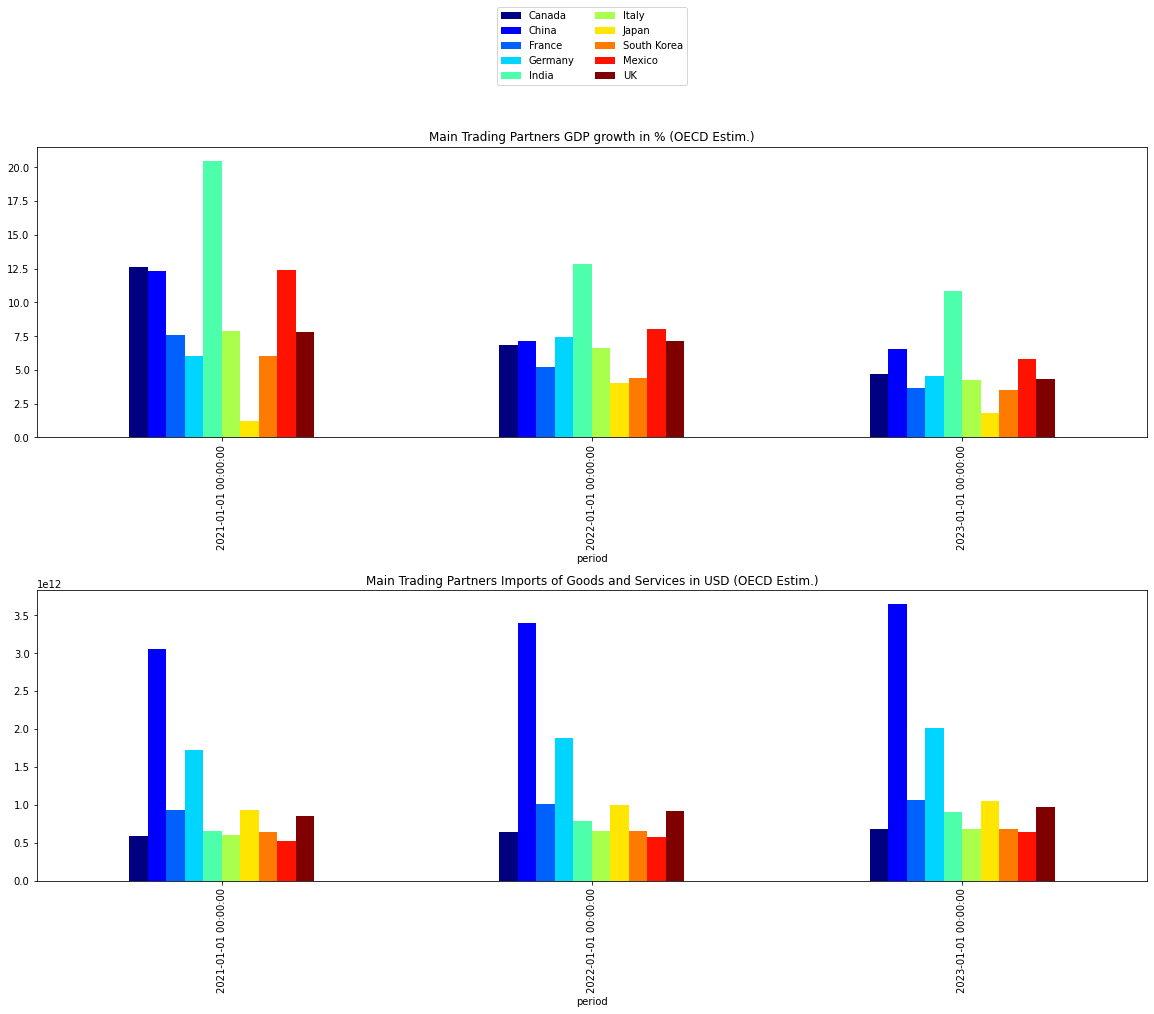

In [257]:
#Plot trading partners growth and imports forecasts
colors = plt.cm.jet(np.linspace(0, 1, 10))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,13))

ax = trad_part.plot(ax=axes[0], kind='bar', color=colors, stacked=False, legend=True, title='Main Trading Partners GDP growth in % (OECD Estim.)')

ax1 = trad_part_imp.plot(ax=axes[1], kind='bar', color=colors, stacked=False, legend=False, title='Main Trading Partners Imports of Goods and Services in USD (OECD Estim.)')

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

# Section 12: COVID-19 Analysis

In this section we are about to analyze the evolution of Covid-19 and its impact on the economy. Besides cases, deaths and vaccinations statistics, we will also look at mobility trends and the cost of transportation to assess the resiliency of the country to the pandemic. 

In [258]:
#Fetch covid-19 data
cases = fetch_series('JHU/confirmed/USA')
cases = clean_data(cases, 'Confirmed Cases')
cases['3-M Avg.'] = cases['Confirmed Cases'].rolling(90).mean()

deaths = fetch_series('JHU/deaths/USA')
deaths = clean_data(deaths, 'Deaths')
deaths['3-M Avg.'] = deaths['Deaths'].rolling(90).mean()

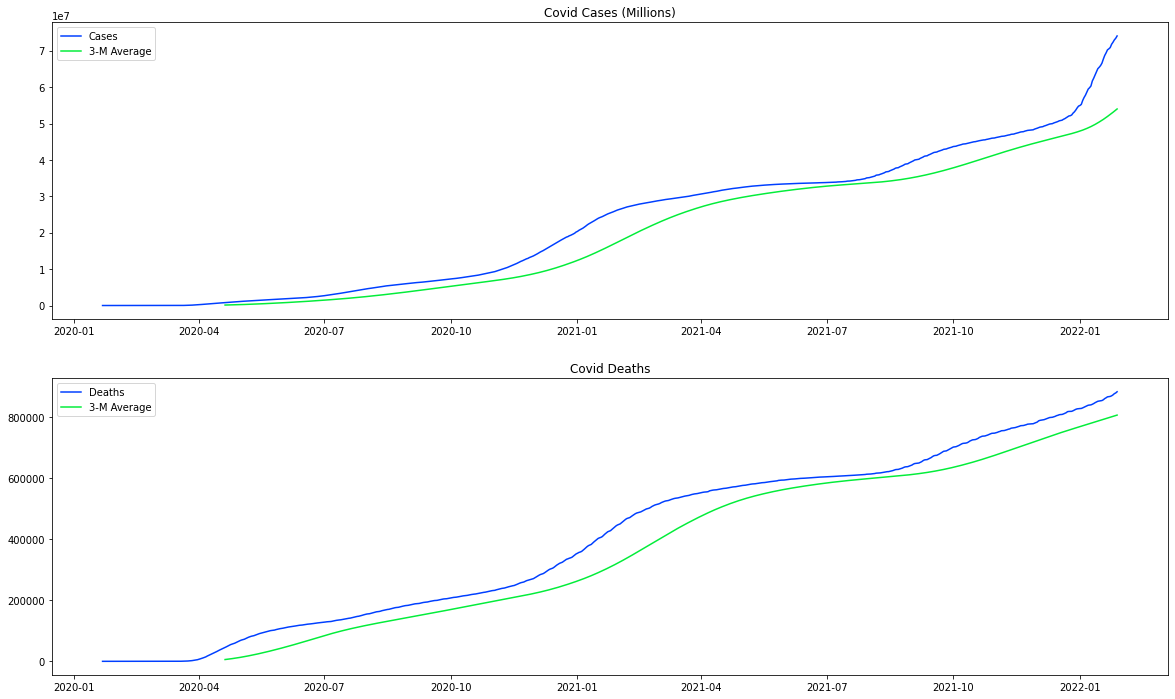

In [259]:
#Plot covid-19 data
plt.subplots(figsize=(20,12))

plt.subplot(211)
plt.plot(cases['Confirmed Cases'])
plt.plot(cases['3-M Avg.'])
plt.title('Covid Cases (Millions)')
plt.legend(['Cases', '3-M Average'])

plt.subplot(212)
plt.plot(deaths['Deaths'])
plt.plot(deaths['3-M Avg.'])
plt.title('Covid Deaths')
plt.legend(['Deaths', '3-M Average'])

plt.show()

In [260]:
#Fetch vaccinations data
first_dose = fetch_series('oppins/COV/vaccine_rate.US.VACCINE.CUM.D')
first_dose = clean_data(first_dose, 'First Vaccine Dose Administered')

full_vaccine = fetch_series('oppins/COV/fullvaccine_rate.US.FULLVACCINE.CUM.D')
full_vaccine = clean_data(full_vaccine, 'Vaccine Series Completed')

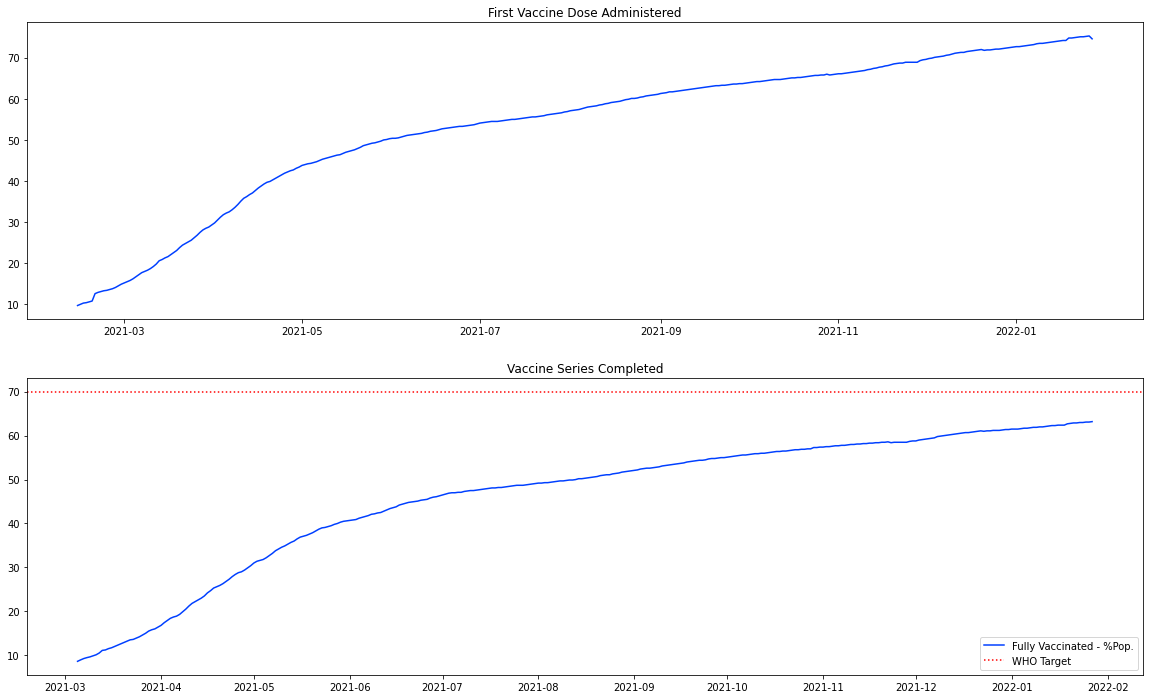

In [261]:
#Plot vaccinations data
plt.subplots(figsize=(20,12))

plt.subplot(211)
plt.plot(first_dose)
plt.title('First Vaccine Dose Administered')

plt.subplot(212)
plt.plot(full_vaccine)
plt.axhline(y=70, color='red', linestyle='dotted')
plt.title('Vaccine Series Completed')
plt.legend(['Fully Vaccinated - %Pop.', 'WHO Target'])

plt.show()

In [262]:
#Fetch Apple Mobility Trend data
driving = fetch_series('Apple/AMT/USA.driving')
driving = clean_data(driving, 'Driving')
driving = driving.fillna(method='ffill')
driving['3-M Avg.'] = driving['Driving'].rolling(90).mean()

transit = fetch_series('Apple/AMT/USA.transit')
transit = clean_data(transit, 'Transit')
transit = transit.fillna(method='ffill')
transit['3-M Avg.'] = transit['Transit'].rolling(90).mean()

walking = fetch_series('Apple/AMT/USA.walking')
walking = clean_data(walking, 'Walking')
walking = walking.fillna(method='ffill')
walking['3-M Avg.'] = walking['Walking'].rolling(90).mean()

Reports are published daily and reflect requests for directions in Apple Maps.

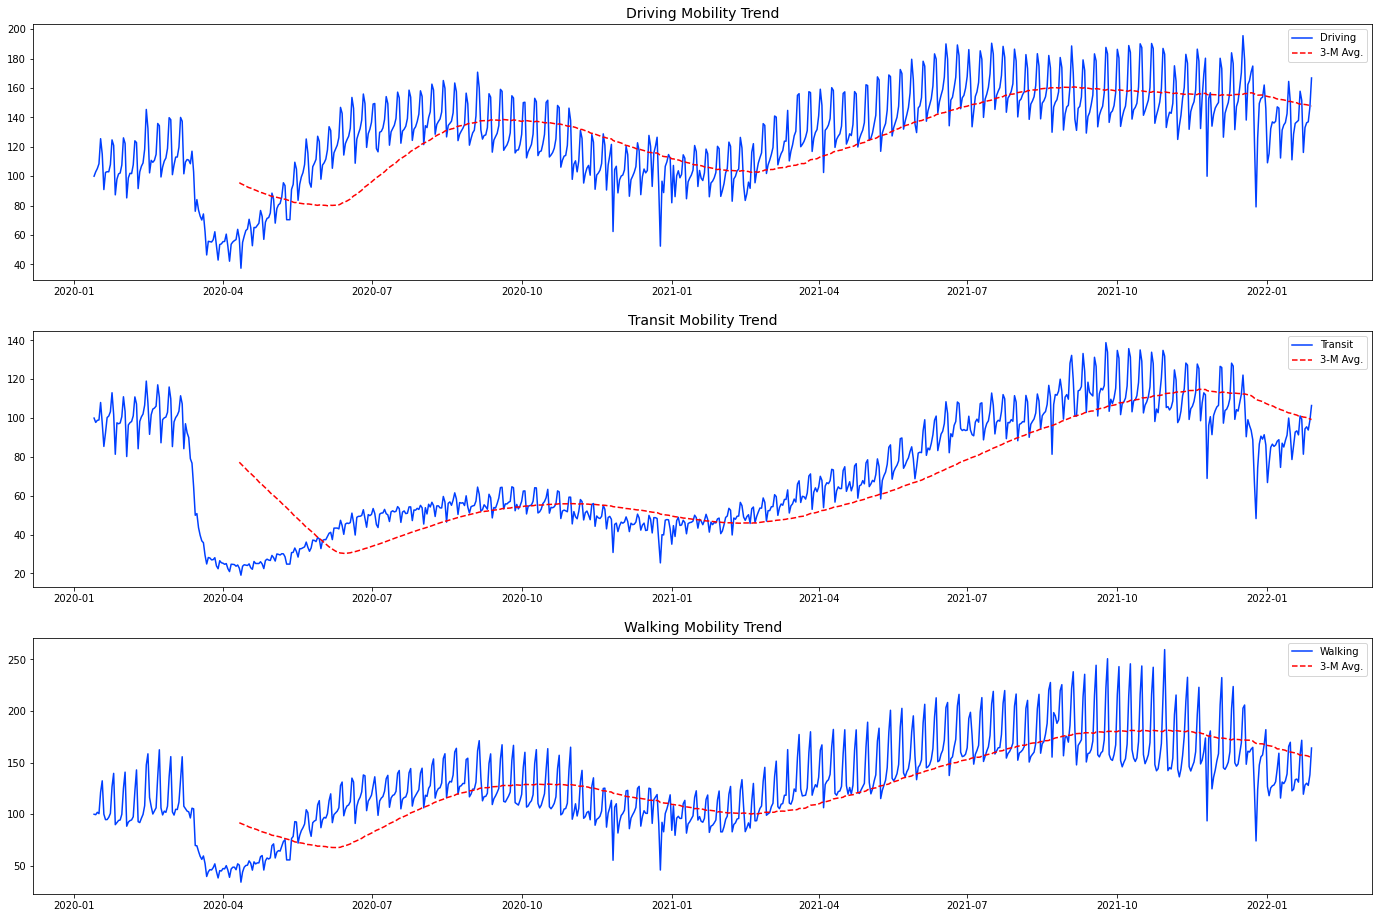

In [263]:
#Plot Apple Mobility Trend data
plt.subplots(figsize=(24,16))

plt.subplot(311)
plt.plot(driving['Driving'])
plt.plot(driving['3-M Avg.'], linestyle='--', color='r')
plt.legend(['Driving', '3-M Avg.'])
plt.title('Driving Mobility Trend', fontsize=14)

plt.subplot(312)
plt.plot(transit['Transit'])
plt.plot(transit['3-M Avg.'], linestyle='--', color='r')
plt.legend(['Transit', '3-M Avg.'])
plt.title('Transit Mobility Trend', fontsize=14)

plt.subplot(313)
plt.plot(walking['Walking'])
plt.plot(walking['3-M Avg.'], linestyle='--', color='r')
plt.legend(['Walking', '3-M Avg.'])
plt.title('Walking Mobility Trend', fontsize=14)


plt.show()

In [264]:
#Fetch Google Global Mobility Report data
retail = fetch_series('Google/GMR/US.retrec')
retail = clean_data(retail, 'Retail and Recreation')
retail = retail.fillna(method='ffill')
retail['3-M Avg.'] = retail['Retail and Recreation'].rolling(90).mean()

transit_stations = fetch_series('Google/GMR/US.transit')
transit_stations = clean_data(transit_stations, 'Transit Stations')
transit_stations = transit_stations.fillna(method='ffill')
transit_stations['3-M Avg.'] = transit_stations['Transit Stations'].rolling(90).mean()

work = fetch_series('Google/GMR/US.work')
work = clean_data(work, 'Work')
work = work.fillna(method='ffill')
work['3-M Avg.'] = work['Work'].rolling(90).mean()

These Community Mobility Reports aim to provide insights into what has changed in response to policies aimed at combating COVID-19. The reports chart movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential.

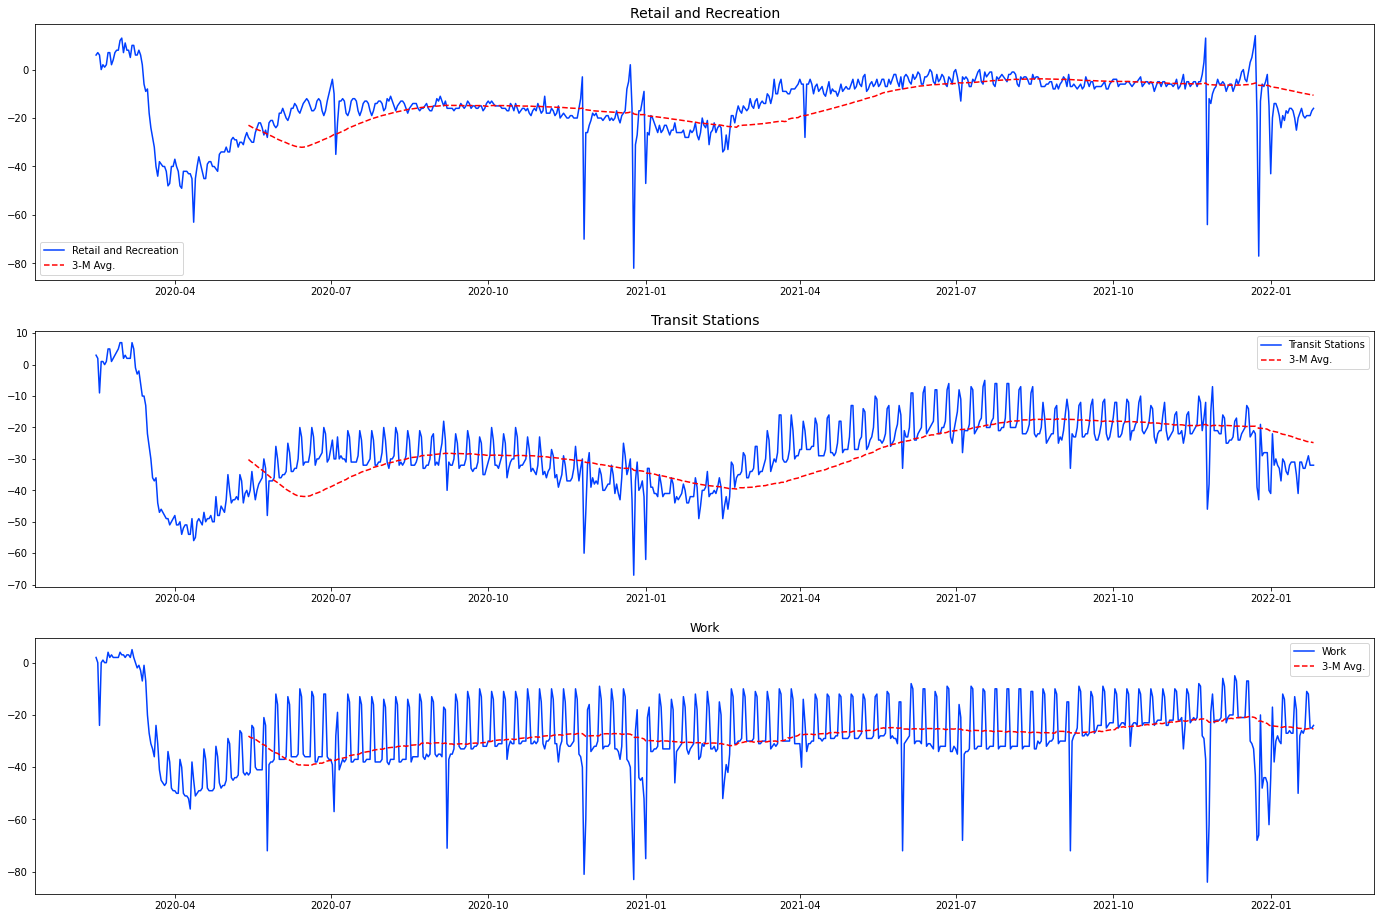

In [265]:
#Plot Google Mobility Report data
plt.subplots(figsize=(24,16))

plt.subplot(311)
plt.plot(retail['Retail and Recreation'])
plt.plot(retail['3-M Avg.'], color='r', linestyle='--')
plt.legend(['Retail and Recreation', '3-M Avg.'])
plt.title('Retail and Recreation', fontsize=14)

plt.subplot(312)
plt.plot(transit_stations['Transit Stations'])
plt.plot(transit_stations['3-M Avg.'], color='r', linestyle='--')
plt.legend(['Transit Stations', '3-M Avg.'])
plt.title('Transit Stations', fontsize=14)

plt.subplot(313)
plt.plot(work['Work'])
plt.plot(work['3-M Avg.'], color='r', linestyle='--')
plt.legend(['Work', '3-M Avg.'])
plt.title('Work')

plt.show()

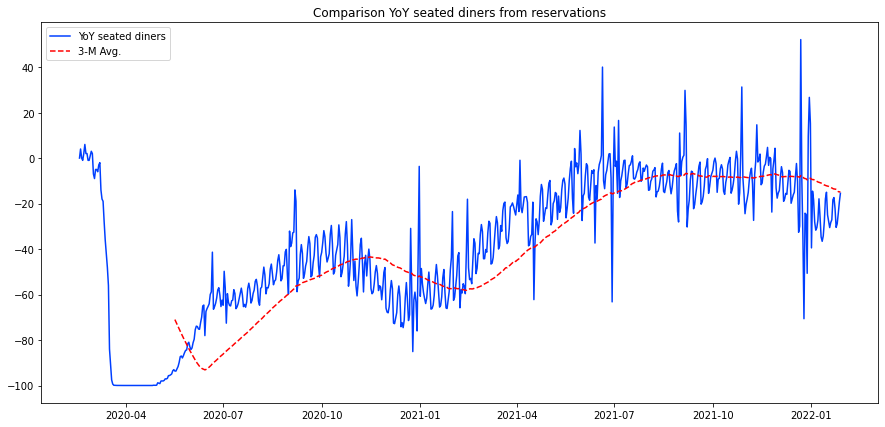

In [266]:
#Fetch State of Restaurant Industry by OpenTable to assess re-openness of the economy
opentable = fetch_series('OpenTable/SRI/united_states.country.yoy')
opentable = clean_data(opentable, 'Comparison YoY seated diners')

#Plot OpenTable data
plt.figure(figsize=(15,7))
plt.plot(opentable)
plt.plot(opentable.rolling(90).mean(), color='r', linestyle='--')
plt.legend(['YoY seated diners', '3-M Avg.'])
plt.title('Comparison YoY seated diners from reservations')
plt.show()

In [267]:
#Fetch Airline Ticket Price Index and Gasoline retail price data

airline_ticket = fetch_series('EIA/STEO/ACTKFUS.M')
airline_ticket = clean_data(airline_ticket, 'Airline Ticket Price Index')
airline_ticket = airline_ticket.iloc[-72:]
airline_ticket['12-M Avg.'] = airline_ticket['Airline Ticket Price Index'].rolling(12).mean()

gasoline = fetch_series('EIA/STEO/MGRARUS_$.M')
gasoline = clean_data(gasoline, 'Gasoline - $/gallon')
gasoline = gasoline.iloc[-72:]
gasoline['12-M Avg.'] = gasoline['Gasoline - $/gallon'].rolling(12).mean()

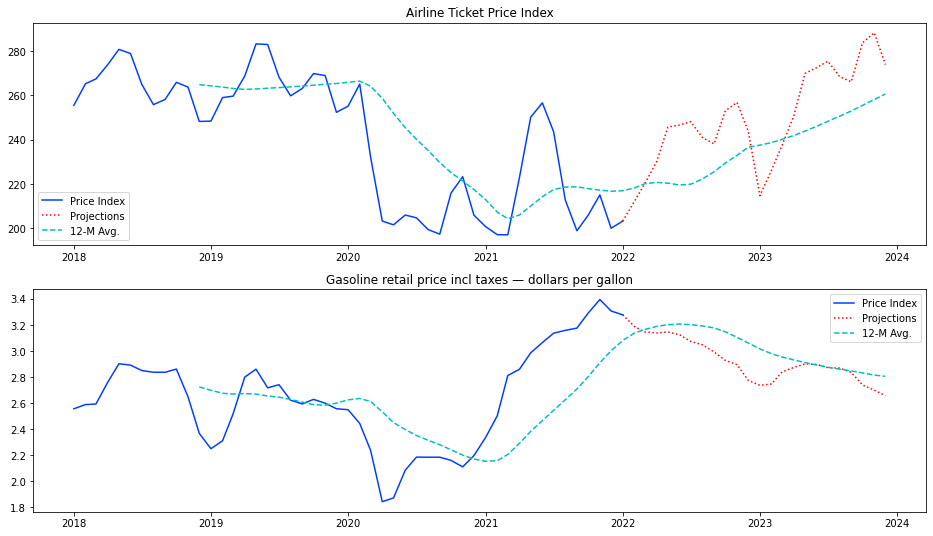

In [268]:
#Plot Airline Ticket Price Index and Gasoline retail price data
plt.subplots(figsize=(16,9))

plt.subplot(211)
plt.plot(airline_ticket['Airline Ticket Price Index'].loc[:current_month])
plt.plot(airline_ticket['Airline Ticket Price Index'].loc[current_month:], linestyle='dotted', color='r')
plt.plot(airline_ticket['12-M Avg.'], color='c', linestyle='--')
plt.legend(['Price Index', 'Projections', '12-M Avg.'])
plt.title('Airline Ticket Price Index')

plt.subplot(212)
plt.plot(gasoline['Gasoline - $/gallon'].loc[:current_month])
plt.plot(gasoline['Gasoline - $/gallon'].loc[current_month:], linestyle='dotted', color='r')
plt.plot(gasoline['12-M Avg.'], color='c', linestyle='--')
plt.legend(['Price Index', 'Projections', '12-M Avg.'])
plt.title('Gasoline retail price incl taxes — dollars per gallon')

plt.show()

# Section 13: Climate Change Readiness and Vulnerability Analysis

In this section we will analyse the evolution of the readiness and vulnerability to climate change indicators of the country. We will specifically look at the Notre Dame-Global Adaptation Index (ND-GAIN) framework, even if data is available only up to 2019. Therefore, an educated guess has to be taken for the most current period and future expectations.

The Notre Dame-Global Adaptation Index (ND-GAIN) Country Index is a free opensource index that shows a country’s current vulnerability to climate disruptions. It also assesses a country’s readiness to leverage private and public sector investment for adaptive actions. ND-GAIN brings together over 74 variables to form 45 core indicators to measure vulnerability and readiness of 192 UN countries from 1995 to the present. All countries, to different extents, are facing the challenges of adaptation. Due to geographical location or socio-economic condition, some countries are more vulnerable to the impacts of climate change than others. Further, some countries are more ready to take on adaptation actions by leveraging public and private sector investments, through government action, community awareness, and the ability to facilitate private sector responses. ND-GAIN measures both of these dimensions:
vulnerability and readiness. 

For more information: https://gain.nd.edu/assets/254377/nd_gain_technical_document_2015.pdf

ND-GAIN’s framework breaks the measure of vulnerability into exposure, sensitivity and adaptive capacity, and the measure of readiness into economic, governance and social components. The construction of the ND-GAIN framework is based on published peer-reviewed material, the IPCC Review process, and feedback from corporate stakeholders, practitioners and development users.

In [269]:
#Fetch ND-GAIN index data and store them in a DataFrame
nd_gain_list = ['ND_GAIN/gain/A.USA', 
                'ND_GAIN/gain/A.AUS', 
                'ND_GAIN/gain/A.CAN', 
                'ND_GAIN/gain/A.CHN',
                'ND_GAIN/gain/A.DEU', 
                'ND_GAIN/gain/A.FRA', 
                'ND_GAIN/gain/A.GBR', 
                'ND_GAIN/gain/A.ITA', 
                'ND_GAIN/gain/A.JPN', 
                'ND_GAIN/gain/A.NZL']

nd_gain = pd.DataFrame()

for i in nd_gain_list:
    nd_gain = nd_gain.append(fetch_series(i)[['period', 'series_name', 'value']])
    
nd_gain = nd_gain.pivot(index='period', columns='series_name', values='value')

nd_gain.tail()

series_name  Annual – Australia  Annual – Canada  Annual – China  \
period                                                             
2015-01-01            70.520453        69.784502       53.045973   
2016-01-01            70.514831        69.268444       53.214818   
2017-01-01            69.851120        69.054408       53.834494   
2018-01-01            70.080946        68.368185       54.031530   
2019-01-01            69.863747        68.183637       57.203921   

series_name  Annual – France  Annual – Germany  Annual – Italy  \
period                                                           
2015-01-01         68.697363         71.702135       60.041291   
2016-01-01         68.083623         70.981536       59.770244   
2017-01-01         68.319847         70.840362       59.637638   
2018-01-01         68.175934         70.805065       60.342884   
2019-01-01         68.875286         70.561363       60.494706   

series_name  Annual – Japan  Annual – New Zealand  Annual – United Kingdom  \
period                                                                       
2015-01-01        68.598817             76.279972                71.899332   
2016-01-01        67.811165             75.728593                71.012710   
2017-01-01        68.162109             75.684566                70.595824   
2018-01-01        67.989624             75.535487                70.150924   
2019-01-01        67.878913             71.626151                70.231033   

series_name  Annual – United States  
period                               
2015-01-01                68.545424  
2016-01-01                66.922548  
2017-01-01                67.992118  
2018-01-01                67.803312  
2019-01-01                67.148960

In [270]:
#Rename columns of ND-GAIN DataFrame
columns = ['Australia', 'Canada', 'China', 'France', 'Germany', 'Italy', 'Japan', 'New Zealand', 'UK', 'USA']

nd_gain.columns = columns
nd_gain.tail()

Australia     Canada      China     France    Germany      Italy  \
period                                                                         
2015-01-01  70.520453  69.784502  53.045973  68.697363  71.702135  60.041291   
2016-01-01  70.514831  69.268444  53.214818  68.083623  70.981536  59.770244   
2017-01-01  69.851120  69.054408  53.834494  68.319847  70.840362  59.637638   
2018-01-01  70.080946  68.368185  54.031530  68.175934  70.805065  60.342884   
2019-01-01  69.863747  68.183637  57.203921  68.875286  70.561363  60.494706   

                Japan  New Zealand         UK        USA  
period                                                    
2015-01-01  68.598817    76.279972  71.899332  68.545424  
2016-01-01  67.811165    75.728593  71.012710  66.922548  
2017-01-01  68.162109    75.684566  70.595824  67.992118  
2018-01-01  67.989624    75.535487  70.150924  67.803312  
2019-01-01  67.878913    71.626151  70.231033  67.148960

In [271]:
#Plot ND-GAIN data for country comparison
plt.figure(figsize=(16,9))
fig2 = px.line(nd_gain, x=nd_gain.index, y=['Australia', 'Canada', 'China', 'France', 'Germany', 'Italy', 'Japan', 'New Zealand', 'UK', 'USA'], title='ND-GAIN')
fig2.update_xaxes(rangeslider_visible=True)
fig2.show()

<Figure size 1152x648 with 0 Axes>

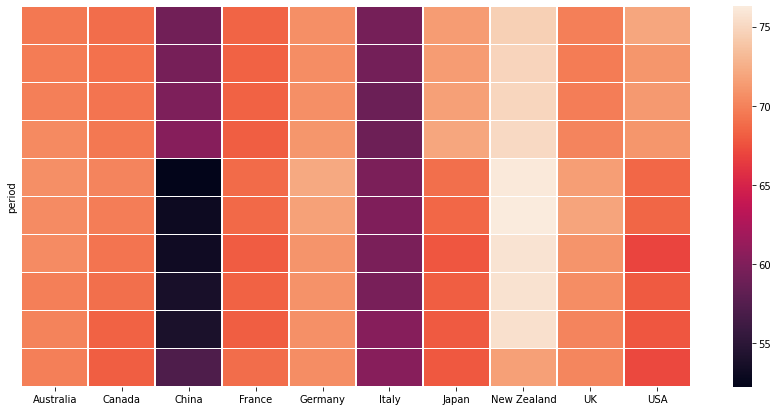

In [272]:
#Plot a heatmap to better assess the trend in the ND-GAIN index
plt.figure(figsize=(15,7))
ax = sns.heatmap(nd_gain.iloc[-10:], linewidths=.5, yticklabels=False)

In [273]:
#Fetch ND-GAIN Vulnerability and Readiness data
vulnerability = fetch_series('ND_GAIN/vulnerability/A.USA')
vulnerability = clean_data(vulnerability, 'Vulnerability')

readiness = fetch_series('ND_GAIN/readiness/A.USA')
readiness = clean_data(readiness, 'Readiness')

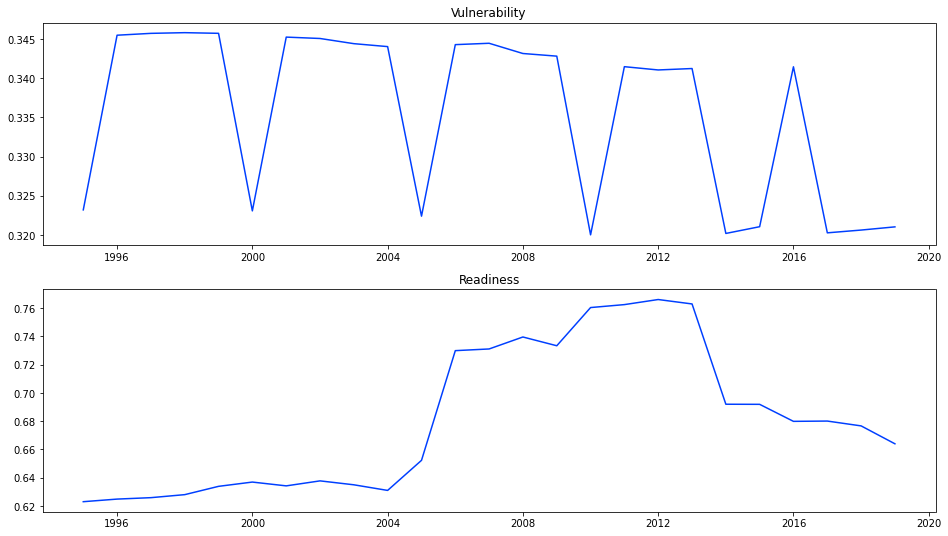

In [274]:
#Plot ND-GAIN Vulnerability and Readiness data
plt.subplots(figsize=(16,9))

plt.subplot(211)
plt.plot(vulnerability)
plt.title('Vulnerability')

plt.subplot(212)
plt.plot(readiness)
plt.title('Readiness')

plt.show()

Propensity or predisposition of human societies to be negatively impacted by climate hazards.

ND-GAIN assesses the vulnerability of a country by considering six life-supporting sectors: food, water, health, ecosystem services, human habitat and infrastructure. Each sector is in turn represented by six indicators that represent three cross-cutting components: the exposure of the sector to climate-related or climate-exacerbated hazards; the sensitivity of that sector to the impacts of the hazard and the adaptive capacity of the sector to cope or adapt to these impacts.

Exposure: The extent to which human society and its supporting sectors are stressed by the future changing climate conditions. Exposure in ND-GAIN captures the physical factors external to the system that contribute to vulnerability.

Sensitivity: The degree to which people and the sectors they depend upon are affected by climate related perturbations. The factors increasing sensitivity include the degree of dependency on sectors that are climate-sensitive and proportion of populations sensitive to climate hazard due to factors such as topography and demography. 

Adaptive capacity: The ability of society and its supporting sectors to adjust to reduce potential damage and to respond to the negative consequences of climate events. In ND-GAIN adaptive capacity indicators seek to capture a collection of means, readily deployable to deal with sector-specific climate change impacts.

In [275]:
#Fetch data for Vulnerability assessment
exposure = fetch_series('ND_GAIN/eposure/A.USA')
exposure = clean_data(exposure, 'Exposure')

sensitivity = fetch_series('ND_GAIN/sensitivity/A.USA')
sensitivity = clean_data(sensitivity, 'Sensitivity')

adapt_capac = fetch_series('ND_GAIN/capacity/A.USA')
adapt_capac = clean_data(adapt_capac, 'Adaptive Capacity')

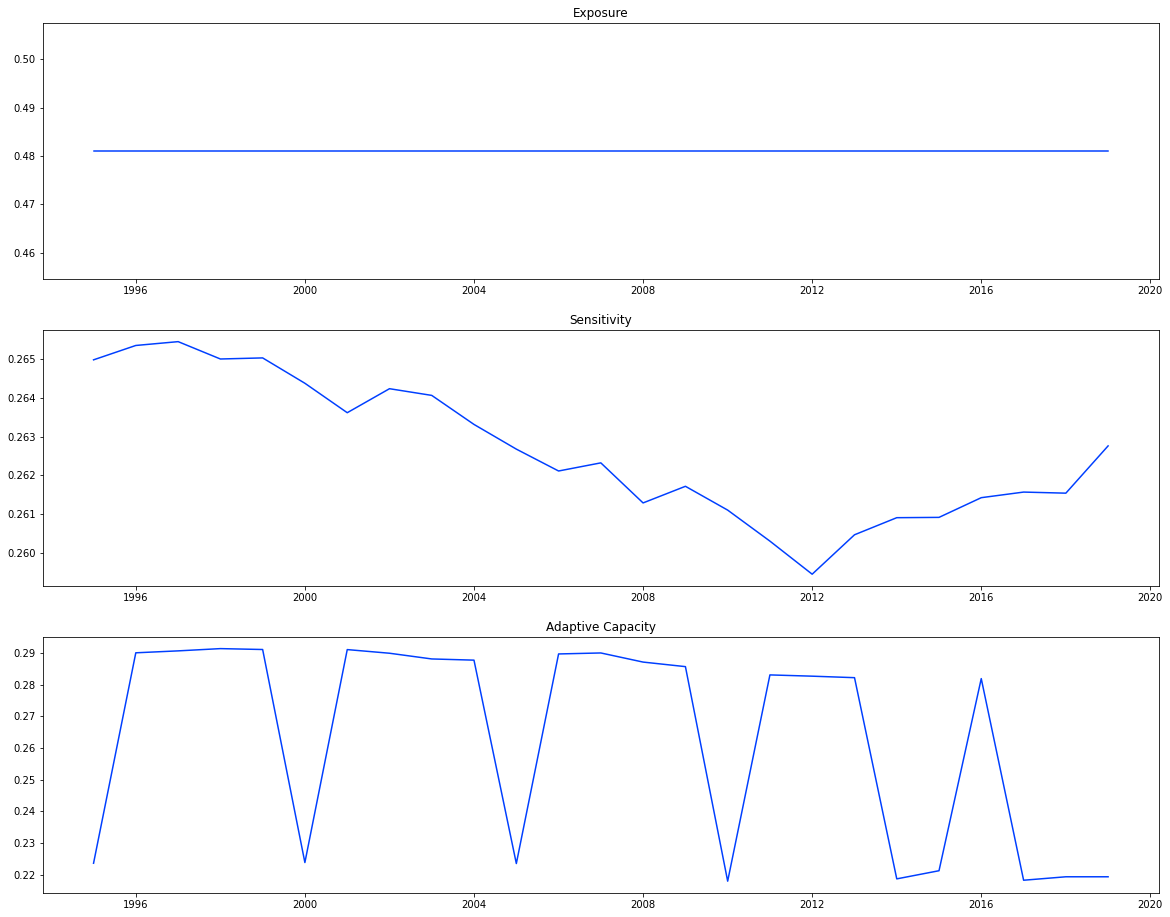

In [276]:
#Plot data for Vulnerability assessment
plt.subplots(figsize=(20,16))

plt.subplot(311)
plt.plot(exposure)
plt.title('Exposure')

plt.subplot(312)
plt.plot(sensitivity)
plt.title('Sensitivity')

plt.subplot(313)
plt.plot(adapt_capac)
plt.title('Adaptive Capacity')

plt.show()

In [277]:
#Fetch vulnerability-related data for each sector considered
food = fetch_series('ND_GAIN/food/A.USA')
food = clean_data(food, 'Food')

water = fetch_series('ND_GAIN/water/A.USA')
water = clean_data(water, 'Water')

health = fetch_series('ND_GAIN/health/A.USA')
health = clean_data(health, 'Health')

ecosystem = fetch_series('ND_GAIN/ecosystems/A.USA')
ecosystem = clean_data(ecosystem, 'Ecosystem')

habitat = fetch_series('ND_GAIN/habitat/A.USA')
habitat = clean_data(habitat, 'Habitat')

infrastructure = fetch_series('ND_GAIN/infrastructure/A.USA')
infrastructure = clean_data(infrastructure, 'Infrastructure')

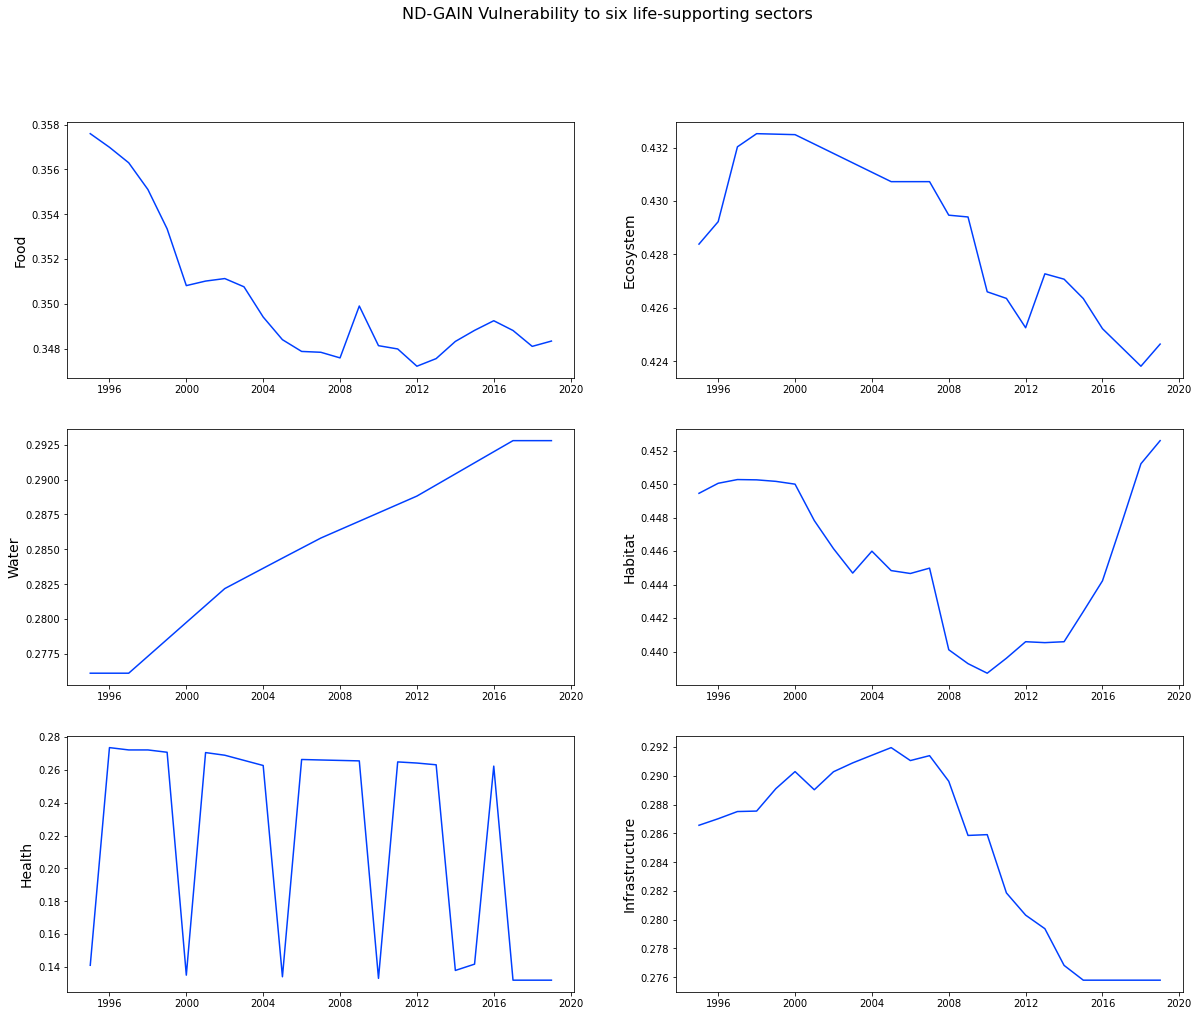

In [325]:
#Plot vulnerability-related data for each sector considered
fig, axs = plt.subplots(3, 2, figsize=(20, 16))

plt.suptitle('ND-GAIN Vulnerability to six life-supporting sectors', size=16)

axs[0,0].plot(food)
axs[0,0].set_ylabel('Food', fontsize=14)

axs[1,0].plot(water)
axs[1,0].set_ylabel('Water', fontsize=14)

axs[2,0].plot(health)
axs[2,0].set_ylabel('Health', fontsize=14)

axs[0,1].plot(ecosystem)
axs[0,1].set_ylabel('Ecosystem', fontsize=14)

axs[1,1].plot(habitat)
axs[1,1].set_ylabel('Habitat', fontsize=14)

axs[2,1].plot(infrastructure)
axs[2,1].set_ylabel('Infrastructure', fontsize=14)

plt.show()

Readiness to make effective use of investments for adaptation actions thanks to a safe and efficient business environment ND-GAIN measures readiness by considering a country’s ability to leverage investments to adaptation actions. 

ND-GAIN measures overall readiness by considering three components: economic readiness, governance readiness and social readiness. 

Economic Readiness: The investment climate that facilitates mobilizing capitals from private sector.

Governance Readiness: The stability of the society and institutional arrangements that contribute to the investment risks. A stable country with high governance capacity reassures investors that the invested capitals could grow under the help of responsive public services and without significant interruption.

Social readiness: Social conditions that help society to make efficient and equitable use of investment and yield more benefit from the investment

In [279]:
#Fetch data for Readiness assessment
economic = fetch_series('ND_GAIN/economic/A.USA')
economic = clean_data(economic, 'Economic')

governance = fetch_series('ND_GAIN/governance/A.USA')
governance = clean_data(governance, 'Governance')

social = fetch_series('ND_GAIN/social/A.USA')
social = clean_data(social, 'Social')

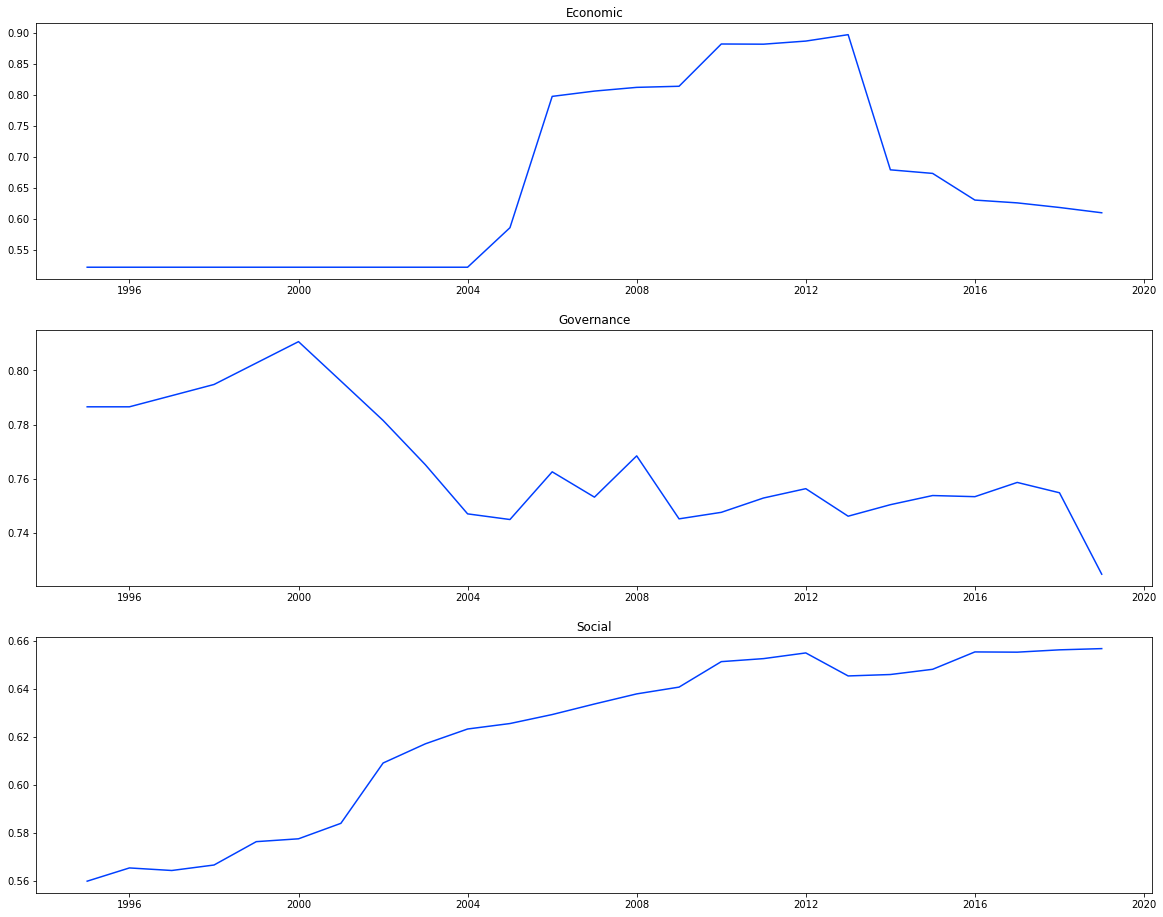

In [280]:
#Plot data for Readiness assessment
plt.subplots(figsize=(20,16))

plt.subplot(311)
plt.plot(economic)
plt.title('Economic')

plt.subplot(312)
plt.plot(governance)
plt.title('Governance')

plt.subplot(313)
plt.plot(social)
plt.title('Social')

plt.show()

# Section 14: Risk Assessment Matrix

|Nature of risk | Source of Risk |Most Direct Indicators | Likelihood of Severe Impact |
|:- | :- |:-| :-|
|Domestic | Growth | TFP, Labour, Capital, Agg. Demand, Covid-19 Stats. | Medium |
|External | Growth | Trading Partners Analysis| High |
|Domestic | Monetary / Inflation | Output Gap, Inflation Expectations, RMCI | High |
|Domestic | Fiscal | Fiscal Stance and Impulse, Fiscal Sustainability| Medium |
|Domestic |Financial Sector | FSI | Low |
|External |External Trade | External Sector Indicators | Medium |
|External |External Financial | EBA | Low|
|Global | Climate Change | ND-GAIN | Medium |

### Final comment

From the Risk Assessment Matrix we can claim that the overall country risk for the USA is "medium". The growth analysis seems to indicate that prospects are positive, with a strong growth path in 2021 followed by a slowdown in 2022, despite keeping on a positive trajectory. Demand remains strong, with services that are rebounding compared to last year as economy re-opening kicked-in (evidenced by mobility data too). The main threat seems to come from inflationary pressures, with an output gap that is becoming positive, as the economy heats up. Despite policymakers claiming that inflationary pressures will fade in the following months, we have to be careful of the trajectory on which salaries and commodity prices are positioned. On the fiscal side, the stimulus provided from the Government to boost households consumption and support businesses after the pandemic is accelerating an upward spiral, which can be difficult to sustain in the long-run, unless the country proves to grow faster than the cost of its debt. Low risks seem to come from the financial sector where each indicator is well below critical thresholds. At the moment, it doesn't seem that external risks may poise particular threats, but current supply-chain bottlenecks may endanger growth in the coming months. Climate change remains a risk to consider as evidenced by the recent damages the country has suffered, so it has to invest more to make its adaptation to climate impacts more effective.